# Home Loan Default Risk Management

## Requirement Gathering

There are 7 csv files provided by customer, application_train.csv is the file to be used for modelling and final outcome. It has current loan application of the customers alongwith their personal, financial and demographic information. The other 6 files have historical loan applications of the customer which is as below,

- Financial Bureau
This includes 2 files, bureau.csv & bureau_balance.csv, both files provides insight of those customers who have taken loans from other financial institutions. it consisits of their loan details and their loan status.
- Internal Loan and credit card
There are 4 files here which contain details of different credit lines(POS, home loans and credit cards) of the existing customers of the finncial institution.

**Objective**
We have a feature(primary key) called ‘SK_ID_CURR’ in application_train, which acts as the input that we take to make the default predictions, and our problem at hand is a ‘Binary Classification Problem’, because given the Applicant’s ‘SK_ID_CURR’ (present ID), our task is to predict 1 (if we think our applicant is a defaulter), and 0 (if we think our applicant is not a defaulter).

## Relationship Diagram

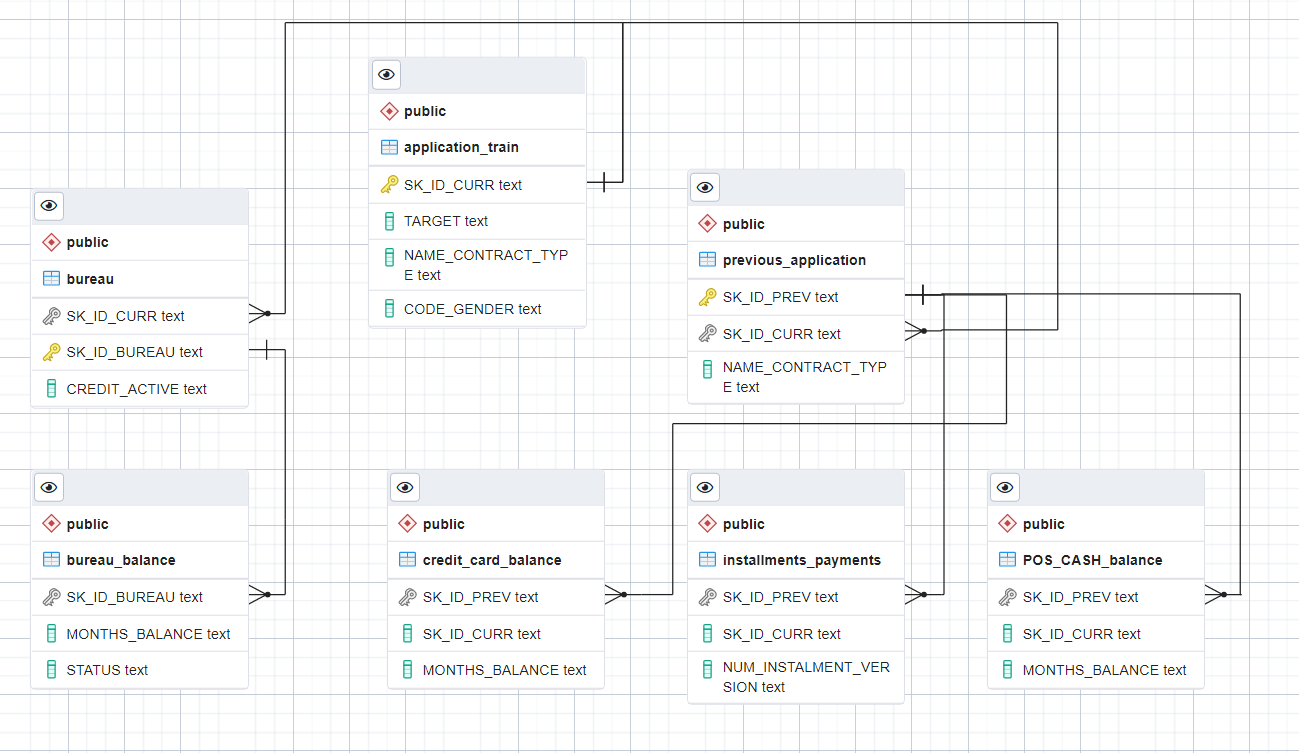

In [1]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import missingno as msno

from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer 
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.metrics import accuracy_score,balanced_accuracy_score,recall_score
from scipy.stats import chi2_contingency

from psutil import cpu_count
import warnings
warnings.filterwarnings('ignore')

C:\Users\kathi\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_application = pd.read_csv(r'C:\Users\kathi\Downloads\application_train.csv')

df_bureau = pd.read_csv(r'C:\Users\kathi\Downloads\bureau.csv',dtype={'SK_ID_BUREAU': 'int64'})

df_bureau_balance = pd.read_csv(r'C:\Users\kathi\Downloads\bureau_balance.csv',dtype={'SK_ID_BUREAU': 'int64'})

df_previous_application = pd.read_csv(r'C:\Users\kathi\Downloads\previous_application.csv')

df_credit_card_balance = pd.read_csv(r'C:\Users\kathi\Downloads\credit_card_balance.csv')

df_installments_payments = pd.read_csv(r'C:\Users\kathi\Downloads\installments_payments.csv')

df_POS_CASH_balance = pd.read_csv(r'C:\Users\kathi\Downloads\POS_CASH_balance.csv')

In [3]:
def downcast_df(df):
    for col in df.select_dtypes(include='int64').columns:
        df[col]=pd.to_numeric(df[col],downcast='integer')
    for col in df.select_dtypes(include='float64').columns:
        df[col]=pd.to_numeric(df[col],downcast='float')
    for col in df.select_dtypes(include='O').columns:
        df[col]=df[col].astype('category')
        
    return df   

In [4]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
df_application = downcast_df(df_application)

In [6]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float32(64), float64(1), int16(2), int32(2), int8(37)
memory usage: 96.5 MB


In [7]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [8]:
#Downcasting to reduce memory
df_bureau = downcast_df(df_bureau)

In [9]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   SK_ID_CURR              int32   
 1   SK_ID_BUREAU            int32   
 2   CREDIT_ACTIVE           category
 3   CREDIT_CURRENCY         category
 4   DAYS_CREDIT             int16   
 5   CREDIT_DAY_OVERDUE      int16   
 6   DAYS_CREDIT_ENDDATE     float32 
 7   DAYS_ENDDATE_FACT       float32 
 8   AMT_CREDIT_MAX_OVERDUE  float64 
 9   CNT_CREDIT_PROLONG      int8    
 10  AMT_CREDIT_SUM          float64 
 11  AMT_CREDIT_SUM_DEBT     float64 
 12  AMT_CREDIT_SUM_LIMIT    float64 
 13  AMT_CREDIT_SUM_OVERDUE  float64 
 14  CREDIT_TYPE             category
 15  DAYS_CREDIT_UPDATE      int32   
 16  AMT_ANNUITY             float64 
dtypes: category(3), float32(2), float64(6), int16(2), int32(3), int8(1)
memory usage: 124.4 MB


In [10]:
df_bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [11]:
df_bureau_balance = downcast_df(df_bureau_balance)

In [12]:
df_bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype   
---  ------          -----   
 0   SK_ID_BUREAU    int32   
 1   MONTHS_BALANCE  int8    
 2   STATUS          category
dtypes: category(1), int32(1), int8(1)
memory usage: 156.2 MB


In [13]:
df_previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [14]:
df_previous_application = downcast_df(df_previous_application)

In [15]:
df_previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int32   
 1   SK_ID_CURR                   1670214 non-null  int32   
 2   NAME_CONTRACT_TYPE           1670214 non-null  category
 3   AMT_ANNUITY                  1297979 non-null  float64 
 4   AMT_APPLICATION              1670214 non-null  float64 
 5   AMT_CREDIT                   1670213 non-null  float64 
 6   AMT_DOWN_PAYMENT             774370 non-null   float64 
 7   AMT_GOODS_PRICE              1284699 non-null  float64 
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  category
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  category
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8    
 12  RATE_DOWN_PAYMENT           

In [16]:
df_credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [17]:
df_credit_card_balance=downcast_df(df_credit_card_balance)

In [18]:
df_credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   SK_ID_PREV                  int32   
 1   SK_ID_CURR                  int32   
 2   MONTHS_BALANCE              int8    
 3   AMT_BALANCE                 float64 
 4   AMT_CREDIT_LIMIT_ACTUAL     int32   
 5   AMT_DRAWINGS_ATM_CURRENT    float64 
 6   AMT_DRAWINGS_CURRENT        float64 
 7   AMT_DRAWINGS_OTHER_CURRENT  float64 
 8   AMT_DRAWINGS_POS_CURRENT    float64 
 9   AMT_INST_MIN_REGULARITY     float64 
 10  AMT_PAYMENT_CURRENT         float64 
 11  AMT_PAYMENT_TOTAL_CURRENT   float64 
 12  AMT_RECEIVABLE_PRINCIPAL    float64 
 13  AMT_RECIVABLE               float64 
 14  AMT_TOTAL_RECEIVABLE        float64 
 15  CNT_DRAWINGS_ATM_CURRENT    float32 
 16  CNT_DRAWINGS_CURRENT        int16   
 17  CNT_DRAWINGS_OTHER_CURRENT  float32 
 18  CNT_DRAWINGS_POS_CURRENT    float32 
 19  

In [19]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [20]:
df_installments_payments=downcast_df(df_installments_payments)

In [21]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float32
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float32
 5   DAYS_ENTRY_PAYMENT      float32
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float32(3), float64(2), int16(1), int32(2)
memory usage: 493.1 MB


In [22]:
df_POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [23]:
df_POS_CASH_balance=downcast_df(df_POS_CASH_balance)

In [24]:
df_POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   SK_ID_PREV             int32   
 1   SK_ID_CURR             int32   
 2   MONTHS_BALANCE         int8    
 3   CNT_INSTALMENT         float32 
 4   CNT_INSTALMENT_FUTURE  float32 
 5   NAME_CONTRACT_STATUS   category
 6   SK_DPD                 int16   
 7   SK_DPD_DEF             int16   
dtypes: category(1), float32(2), int16(2), int32(2), int8(1)
memory usage: 209.8 MB


**Note :** - DownCasting of all CSV's completed

In [25]:
df_application.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [26]:
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [27]:
df_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [28]:
df_previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [29]:
df_credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [30]:
df_installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [31]:
df_POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [32]:
print(df_bureau['SK_ID_BUREAU'].dtype)
print(df_bureau_balance['SK_ID_BUREAU'].dtype)

int32
int32


In [33]:
df_bureau['SK_ID_BUREAU'] = df_bureau['SK_ID_BUREAU'].astype('int64')

In [34]:
df_bureau_balance['SK_ID_BUREAU'] = df_bureau_balance['SK_ID_BUREAU'].astype('int64')

In [35]:
df_merge_bureau_bbalance = pd.merge(df_bureau,df_bureau_balance,on='SK_ID_BUREAU', how='inner')

In [36]:
df_merge_bureau_bbalance.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24179741 entries, 0 to 24179740
Data columns (total 19 columns):
 #   Column                  Non-Null Count     Dtype   
---  ------                  --------------     -----   
 0   SK_ID_CURR              24179741 non-null  int32   
 1   SK_ID_BUREAU            24179741 non-null  int64   
 2   CREDIT_ACTIVE           24179741 non-null  category
 3   CREDIT_CURRENCY         24179741 non-null  category
 4   DAYS_CREDIT             24179741 non-null  int16   
 5   CREDIT_DAY_OVERDUE      24179741 non-null  int16   
 6   DAYS_CREDIT_ENDDATE     23002240 non-null  float32 
 7   DAYS_ENDDATE_FACT       18551098 non-null  float32 
 8   AMT_CREDIT_MAX_OVERDUE  6633838 non-null   float64 
 9   CNT_CREDIT_PROLONG      24179741 non-null  int8    
 10  AMT_CREDIT_SUM          24179736 non-null  float64 
 11  AMT_CREDIT_SUM_DEBT     20090664 non-null  float64 
 12  AMT_CREDIT_SUM_LIMIT    13803597 non-null  float64 
 13  AMT_CREDIT_SUM_OVERDUE  2

In [37]:
df_merge_bureau_bbalance.groupby(['SK_ID_BUREAU']).head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0             380361       5715448        Active      currency 1         -820   
1             380361       5715448        Active      currency 1         -820   
2             380361       5715448        Active      currency 1         -820   
3             380361       5715448        Active      currency 1         -820   
4             380361       5715448        Active      currency 1         -820   
...              ...           ...           ...             ...          ...   
24179661      407724       5053758        Closed      currency 1        -2423   
24179662      407724       5053758        Closed      currency 1        -2423   
24179663      407724       5053758        Closed      currency 1        -2423   
24179664      407724       5053758        Closed      currency 1        -2423   
24179665      407724       5053758        Closed      currency 1        -2423   

          CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                          0              31069.0                NaN   
1                          0              31069.0                NaN   
2                          0              31069.0                NaN   
3                          0              31069.0                NaN   
4                          0              31069.0                NaN   
...                      ...                  ...                ...   
24179661                   0              -2150.0            -2175.0   
24179662                   0              -2150.0            -2175.0   
24179663                   0              -2150.0            -2175.0   
24179664                   0              -2150.0            -2175.0   
24179665                   0              -2150.0            -2175.0   

          AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                            NaN                   0         67500.0   
1                            NaN                   0         67500.0   
2                            NaN                   0         67500.0   
3                            NaN                   0         67500.0   
4                            NaN                   0         67500.0   
...                          ...                 ...             ...   
24179661                     NaN                   0         21883.5   
24179662                     NaN                   0         21883.5   
24179663                     NaN                   0         21883.5   
24179664                     NaN                   0         21883.5   
24179665                     NaN                   0         21883.5   

          AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                         0.0               67500.0                     0.0   
1                         0.0               67500.0                     0.0   
2                         0.0               67500.0                     0.0   
3                         0.0               67500.0                     0.0   
4                         0.0               67500.0                     0.0   
...                       ...                   ...                     ...   
24179661                  0.0                   NaN                     0.0   
24179662                  0.0                   NaN                     0.0   
24179663                  0.0                   NaN                     0.0   
24179664                  0.0                   NaN                     0.0   
24179665                  0.0                   NaN                     0.0   

              CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE  \
0             Credit card                -183          0.0               0   
1             Credit card                -183          0.0              -1   
2             Credit card                -183          0.0              -2   
3             Credit card                -183 

In [38]:
del df_bureau,df_bureau_balance              

In [39]:
df_merge_bureau_bbalance.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      380361       5715448        Active      currency 1         -820   
1      380361       5715448        Active      currency 1         -820   
2      380361       5715448        Active      currency 1         -820   
3      380361       5715448        Active      currency 1         -820   
4      380361       5715448        Active      currency 1         -820   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0              31069.0                NaN   
1                   0              31069.0                NaN   
2                   0              31069.0                NaN   
3                   0              31069.0                NaN   
4                   0              31069.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         67500.0   
1                     NaN                   0         67500.0   
2                     NaN                   0         67500.0   
3                     NaN                   0         67500.0   
4                     NaN                   0         67500.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0               67500.0                     0.0   
1                  0.0               67500.0                     0.0   
2                  0.0               67500.0                     0.0   
3                  0.0               67500.0                     0.0   
4                  0.0               67500.0                     0.0   

   CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE STATUS  
0  Credit card                -183          0.0               0      C  
1  Credit card                -183          0.0              -1      C  
2  Credit card                -183          0.0              -2      C  
3  Credit card                -183          0.0              -3      C  
4  Credit card                -183          0.0              -4      C

In [40]:
df_merge_bureau_bbalance['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      18511853
Active       5545692
Sold          122096
Bad debt         100
Name: count, dtype: int64

In [41]:
df_merge_bureau_bbalance['STATUS'].value_counts()

STATUS
C    11555429
0     7195282
X     5115090
1      229773
5       50334
2       20954
3        7833
4        5046
Name: count, dtype: int64

In [42]:
df_merge_bureau_bbalance[df_merge_bureau_bbalance['STATUS']=='X']

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
11            380361       5715448        Active      currency 1         -820   
12            380361       5715448        Active      currency 1         -820   
13            380361       5715448        Active      currency 1         -820   
20            380361       5715448        Active      currency 1         -820   
21            380361       5715448        Active      currency 1         -820   
...              ...           ...           ...             ...          ...   
24179736      407724       5053758        Closed      currency 1        -2423   
24179737      407724       5053758        Closed      currency 1        -2423   
24179738      407724       5053758        Closed      currency 1        -2423   
24179739      407724       5053758        Closed      currency 1        -2423   
24179740      407724       5053758        Closed      currency 1        -2423   

          CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
11                         0              31069.0                NaN   
12                         0              31069.0                NaN   
13                         0              31069.0                NaN   
20                         0              31069.0                NaN   
21                         0              31069.0                NaN   
...                      ...                  ...                ...   
24179736                   0              -2150.0            -2175.0   
24179737                   0              -2150.0            -2175.0   
24179738                   0              -2150.0            -2175.0   
24179739                   0              -2150.0            -2175.0   
24179740                   0              -2150.0            -2175.0   

          AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
11                           NaN                   0         67500.0   
12                           NaN                   0         67500.0   
13                           NaN                   0         67500.0   
20                           NaN                   0         67500.0   
21                           NaN                   0         67500.0   
...                          ...                 ...             ...   
24179736                     NaN                   0         21883.5   
24179737                     NaN                   0         21883.5   
24179738                     NaN                   0         21883.5   
24179739                     NaN                   0         21883.5   
24179740                     NaN                   0         21883.5   

          AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
11                        0.0               67500.0                     0.0   
12                        0.0               67500.0                     0.0   
13                        0.0               67500.0                     0.0   
20                        0.0               67500.0                     0.0   
21                        0.0               67500.0                     0.0   
...                       ...                   ...                     ...   
24179736                  0.0                   NaN                     0.0   
24179737                  0.0                   NaN                     0.0   
24179738                  0.0                   NaN                     0.0   
24179739                  0.0                   NaN                     0.0   
24179740                  0.0                   NaN                     0.0   

              CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE  \
11            Credit card                -183          0.0             -11   
12            Credit card                -183          0.0             -12   
13            Credit card                -183          0.0             -13   
20            Credit card                -183 

In [43]:
df_merge_bureau_bbalance[df_merge_bureau_bbalance['STATUS']=='X']['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      3297101
Active      1759353
Sold          58585
Bad debt         51
Name: count, dtype: int64

In [44]:
df_merge_bureau_bbalance['STATUS'][df_merge_bureau_bbalance.CREDIT_ACTIVE=='Closed']='C'

In [45]:
df_merge_bureau_bbalance['STATUS'].value_counts()

STATUS
C    19434295
0     2817255
X     1817989
1       85799
5       16051
2        5359
3        1826
4        1167
Name: count, dtype: int64

In [46]:
df_merge_bureau_bbalance[df_merge_bureau_bbalance['STATUS']=='X']['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Active      1759353
Sold          58585
Bad debt         51
Closed            0
Name: count, dtype: int64

In [47]:
df_merge_bureau_bbalance['STATUS'][df_merge_bureau_bbalance.CREDIT_ACTIVE=='Sold']='5'

In [48]:
df_merge_bureau_bbalance[df_merge_bureau_bbalance['STATUS']=='X']['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Active      1759353
Bad debt         51
Closed            0
Sold              0
Name: count, dtype: int64

In [49]:
df_merge_bureau_bbalance['STATUS'].value_counts()

STATUS
C    19409049
0     2790055
X     1759404
5      128974
1       84554
2        5069
3        1627
4        1009
Name: count, dtype: int64

In [50]:
df_merge_bureau_bbalance['STATUS'][df_merge_bureau_bbalance.CREDIT_ACTIVE=='Bad debt']='5'

In [51]:
df_merge_bureau_bbalance[df_merge_bureau_bbalance['STATUS']=='X']['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Active      1759353
Bad debt          0
Closed            0
Sold              0
Name: count, dtype: int64

In [52]:
df_merge_bureau_bbalance['STATUS'].value_counts()

STATUS
C    19409049
0     2790047
X     1759353
5      129046
1       84549
2        5067
3        1625
4        1005
Name: count, dtype: int64

In [53]:
df_merge_bureau_bbalance[df_merge_bureau_bbalance['STATUS']=='X'].head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
11      380361       5715448        Active      currency 1         -820   
12      380361       5715448        Active      currency 1         -820   
13      380361       5715448        Active      currency 1         -820   
20      380361       5715448        Active      currency 1         -820   
21      380361       5715448        Active      currency 1         -820   

    CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
11                   0              31069.0                NaN   
12                   0              31069.0                NaN   
13                   0              31069.0                NaN   
20                   0              31069.0                NaN   
21                   0              31069.0                NaN   

    AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
11                     NaN                   0         67500.0   
12                     NaN                   0         67500.0   
13                     NaN                   0         67500.0   
20                     NaN                   0         67500.0   
21                     NaN                   0         67500.0   

    AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
11                  0.0               67500.0                     0.0   
12                  0.0               67500.0                     0.0   
13                  0.0               67500.0                     0.0   
20                  0.0               67500.0                     0.0   
21                  0.0               67500.0                     0.0   

    CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE STATUS  
11  Credit card                -183          0.0             -11      X  
12  Credit card                -183          0.0             -12      X  
13  Credit card                -183          0.0             -13      X  
20  Credit card                -183          0.0             -20      X  
21  Credit card                -183          0.0             -21      X

In [54]:
df_merge_bureau_bbalance = df_merge_bureau_bbalance[['SK_ID_CURR','SK_ID_BUREAU','STATUS']]

In [55]:
df_merge_bureau_bbalance.head()

SK_ID_CURR  SK_ID_BUREAU STATUS
0      380361       5715448      C
1      380361       5715448      C
2      380361       5715448      C
3      380361       5715448      C
4      380361       5715448      C

In [56]:
df_merge_bureau_bbalance.STATUS.unique()

['C', '0', 'X', '1', '2', '5', '4', '3']
Categories (8, object): ['0', '1', '2', '3', '4', '5', 'C', 'X']

In [57]:
status_map = {'0': 'C','1':'NC','2':'NC','3':'NC','4':'NC','5':'NC','X':'NC'}

In [58]:
df_merge_bureau_bbalance.STATUS.replace(status_map,inplace=True)

In [59]:
df_merge_bureau_bbalance.STATUS.value_counts()

STATUS
C     22199096
NC     1980645
Name: count, dtype: int64

In [60]:
df_merge_bureau_bbalance

SK_ID_CURR  SK_ID_BUREAU STATUS
0             380361       5715448      C
1             380361       5715448      C
2             380361       5715448      C
3             380361       5715448      C
4             380361       5715448      C
...              ...           ...    ...
24179736      407724       5053758      C
24179737      407724       5053758      C
24179738      407724       5053758      C
24179739      407724       5053758      C
24179740      407724       5053758      C

[24179741 rows x 3 columns]

In [61]:
df_merge_bureau_bbalance.STATUS.value_counts()

STATUS
C     22199096
NC     1980645
Name: count, dtype: int64

In [62]:
df_merge_bureau_bbalance

SK_ID_CURR  SK_ID_BUREAU STATUS
0             380361       5715448      C
1             380361       5715448      C
2             380361       5715448      C
3             380361       5715448      C
4             380361       5715448      C
...              ...           ...    ...
24179736      407724       5053758      C
24179737      407724       5053758      C
24179738      407724       5053758      C
24179739      407724       5053758      C
24179740      407724       5053758      C

[24179741 rows x 3 columns]

In [63]:
df_merge_bureau_bbalance.drop('SK_ID_BUREAU',axis = 1,inplace = True)

In [64]:
external_sk_id_groups = df_merge_bureau_bbalance.groupby('SK_ID_CURR')                                                                

In [65]:
external_credit_percentage = {} 

for sk_id in df_merge_bureau_bbalance.SK_ID_CURR.unique():
    
    try:
        external_credit_percentage[sk_id] = (external_sk_id_groups.
                                         get_group(sk_id).
                                         STATUS.
                                         value_counts(normalize = True)
                                         ['C'])
    except KeyError:
        external_credit_percentage[sk_id] = 0

In [66]:
external_credit_percentage      

{380361: 0.907035175879397,
 125263: 0.8461538461538461,
 275240: 0.9319727891156463,
 399518: 0.9508196721311475,
 215382: 1.0,
 401081: 1.0,
 291600: 0.8783068783068783,
 298038: 0.9836065573770492,
 448798: 1.0,
 311464: 0.9305555555555556,
 400434: 1.0,
 200527: 0.8333333333333334,
 393321: 1.0,
 427773: 1.0,
 101060: 0.6868686868686869,
 357810: 0.5161290322580645,
 124718: 0.9409448818897638,
 296586: 0.9529780564263323,
 190334: 0.9466292134831461,
 104261: 0.6,
 388017: 0.17391304347826086,
 240790: 0.9961685823754789,
 453027: 0.9955357142857143,
 136270: 1.0,
 286870: 0.9907407407407407,
 220033: 0.9832869080779945,
 237164: 0.9636363636363636,
 381254: 1.0,
 284085: 0.8169014084507042,
 273869: 1.0,
 370938: 0.9047619047619048,
 183382: 0.9219512195121952,
 278144: 1.0,
 221655: 0.9962264150943396,
 136980: 0.9636363636363636,
 117740: 1.0,
 171104: 1.0,
 251451: 1.0,
 112918: 1.0,
 246557: 1.0,
 406913: 1.0,
 233261: 0.9626168224299065,
 432209: 1.0,
 178411: 1.0,
 434565: 

In [67]:
df_external_credit_score =  (
                            pd.Series(external_credit_percentage).
                            to_frame().
                            reset_index(level=0).
                            rename({'index':'SK_ID_CURR',0:'External_credit_score'},axis = 1)
                            )

In [68]:
df_external_credit_score

SK_ID_CURR  External_credit_score
0           380361               0.907035
1           125263               0.846154
2           275240               0.931973
3           399518               0.950820
4           215382               1.000000
...            ...                    ...
134537      322864               1.000000
134538      207190               1.000000
134539      324956               1.000000
134540      345866               1.000000
134541      235871               1.000000

[134542 rows x 2 columns]

In [69]:
df_external_credit_score.SK_ID_CURR.nunique()          

134542

In [70]:
df_previous_application['SK_ID_PREV'] = df_previous_application['SK_ID_PREV'].astype('int64')

In [71]:
df_credit_card_balance['SK_ID_PREV'] = df_credit_card_balance['SK_ID_PREV'].astype('int64')

In [72]:
df_merge_prev_app_credit = pd.merge(df_previous_application, df_credit_card_balance,on='SK_ID_PREV', how='inner')

In [73]:
df_merge_prev_app_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757496 entries, 0 to 2757495
Data columns (total 59 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   SK_ID_PREV                   int64   
 1   SK_ID_CURR_x                 int32   
 2   NAME_CONTRACT_TYPE           category
 3   AMT_ANNUITY                  float64 
 4   AMT_APPLICATION              float64 
 5   AMT_CREDIT                   float64 
 6   AMT_DOWN_PAYMENT             float64 
 7   AMT_GOODS_PRICE              float64 
 8   WEEKDAY_APPR_PROCESS_START   category
 9   HOUR_APPR_PROCESS_START      int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  category
 11  NFLAG_LAST_APPL_IN_DAY       int8    
 12  RATE_DOWN_PAYMENT            float32 
 13  RATE_INTEREST_PRIMARY        float32 
 14  RATE_INTEREST_PRIVILEGED     float32 
 15  NAME_CASH_LOAN_PURPOSE       category
 16  NAME_CONTRACT_STATUS_x       category
 17  DAYS_DECISION                int16   
 18  NAME_PAYMENT_TYPE     

In [74]:
df_merge_prev_app_credit.groupby(['SK_ID_PREV']).head()

SK_ID_PREV  SK_ID_CURR_x NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           1285768        142748    Revolving loans       9000.0   
1           1285768        142748    Revolving loans       9000.0   
2           1285768        142748    Revolving loans       9000.0   
3           1285768        142748    Revolving loans       9000.0   
4           1285768        142748    Revolving loans       9000.0   
...             ...           ...                ...          ...   
2757479     2101747        339383    Revolving loans       3375.0   
2757480     2101747        339383    Revolving loans       3375.0   
2757481     2101747        339383    Revolving loans       3375.0   
2757482     2101747        339383    Revolving loans       3375.0   
2757483     2101747        339383    Revolving loans       3375.0   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0               180000.0    180000.0               NaN         180000.0   
1               180000.0    180000.0               NaN         180000.0   
2               180000.0    180000.0               NaN         180000.0   
3               180000.0    180000.0               NaN         180000.0   
4               180000.0    180000.0               NaN         180000.0   
...                  ...         ...               ...              ...   
2757479              0.0     67500.0               NaN              NaN   
2757480              0.0     67500.0               NaN              NaN   
2757481              0.0     67500.0               NaN              NaN   
2757482              0.0     67500.0               NaN              NaN   
2757483              0.0     67500.0               NaN              NaN   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                           FRIDAY                       13   
1                           FRIDAY                       13   
2                           FRIDAY                       13   
3                           FRIDAY                       13   
4                           FRIDAY                       13   
...                            ...                      ...   
2757479                     FRIDAY                       18   
2757480                     FRIDAY                       18   
2757481                     FRIDAY                       18   
2757482                     FRIDAY                       18   
2757483                     FRIDAY                       18   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
2757479                           Y                       1   
2757480                           Y                       1   
2757481                           Y                       1   
2757482                           Y                       1   
2757483                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                      NaN                    NaN                       NaN   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
2757479                NaN                    NaN                       NaN   
2757480                NaN                    NaN                       NaN   
2757481                NaN                    NaN     

In [75]:
del df_credit_card_balance

In [76]:
df_merge_prev_app_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757496 entries, 0 to 2757495
Data columns (total 59 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   SK_ID_PREV                   int64   
 1   SK_ID_CURR_x                 int32   
 2   NAME_CONTRACT_TYPE           category
 3   AMT_ANNUITY                  float64 
 4   AMT_APPLICATION              float64 
 5   AMT_CREDIT                   float64 
 6   AMT_DOWN_PAYMENT             float64 
 7   AMT_GOODS_PRICE              float64 
 8   WEEKDAY_APPR_PROCESS_START   category
 9   HOUR_APPR_PROCESS_START      int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  category
 11  NFLAG_LAST_APPL_IN_DAY       int8    
 12  RATE_DOWN_PAYMENT            float32 
 13  RATE_INTEREST_PRIMARY        float32 
 14  RATE_INTEREST_PRIVILEGED     float32 
 15  NAME_CASH_LOAN_PURPOSE       category
 16  NAME_CONTRACT_STATUS_x       category
 17  DAYS_DECISION                int16   
 18  NAME_PAYMENT_TYPE     

In [77]:
df_merge_prev_app_credit =   (df_merge_prev_app_credit.
                             sort_values(by=['SK_ID_PREV','MONTHS_BALANCE'],ascending=False).
                             set_index('SK_ID_PREV').
                             groupby(level = 0).
                             first())

In [78]:
df_merge_prev_app_credit.head()

SK_ID_CURR_x NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
SK_ID_PREV                                                                  
1000018           394447    Revolving loans       2250.0          45000.0   
1000030           361282    Revolving loans       2250.0          45000.0   
1000031           131335    Revolving loans       2250.0          45000.0   
1000035           436351    Revolving loans       2250.0          45000.0   
1000077           181153    Revolving loans       2250.0          45000.0   

            AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
SK_ID_PREV                                                  
1000018        45000.0               NaN          45000.0   
1000030        45000.0               NaN          45000.0   
1000031        45000.0               NaN          45000.0   
1000035        45000.0               NaN          45000.0   
1000077        45000.0               NaN          45000.0   

           WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
SK_ID_PREV                                                       
1000018                        SUNDAY                       10   
1000030                      SATURDAY                       14   
1000031                        FRIDAY                       11   
1000035                      SATURDAY                        9   
1000077                       TUESDAY                       14   

           FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
SK_ID_PREV                                                       
1000018                              Y                       1   
1000030                              Y                       1   
1000031                              Y                       1   
1000035                              Y                       1   
1000077                              Y                       1   

            RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
SK_ID_PREV                                             
1000018                   NaN                    NaN   
1000030                   NaN                    NaN   
1000031                   NaN                    NaN   
1000035                   NaN                    NaN   
1000077                   NaN                    NaN   

            RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE  \
SK_ID_PREV                                                    
1000018                          NaN                    XAP   
1000030                          NaN                    XAP   
1000031                          NaN                    XAP   
1000035                          NaN                    XAP   
1000077                          NaN                    XAP   

           NAME_CONTRACT_STATUS_x  DAYS_DECISION NAME_PAYMENT_TYPE  \
SK_ID_PREV                                                           
1000018                  Approved           -176               XNA   
1000030                  Approved           -255               XNA   
1000031                  Approved           -499               XNA   
1000035                  Approved           -178               XNA   
1000077                  Approved           -351               XNA   

           CODE_REJECT_REASON NAME_TYPE_SUITE NAME_CLIENT_TYPE  \
SK_ID_PREV                                                       
1000018                   XAP   Unaccompanied              New   
1000030                   XAP          Family              New   
1000031                   XAP          Family              New   
1000035                   XAP          Family         Repeater   
1000077                   XAP             NaN         Repeater   

           NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
SK_ID_PREV                                                        
1000018                    XNA          Cards           walk-in   
1000030                    XNA          Cards           walk-in   
1000031                    XNA          Cards           walk-

In [79]:
df_merge_prev_app_credit['AMT_BALANCE'].value_counts()

AMT_BALANCE
0.000         57989
130.500          55
270.000          24
67.500           19
46570.500        16
              ...  
140677.830        1
83375.370         1
108508.545        1
128872.980        1
70445.790         1
Name: count, Length: 34665, dtype: int64

In [80]:
df_merge_prev_app_credit['STATUS']='X'
df_merge_prev_app_credit['STATUS'][df_merge_prev_app_credit.AMT_BALANCE==0.0]='C'

In [81]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
C    57989
X    34946
Name: count, dtype: int64

In [82]:
df_merge_prev_app_credit['SK_DPD'].value_counts()

SK_DPD
0       91878
1         123
8          96
5          73
7          65
18         40
16         21
28         19
1674       19
1523       17
26         12
1370       11
1643       11
1766       10
19         10
1827        9
49          9
1401        9
1584        9
1704        9
1462        9
1553        8
1431        7
1796        6
1339        6
1400        6
1615        6
1735        6
1554        6
29          5
120         5
882         5
488         5
1676        5
69          5
853         5
1738        5
1582        4
519         4
191         4
884         4
1097        4
1250        4
38          4
1309        4
1492        4
1646        4
1220        4
1799        4
427         4
1889        4
1311        4
1279        4
140         4
1613        4
1707        3
39          3
1736        3
913         3
36          3
1612        3
1585        3
32          3
792         3
1857        3
189         3
1645        3
1765        3
823         3
1493        3
148         3

In [83]:
df_merge_prev_app_credit['STATUS'][df_merge_prev_app_credit.SK_DPD<31]='1'

In [84]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
1    92344
X      529
C       62
Name: count, dtype: int64

In [85]:
df_merge_prev_app_credit['STATUS'][(df_merge_prev_app_credit.SK_DPD>30) & (df_merge_prev_app_credit.SK_DPD<61)]='2'

In [86]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
1    92344
X      509
C       53
2       29
Name: count, dtype: int64

In [87]:
df_merge_prev_app_credit['STATUS'][(df_merge_prev_app_credit.SK_DPD>60) & (df_merge_prev_app_credit.SK_DPD<91)]='3'

In [88]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
1    92344
X      502
C       44
2       29
3       16
Name: count, dtype: int64

In [89]:
df_merge_prev_app_credit['STATUS'][(df_merge_prev_app_credit.SK_DPD>90) & (df_merge_prev_app_credit.SK_DPD<121)]='4'

In [90]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
1    92344
X      493
C       37
2       29
4       16
3       16
Name: count, dtype: int64

In [91]:
df_merge_prev_app_credit['STATUS'][df_merge_prev_app_credit.SK_DPD>120]='5'

In [92]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
1    92344
5      530
2       29
4       16
3       16
Name: count, dtype: int64

In [93]:
df_merge_prev_app_credit['STATUS'][df_merge_prev_app_credit.AMT_BALANCE==0.0]='C'

In [94]:
df_merge_prev_app_credit['STATUS'].value_counts()

STATUS
C    57989
1    34417
5      493
2       20
4        9
3        7
Name: count, dtype: int64

In [95]:
df_merge_prev_app_credit = df_merge_prev_app_credit[['SK_ID_CURR_y','AMT_BALANCE','SK_DPD','STATUS']]

In [96]:
df_merge_prev_app_credit.head()

SK_ID_CURR_y  AMT_BALANCE  SK_DPD STATUS
SK_ID_PREV                                          
1000018           394447   136695.420       0      1
1000030           361282   103027.275       0      1
1000031           131335   135786.690       0      1
1000035           436351        0.000       0      C
1000077           181153        0.000       0      C

In [97]:
df_merge_prev_app_credit.reset_index(level = 0,inplace= True)

df_merge_prev_app_credit.drop(['SK_ID_PREV','AMT_BALANCE','SK_DPD'],axis = 1, inplace = True)

df_merge_prev_app_credit.rename({'SK_ID_CURR_y':'SK_ID_CURR'},axis = 1,inplace = True)

In [98]:
df_merge_prev_app_credit

SK_ID_CURR STATUS
0          394447      1
1          361282      1
2          131335      1
3          436351      C
4          181153      C
...           ...    ...
92930      210644      1
92931      168439      C
92932      424526      C
92933      337804      1
92934      425374      C

[92935 rows x 2 columns]

In [99]:
df_merge_prev_app_credit.STATUS.unique()

array(['1', 'C', '5', '2', '4', '3'], dtype=object)

In [100]:
df_merge_prev_app_credit.STATUS.replace({'1':'NC','2':'NC','3':'NC','4':'NC','5':'NC'},inplace=True)

In [101]:
df_merge_prev_app_credit.STATUS.unique()

array(['NC', 'C'], dtype=object)

In [102]:
df_merge_prev_app_credit.SK_ID_CURR.unique()

array([394447, 361282, 131335, ..., 424526, 337804, 425374])

In [103]:
prev_app_sk_id_groups = df_merge_prev_app_credit.groupby('SK_ID_CURR')

In [104]:
df_merge_prev_app_credit.STATUS.unique()

array(['NC', 'C'], dtype=object)

In [105]:
internal_credit_cc_percentage = {} 

for sk_id in df_merge_prev_app_credit.SK_ID_CURR.unique():
    
    try:
        internal_credit_cc_percentage[sk_id] = (prev_app_sk_id_groups.
                                                get_group(sk_id).
                                                STATUS.
                                                value_counts(normalize = True)
                                                ['C'])
    
    except KeyError:
        internal_credit_cc_percentage[sk_id] = 0
        

In [106]:
internal_credit_cc_percentage

{394447: 0,
 361282: 0,
 131335: 0,
 436351: 1.0,
 181153: 1.0,
 309691: 1.0,
 399664: 1.0,
 161517: 1.0,
 359175: 1.0,
 387909: 1.0,
 398841: 0,
 142073: 0,
 173111: 1.0,
 248741: 1.0,
 311379: 1.0,
 108082: 1.0,
 445824: 0,
 121879: 0,
 382594: 0,
 360218: 1.0,
 372666: 0,
 217839: 0,
 357952: 0,
 282139: 1.0,
 269865: 1.0,
 182312: 0,
 140708: 1.0,
 112719: 1.0,
 308466: 0,
 274118: 0,
 233424: 0,
 216298: 1.0,
 113311: 1.0,
 128665: 1.0,
 282625: 1.0,
 344868: 1.0,
 380211: 1.0,
 199167: 0,
 346585: 0,
 336128: 1.0,
 438352: 0,
 116580: 1.0,
 133176: 1.0,
 216123: 1.0,
 246242: 0,
 133825: 1.0,
 274792: 0,
 382368: 1.0,
 101961: 1.0,
 252395: 1.0,
 104049: 1.0,
 332626: 0.5,
 128435: 1.0,
 175229: 1.0,
 335741: 1.0,
 187389: 1.0,
 409953: 1.0,
 269309: 1.0,
 120740: 0,
 382971: 0,
 413871: 1.0,
 406568: 1.0,
 440622: 1.0,
 198725: 1.0,
 381938: 1.0,
 439240: 1.0,
 389124: 1.0,
 430179: 1.0,
 363834: 1.0,
 305987: 0,
 193067: 0,
 393187: 0,
 328160: 1.0,
 165880: 1.0,
 202644: 1.0,


In [107]:
df_internal_cc_credit_score =  (
                            pd.Series(internal_credit_cc_percentage).
                            to_frame().
                            reset_index(level=0).
                            rename({'index':'SK_ID_CURR',0:'Internal_credit_card_score'},axis = 1)
                            )

In [108]:
df_internal_cc_credit_score

SK_ID_CURR  Internal_credit_card_score
0          394447                         0.0
1          361282                         0.0
2          131335                         0.0
3          436351                         1.0
4          181153                         1.0
...           ...                         ...
92442      210644                         0.0
92443      168439                         1.0
92444      424526                         1.0
92445      337804                         0.0
92446      425374                         1.0

[92447 rows x 2 columns]

In [109]:
df_merge_prev_app_POS = pd.merge(df_previous_application, df_POS_CASH_balance,on='SK_ID_PREV', how='inner')

In [110]:
df_merge_prev_app_POS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9660797 entries, 0 to 9660796
Data columns (total 44 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   SK_ID_PREV                   int64   
 1   SK_ID_CURR_x                 int32   
 2   NAME_CONTRACT_TYPE           category
 3   AMT_ANNUITY                  float64 
 4   AMT_APPLICATION              float64 
 5   AMT_CREDIT                   float64 
 6   AMT_DOWN_PAYMENT             float64 
 7   AMT_GOODS_PRICE              float64 
 8   WEEKDAY_APPR_PROCESS_START   category
 9   HOUR_APPR_PROCESS_START      int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  category
 11  NFLAG_LAST_APPL_IN_DAY       int8    
 12  RATE_DOWN_PAYMENT            float32 
 13  RATE_INTEREST_PRIMARY        float32 
 14  RATE_INTEREST_PRIVILEGED     float32 
 15  NAME_CASH_LOAN_PURPOSE       category
 16  NAME_CONTRACT_STATUS_x       category
 17  DAYS_DECISION                int16   
 18  NAME_PAYMENT_TYPE     

In [111]:
df_merge_prev_app_POS.groupby(['SK_ID_PREV']).head()

SK_ID_PREV  SK_ID_CURR_x NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495        271877     Consumer loans     1730.430   
1           2030495        271877     Consumer loans     1730.430   
2           2802425        108129         Cash loans    25188.615   
3           2802425        108129         Cash loans    25188.615   
4           2802425        108129         Cash loans    25188.615   
...             ...           ...                ...          ...   
9660770     2418762        261212         Cash loans    16431.300   
9660771     2418762        261212         Cash loans    16431.300   
9660772     2418762        261212         Cash loans    16431.300   
9660773     2418762        261212         Cash loans    16431.300   
9660774     2418762        261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1                17145.0     17145.0               0.0          17145.0   
2               607500.0    679671.0               NaN         607500.0   
3               607500.0    679671.0               NaN         607500.0   
4               607500.0    679671.0               NaN         607500.0   
...                  ...         ...               ...              ...   
9660770         360000.0    360000.0               NaN         360000.0   
9660771         360000.0    360000.0               NaN         360000.0   
9660772         360000.0    360000.0               NaN         360000.0   
9660773         360000.0    360000.0               NaN         360000.0   
9660774         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         SATURDAY                       15   
2                         THURSDAY                       11   
3                         THURSDAY                       11   
4                         THURSDAY                       11   
...                            ...                      ...   
9660770                     SUNDAY                       10   
9660771                     SUNDAY                       10   
9660772                     SUNDAY                       10   
9660773                     SUNDAY                       10   
9660774                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
9660770                           Y                       1   
9660771                           Y                       1   
9660772                           Y                       1   
9660773                           Y                       1   
9660774                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                      0.0               0.182832                  0.867336   
1                      0.0               0.182832                  0.867336   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
9660770                NaN                    NaN                       NaN   
9660771                NaN                    NaN                       NaN   
9660772                NaN                    NaN     

In [112]:
del df_previous_application, df_POS_CASH_balance, df_installments_payments

In [113]:
%%time
df_merge_prev_app_POS=   (df_merge_prev_app_POS.
                          sort_values(by=['SK_ID_PREV','MONTHS_BALANCE'],ascending=False).
                          set_index('SK_ID_PREV').
                          groupby(level = 0).
                          first())

CPU times: total: 15.6 s
Wall time: 22.9 s


In [114]:
df_merge_prev_app_POS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 898903 entries, 1000001 to 2843499
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR_x                 898903 non-null  int32   
 1   NAME_CONTRACT_TYPE           898903 non-null  category
 2   AMT_ANNUITY                  898899 non-null  float64 
 3   AMT_APPLICATION              898903 non-null  float64 
 4   AMT_CREDIT                   898903 non-null  float64 
 5   AMT_DOWN_PAYMENT             643951 non-null  float64 
 6   AMT_GOODS_PRICE              898903 non-null  float64 
 7   WEEKDAY_APPR_PROCESS_START   898903 non-null  category
 8   HOUR_APPR_PROCESS_START      898903 non-null  int8    
 9   FLAG_LAST_APPL_PER_CONTRACT  898903 non-null  category
 10  NFLAG_LAST_APPL_IN_DAY       898903 non-null  int8    
 11  RATE_DOWN_PAYMENT            643951 non-null  float32 
 12  RATE_INTEREST_PRIMARY        5426 non-null

In [115]:
df_merge_prev_app_POS.head()

SK_ID_CURR_x NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
SK_ID_PREV                                                                  
1000001           158271     Consumer loans     6404.310        58905.000   
1000002           101962     Consumer loans     6264.000        39145.500   
1000003           252457     Consumer loans     4951.350        47056.275   
1000004           260094     Consumer loans     3391.110        35144.370   
1000005           176456     Consumer loans    14713.605       123486.075   

            AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
SK_ID_PREV                                                  
1000001        65124.0             0.000        58905.000   
1000002        35230.5          3915.000        39145.500   
1000003        52641.0             4.275        47056.275   
1000004        30586.5          7032.870        35144.370   
1000005       120307.5         12349.575       123486.075   

           WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
SK_ID_PREV                                                       
1000001                      THURSDAY                        8   
1000002                        SUNDAY                        8   
1000003                        SUNDAY                       13   
1000004                      THURSDAY                        9   
1000005                      THURSDAY                       13   

           FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
SK_ID_PREV                                                       
1000001                              Y                       1   
1000002                              Y                       1   
1000003                              Y                       1   
1000004                              Y                       1   
1000005                              Y                       1   

            RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
SK_ID_PREV                                             
1000001              0.000000                    NaN   
1000002              0.108922                    NaN   
1000003              0.000088                    NaN   
1000004              0.203603                    NaN   
1000005              0.101388                    NaN   

            RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE  \
SK_ID_PREV                                                    
1000001                          NaN                    XAP   
1000002                          NaN                    XAP   
1000003                          NaN                    XAP   
1000004                          NaN                    XAP   
1000005                          NaN                    XAP   

           NAME_CONTRACT_STATUS_x  DAYS_DECISION      NAME_PAYMENT_TYPE  \
SK_ID_PREV                                                                
1000001                  Approved           -299  Cash through the bank   
1000002                  Approved          -1634  Cash through the bank   
1000003                  Approved           -124  Cash through the bank   
1000004                  Approved           -893                    XNA   
1000005                  Approved          -1719  Cash through the bank   

           CODE_REJECT_REASON NAME_TYPE_SUITE NAME_CLIENT_TYPE  \
SK_ID_PREV                                                       
1000001                   XAP             NaN              New   
1000002                   XAP   Unaccompanied         Repeater   
1000003                   XAP   Unaccompanied        Refreshed   
1000004                   XAP   Unaccompanied        Refreshed   
1000005                   XAP          Family              New   

               NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
SK_ID_PREV                                                            
1000001                  Furniture            POS               XNA   
1000002                Audio/Video            POS               XNA   
1000003   

In [116]:
df_merge_prev_app_POS['SK_DPD'].value_counts()

SK_DPD
0       893264
1          447
2          371
3          348
4          291
         ...  
2061         1
2193         1
205          1
1404         1
656          1
Name: count, Length: 717, dtype: int64

In [117]:
df_merge_prev_app_POS['STATUS'] = 'X'

In [118]:
df_merge_prev_app_POS['STATUS'][df_merge_prev_app_POS.SK_DPD==0]='0'

In [119]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
0    893264
X      5639
Name: count, dtype: int64

In [120]:
df_merge_prev_app_POS['STATUS'][(df_merge_prev_app_POS.SK_DPD>0)&(df_merge_prev_app_POS.SK_DPD<31)]='1'

In [121]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
0    893264
1      4565
X      1074
Name: count, dtype: int64

In [122]:
df_merge_prev_app_POS['STATUS'][(df_merge_prev_app_POS.SK_DPD>30)&(df_merge_prev_app_POS.SK_DPD<61)]='2'

In [123]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
0    893264
1      4565
X       846
2       228
Name: count, dtype: int64

In [124]:
df_merge_prev_app_POS['STATUS'][(df_merge_prev_app_POS.SK_DPD>60)&(df_merge_prev_app_POS.SK_DPD<91)]='3'

In [125]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
0    893264
1      4565
X       760
2       228
3        86
Name: count, dtype: int64

In [126]:
df_merge_prev_app_POS['STATUS'][(df_merge_prev_app_POS.SK_DPD>90)&(df_merge_prev_app_POS.SK_DPD<121)]='4'

In [127]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
0    893264
1      4565
X       709
2       228
3        86
4        51
Name: count, dtype: int64

In [128]:
df_merge_prev_app_POS['STATUS'][df_merge_prev_app_POS.SK_DPD>120]='5'

In [129]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
0    893264
1      4565
5       709
2       228
3        86
4        51
Name: count, dtype: int64

In [130]:
df_merge_prev_app_POS['STATUS'][df_merge_prev_app_POS.NAME_CONTRACT_STATUS_y=='Completed']='C'

In [131]:
df_merge_prev_app_POS['STATUS'].value_counts()

STATUS
C    663547
0    229807
1      4565
5       620
2       228
3        85
4        51
Name: count, dtype: int64

In [132]:
df_merge_prev_app_POS['SK_ID_CURR_y'].unique()

array([158271, 101962, 252457, ..., 168168, 427171, 282026])

In [133]:
df_merge_prev_app_POS = df_merge_prev_app_POS[['SK_ID_CURR_y','NAME_CONTRACT_STATUS_y','SK_DPD','STATUS']]

In [134]:
df_merge_prev_app_POS.head()

SK_ID_CURR_y NAME_CONTRACT_STATUS_y  SK_DPD STATUS
SK_ID_PREV                                                    
1000001           158271              Completed       0      C
1000002           101962              Completed       0      C
1000003           252457                 Active       0      0
1000004           260094              Completed       0      C
1000005           176456              Completed       0      C

In [135]:
df_merge_prev_app_POS.reset_index(level = 0,inplace= True)

In [136]:
df_merge_prev_app_POS.rename({'SK_ID_CURR_y':'SK_ID_CURR'},axis = 1, inplace= True)

In [137]:
df_merge_prev_app_POS.drop(columns= ['SK_ID_PREV','NAME_CONTRACT_STATUS_y','SK_DPD'],inplace= True)

In [138]:
df_merge_prev_app_POS.head()

SK_ID_CURR STATUS
0      158271      C
1      101962      C
2      252457      0
3      260094      C
4      176456      C

In [139]:
df_merge_prev_app_POS.STATUS.value_counts()

STATUS
C    663547
0    229807
1      4565
5       620
2       228
3        85
4        51
Name: count, dtype: int64

In [140]:
status_map = {'0': 'C','1':'NC','2':'NC','3':'NC','4':'NC','5':'NC'}

In [141]:
df_merge_prev_app_POS.STATUS.replace(status_map,inplace = True)

In [142]:
df_merge_prev_app_POS.STATUS.value_counts()

STATUS
C     893354
NC      5549
Name: count, dtype: int64

In [143]:
df_merge_prev_app_POS

SK_ID_CURR STATUS
0           158271      C
1           101962      C
2           252457      C
3           260094      C
4           176456      C
...            ...    ...
898898      292375      C
898899      260963      C
898900      451578      C
898901      393881      C
898902      314148      C

[898903 rows x 2 columns]

In [144]:
df_merge_prev_app_POS.SK_ID_CURR.unique()

array([158271, 101962, 252457, ..., 168168, 427171, 282026])

In [145]:
pos_cash_sk_id_groups = df_merge_prev_app_POS.groupby('SK_ID_CURR')

In [146]:
internal_credit_pos_percentage = {} 

for sk_id in df_merge_prev_app_POS.SK_ID_CURR.unique():
    
    try:
        internal_credit_pos_percentage[sk_id] = (pos_cash_sk_id_groups.
                                                get_group(sk_id).
                                                STATUS.
                                                value_counts(normalize = True)
                                                ['C'])
    
    except KeyError:
        internal_credit_pos_percentage[sk_id] = 0
        

In [147]:
df_internal_pos_credit_score =  (
                                pd.Series(internal_credit_pos_percentage).
                                to_frame().
                                reset_index(level=0).
                                rename({'index':'SK_ID_CURR',0:'Internal_POS_score'},axis = 1)
                                )

In [148]:
df_internal_pos_credit_score

SK_ID_CURR  Internal_POS_score
0           158271                 1.0
1           101962                 1.0
2           252457                 1.0
3           260094                 1.0
4           176456                 1.0
...            ...                 ...
334354      138848                 1.0
334355      332056                 1.0
334356      168168                 1.0
334357      427171                 1.0
334358      282026                 1.0

[334359 rows x 2 columns]

In [149]:
df_internal_pos_credit_score.SK_ID_CURR.nunique()        

334359

In [150]:
print(df_application['SK_ID_CURR'].dtype)
print(df_internal_pos_credit_score['SK_ID_CURR'].dtype)

int32
int32


In [151]:
df_application['SK_ID_CURR'] = df_application['SK_ID_CURR'].astype('int64')

In [152]:
df_internal_pos_credit_score['SK_ID_CURR'] = df_internal_pos_credit_score['SK_ID_CURR'].astype('int64')

In [153]:
df_application_merged = pd.merge(left = df_application,
                                 right = df_internal_pos_credit_score,
                                 on = 'SK_ID_CURR',
                                 how = 'left'
                                 )

In [154]:
df_application_merged

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

In [155]:
df_application_merged = pd.merge(left = df_application_merged,
                                 right = df_internal_cc_credit_score,
                                 on = 'SK_ID_CURR',
                                 how = 'left'
                                 )

In [156]:
df_application_merged

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

In [157]:
df_application_merged = pd.merge(left = df_application_merged,
                                 right = df_external_credit_score,
                                 on = 'SK_ID_CURR',
                                 how = 'left'
                                 )

In [158]:
df_application_merged

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

One record per person is complete with all his/her credit history info taken from the given child tables.

In [159]:
del (df_merge_bureau_bbalance,df_merge_prev_app_credit,df_merge_prev_app_POS,df_internal_cc_credit_score,
    df_internal_pos_credit_score,df_external_credit_score)

In [160]:
df_application_merged.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

**Observation:** The final dataframe is ready for data analysis and modelling.

## Dropping Columns (based on domain knowledge)

In [161]:
# Dropping some features based on extensive domain knowledge 

cols_to_drop = (df_application_merged.columns[df_application_merged.columns.str.endswith(('_MEDI','_MODE','_AVG','PROCESS_START'))].to_list()  +
                df_application_merged.columns[df_application_merged.columns.str.startswith('AMT_REQ')].to_list() +
                ['SK_ID_CURR','NAME_TYPE_SUITE']) 

In [162]:
df_application_merged.drop(columns= cols_to_drop,inplace=True,)

## Train-Test Split

In [163]:
x = df_application_merged.copy()
y = df_application_merged['TARGET']

In [164]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [165]:
x_train.shape

(215257, 68)

In [166]:
y_train.shape

(215257,)

In [167]:
x_test.shape

(92254, 68)

In [168]:
y_test.shape

(92254,)

## Handling missing values

### 1. Understanding Missingness

In [169]:
x_train.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
159703       0         Cash loans           F            Y               Y   
79269        0         Cash loans           M            N               Y   
232615       0         Cash loans           M            N               Y   
33420        0         Cash loans           F            N               Y   
88191        0         Cash loans           M            Y               N   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
159703             2          405000.0   1971072.0      68643.0   
79269              0          337500.0    508495.5      38146.5   
232615             1          112500.0    110146.5      13068.0   
33420              2           40500.0     66384.0       3519.0   
88191              0          225000.0    298512.0      31801.5   

        AMT_GOODS_PRICE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
159703        1800000.0  Commercial associate               Higher education   
79269          454500.0         State servant               Higher education   
232615          90000.0  Commercial associate  Secondary / secondary special   
33420           45000.0  Commercial associate  Secondary / secondary special   
88191          270000.0  Commercial associate  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
159703            Married  House / apartment                    0.006852   
79269             Married  House / apartment                    0.010276   
232615            Married  House / apartment                    0.005084   
33420             Married  House / apartment                    0.031329   
88191             Married  House / apartment                    0.019101   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
159703      -13587          -1028            -7460.0            -1823   
79269       -17543          -1208            -4054.0            -1090   
232615      -11557           -593            -5554.0            -4130   
33420       -15750          -5376            -5285.0            -5290   
88191       -19912          -1195              -86.0            -3033   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
159703         13.0           1               1                0   
79269           NaN           1               1                0   
232615          NaN           1               1                0   
33420           NaN           1               1                0   
88191          11.0           1               1                0   

        FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
159703                 1           0           0     Accountants   
79269                  1           0           0        Managers   
232615                 1           1           1        Laborers   
33420                  1           0           0     Sales staff   
88191                  1           0           0         Drivers   

        CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
159703              4.0                     3                            3   
79269               2.0                     2                            2   
232615              3.0                     2                            2   
33420               4.0                     2                            2   
88191               2.0                     2                            2   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
159703                           0                           0   
79269                            0                           0   
232615                           0                           0   
33420                            0                           0   
88191                            0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
159703      

In [170]:
missing_info = pd.DataFrame()

In [171]:
missing_info['Number of Records'] = x_train.isnull().sum()[x_train.isnull().sum() != 0].sort_values(ascending = False)  

In [172]:
missing_info['Percentage'] = x_train.isnull().mean()[x_train.isnull().mean() != 0].sort_values(ascending = False) * 100  

In [173]:
missing_info          

Number of Records  Percentage
Internal_credit_card_score             160507   74.565287
External_credit_score                  150911   70.107360
OWN_CAR_AGE                            142091   66.009932
EXT_SOURCE_1                           121373   56.385158
OCCUPATION_TYPE                         67480   31.348574
EXT_SOURCE_3                            42680   19.827462
Internal_POS_score                      14332    6.658088
OBS_30_CNT_SOCIAL_CIRCLE                  714    0.331697
DEF_30_CNT_SOCIAL_CIRCLE                  714    0.331697
OBS_60_CNT_SOCIAL_CIRCLE                  714    0.331697
DEF_60_CNT_SOCIAL_CIRCLE                  714    0.331697
EXT_SOURCE_2                              464    0.215556
AMT_GOODS_PRICE                           187    0.086873
AMT_ANNUITY                                 8    0.003716
CNT_FAM_MEMBERS                             1    0.000465
DAYS_LAST_PHONE_CHANGE                      1    0.000465

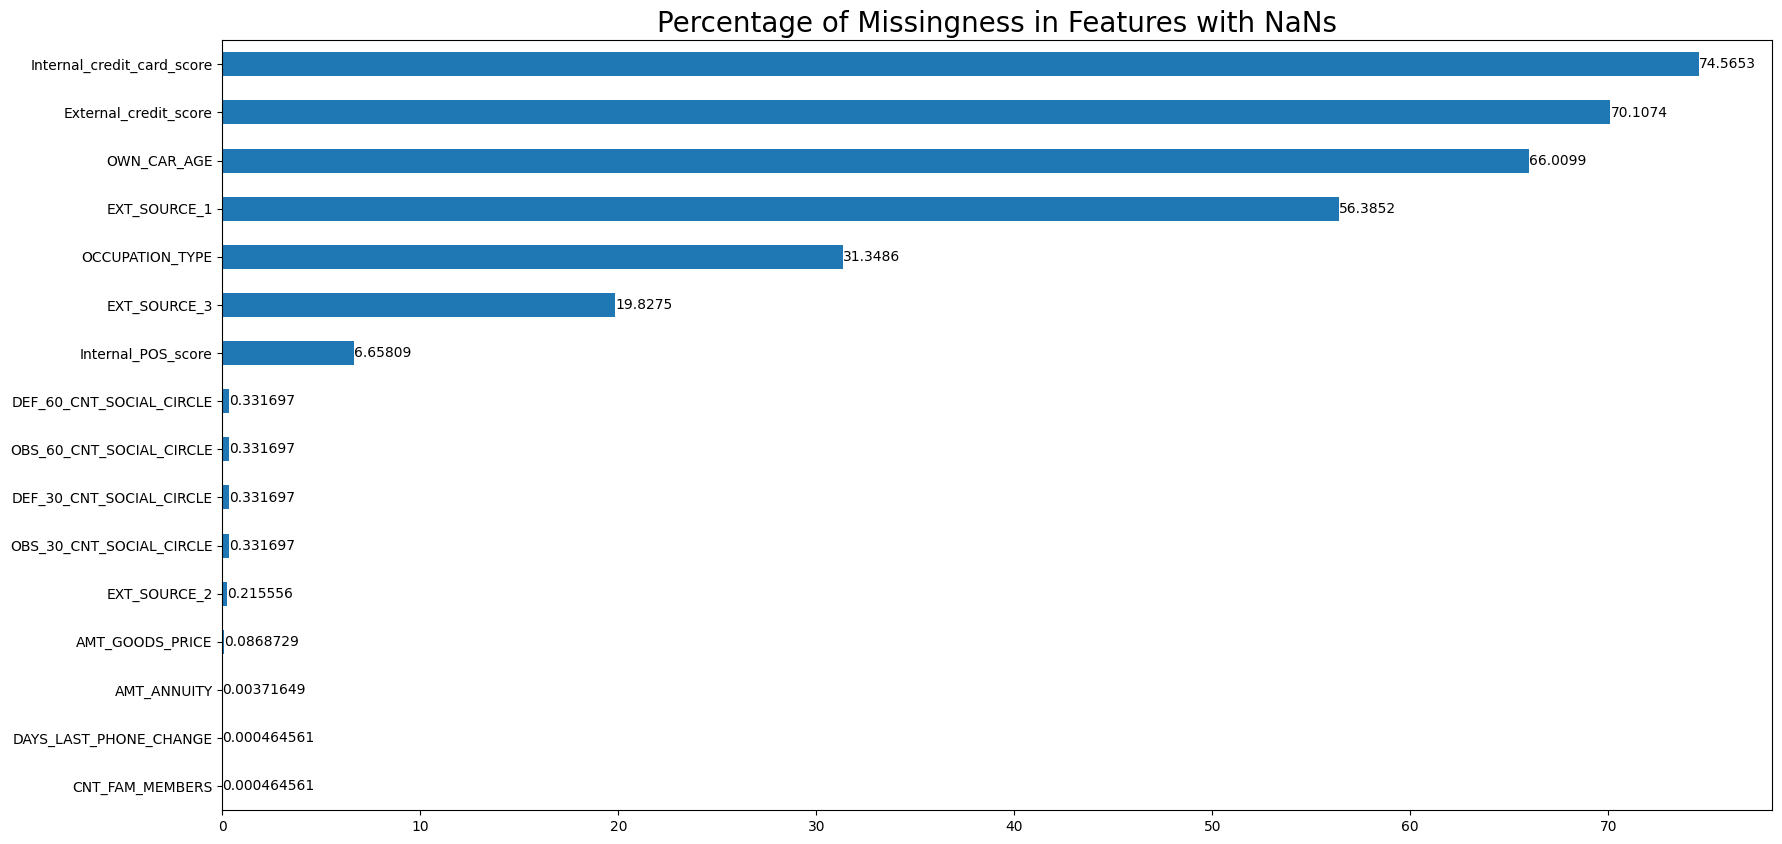

In [174]:
plt.figure(figsize=(20,10))
ax = (x_train.isnull().mean()[x_train.isnull().mean() != 0].sort_values() * 100 ).plot.barh()
plt.title('Percentage of Missingness in Features with NaNs',fontsize = 20)
ax.bar_label(ax.containers[0]);

In [175]:
missing_cols = x_train.isnull().mean()[x_train.isnull().mean() != 0].index.to_list()

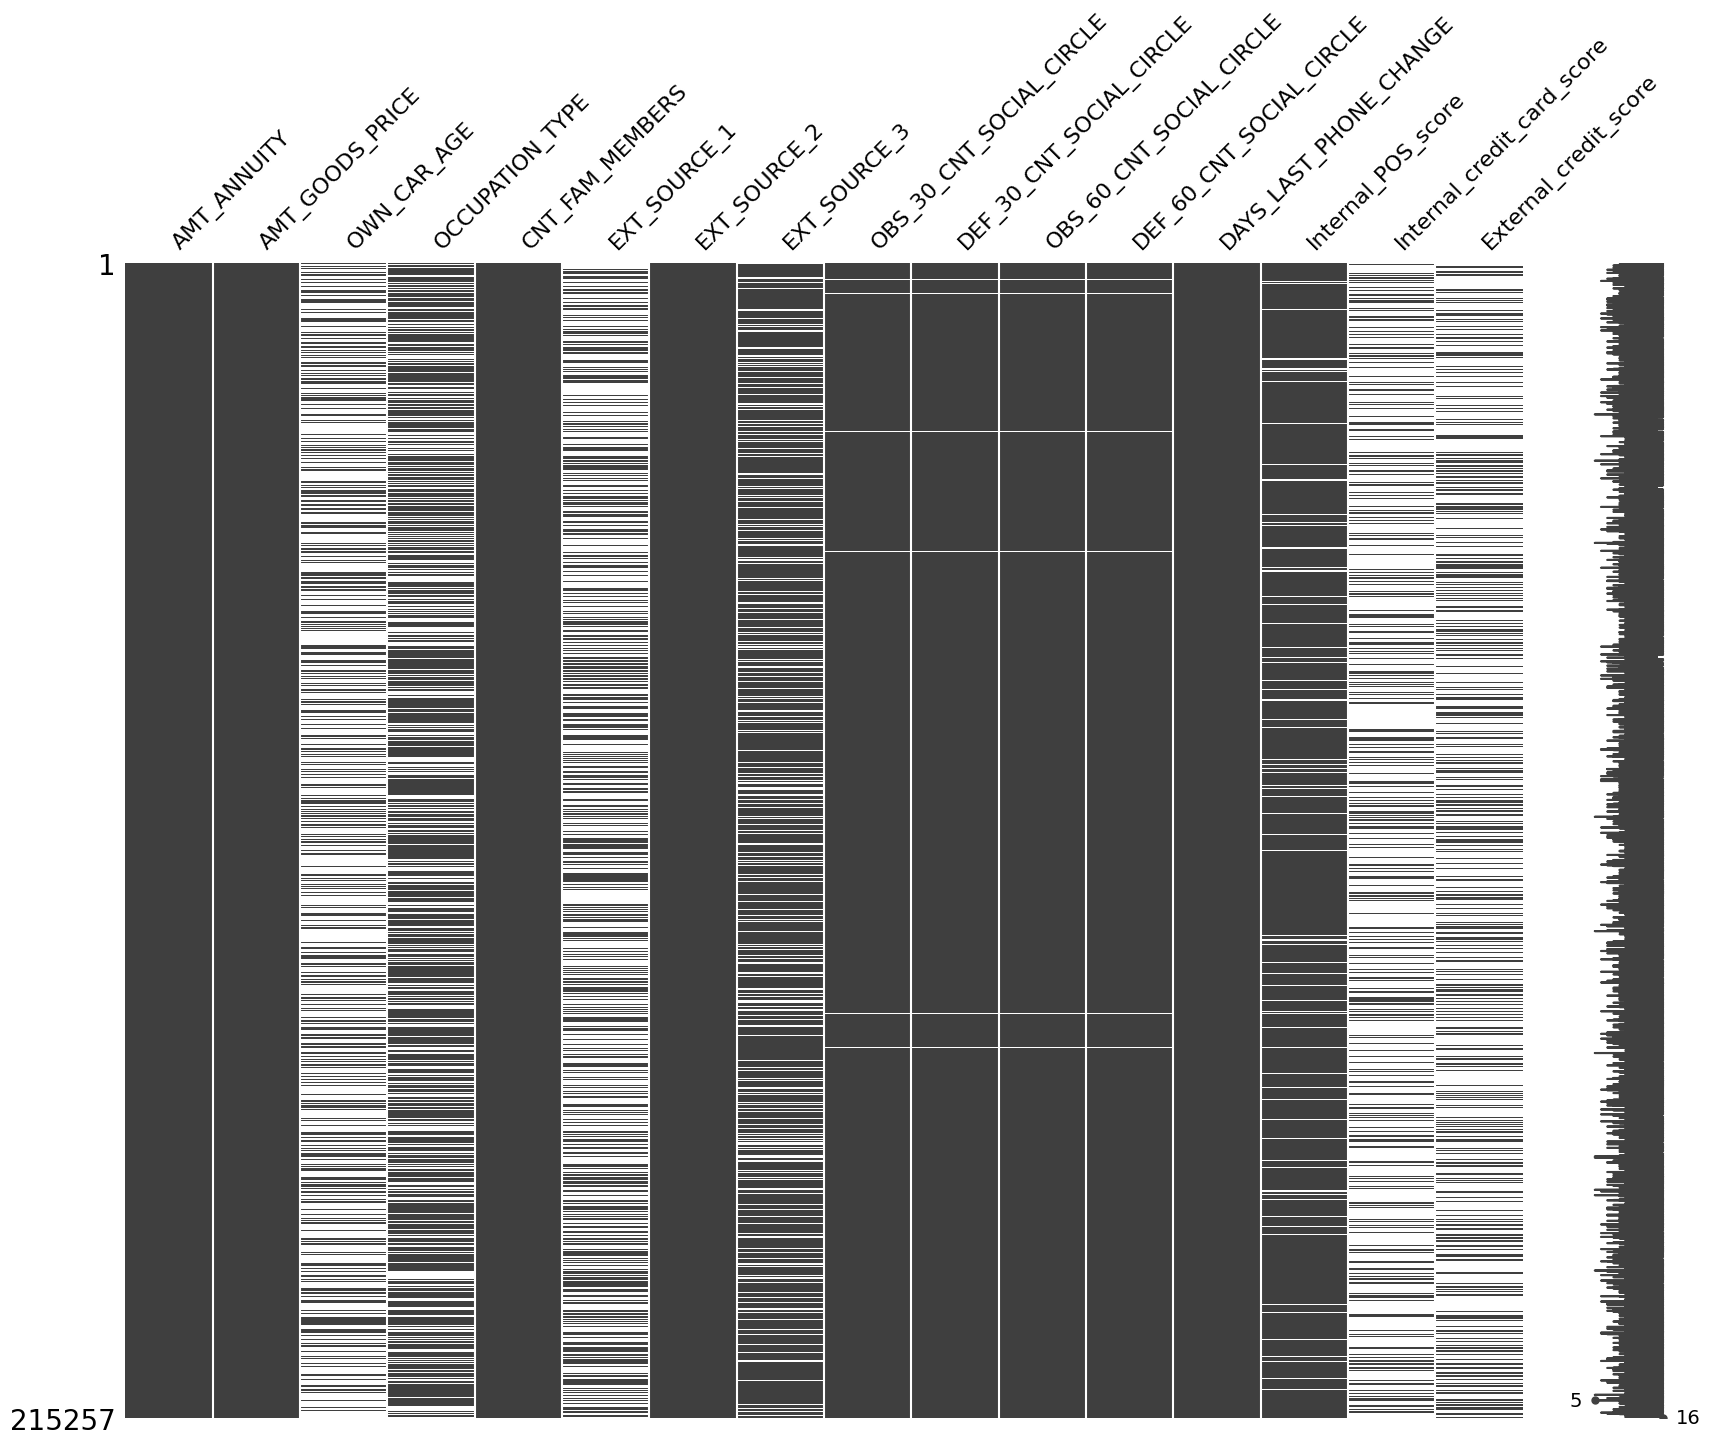

In [176]:
msno.matrix(x_train[missing_cols],figsize=(20,15));       

**Observations:** 
There seems to be a missingness pattern among OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE. Lets verify this and find out for other patterns (if any) with a correlation heatmap.

<Axes: >

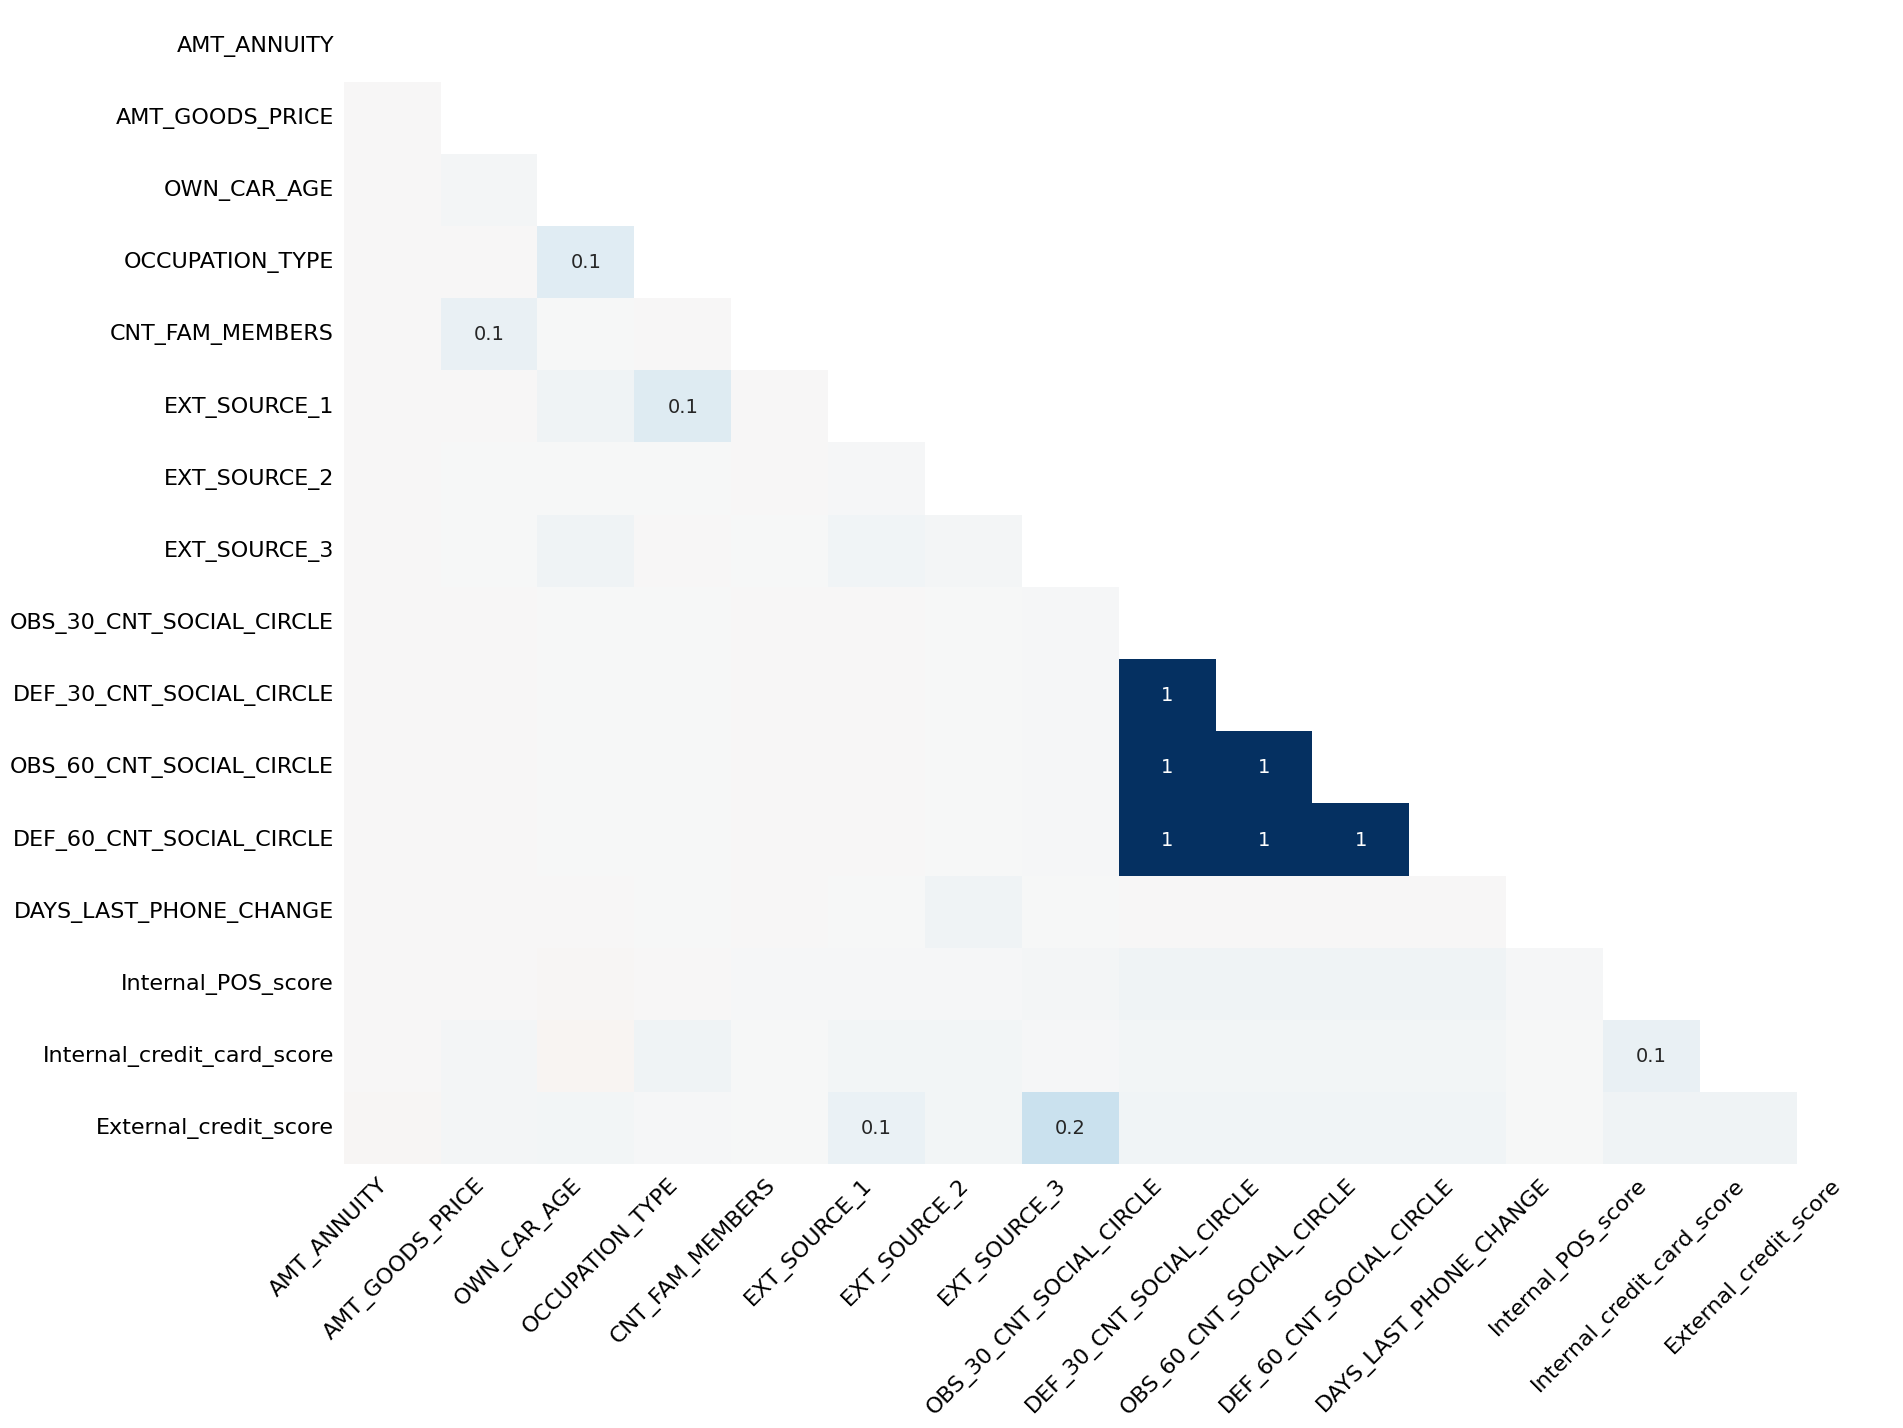

In [177]:
msno.heatmap(x_train,figsize=(20,15),cbar=False)         

**Observations:** A perfect correlation of 1 among 4 features reveals that there is an existence of missingness pattern among them.
    There is also a missingness pattern (correlation = 1) between CNT_FAM_MEMBERS and NAME_FAMILY_STATUS .

### 2. Imputing Missing Values

In [178]:
imp_mean = SimpleImputer(strategy="mean")

imp_median = SimpleImputer(strategy="median")

imp_mode = SimpleImputer(strategy="most_frequent")

In [179]:
cons_imputer_1 = SimpleImputer(fill_value=-1,strategy="constant",add_indicator=True)

cons_imputer_2 = SimpleImputer(fill_value=-1,strategy="constant",add_indicator=False)

In [180]:
x_train[['Internal_credit_card_score','miss_indicator_int_credit']] = cons_imputer_1.fit_transform(x_train[["Internal_credit_card_score"]])

x_train[['External_credit_score','miss_indicator_ext_credit']] = cons_imputer_1.fit_transform(x_train[["External_credit_score"]])

x_train[['Internal_POS_score','miss_indicator_pos_score']] = cons_imputer_1.fit_transform(x_train[['Internal_POS_score']])

x_train[['OWN_CAR_AGE','miss_indicator_car_age']] = cons_imputer_1.fit_transform(x_train[['OWN_CAR_AGE']])

In [181]:
x_test[['Internal_credit_card_score','miss_indicator_int_credit']] = cons_imputer_1.fit_transform(x_test[["Internal_credit_card_score"]])

x_test[['External_credit_score','miss_indicator_ext_credit']] = cons_imputer_1.fit_transform(x_test[["External_credit_score"]])

x_test[['Internal_POS_score','miss_indicator_pos_score']] = cons_imputer_1.fit_transform(x_test[['Internal_POS_score']])

x_test[['OWN_CAR_AGE','miss_indicator_car_age']] = cons_imputer_1.fit_transform(x_test[['OWN_CAR_AGE']])

In [182]:
x_train = x_train.astype({'miss_indicator_car_age':np.int8, 'miss_indicator_ext_credit': np.int8, 'miss_indicator_int_credit': np.int8,
               'miss_indicator_pos_score':np.int8})

x_test = x_test.astype({'miss_indicator_car_age':np.int8, 'miss_indicator_ext_credit': np.int8, 'miss_indicator_int_credit': np.int8,
               'miss_indicator_pos_score':np.int8})

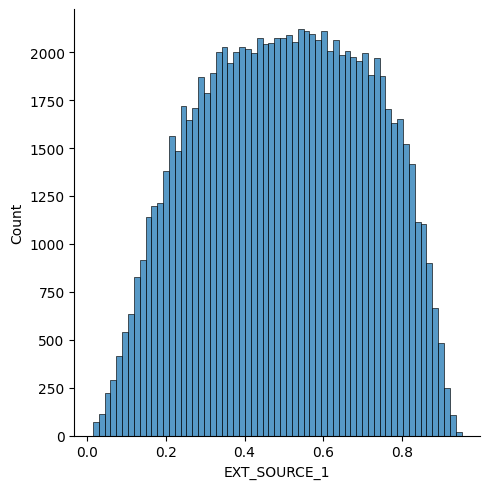

In [183]:
sns.displot(x_train["EXT_SOURCE_1"])

<Axes: >

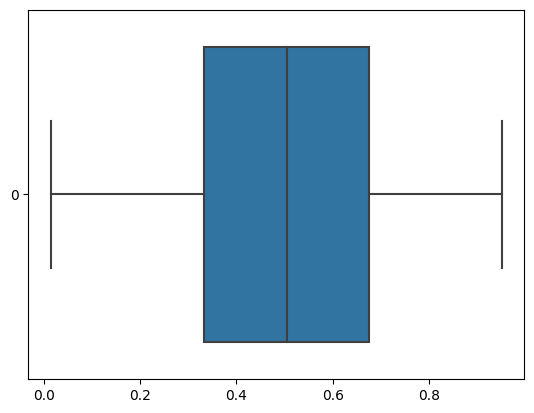

In [184]:
sns.boxplot(x_train["EXT_SOURCE_1"],orient = 'h')

In [185]:
x_train.EXT_SOURCE_1 = imp_mean.fit_transform(x_train[["EXT_SOURCE_1"]])

In [186]:
x_test.EXT_SOURCE_1 = imp_mean.transform(x_test[["EXT_SOURCE_1"]])

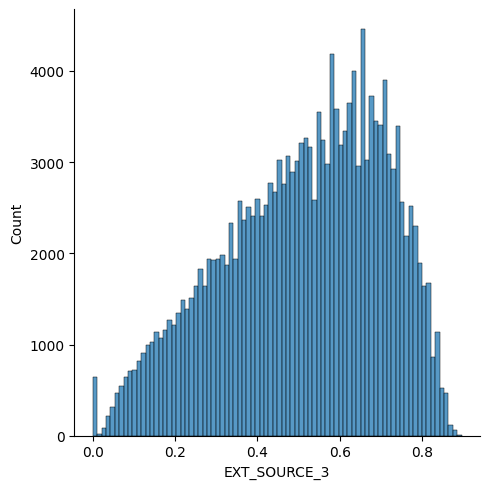

In [187]:
sns.displot(x_train["EXT_SOURCE_3"])

<Axes: >

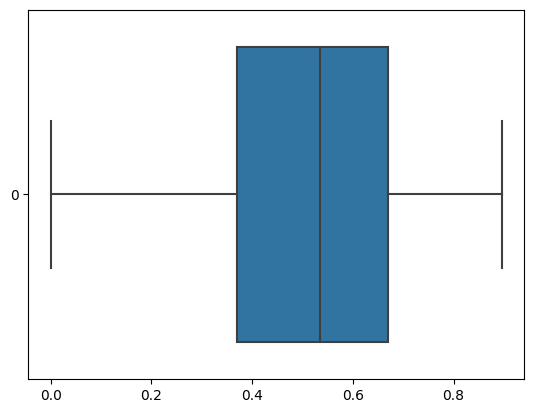

In [188]:
sns.boxplot(x_train["EXT_SOURCE_3"],orient = 'h')

In [189]:
x_train.EXT_SOURCE_3 = imp_median.fit_transform(x_train[["EXT_SOURCE_3"]])

In [190]:
x_test.EXT_SOURCE_3 = imp_median.transform(x_test[["EXT_SOURCE_3"]])

<Axes: xlabel='AMT_ANNUITY', ylabel='Density'>

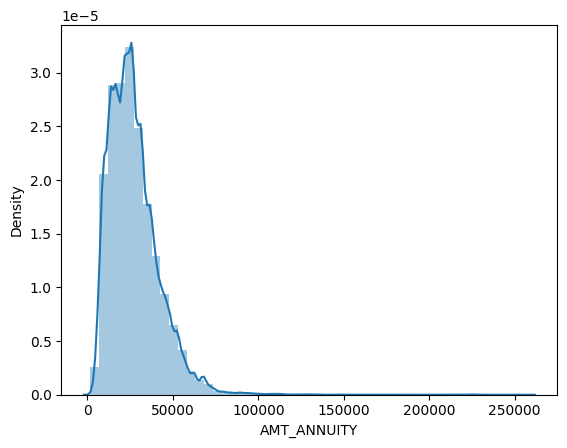

In [191]:
sns.distplot(x_train['AMT_ANNUITY'])

<Axes: >

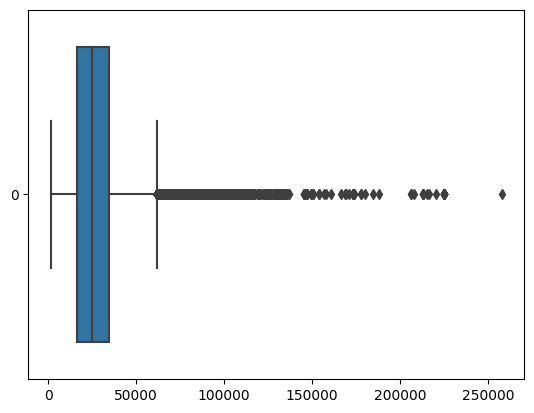

In [192]:
sns.boxplot(x_train['AMT_ANNUITY'],orient = 'h')

In [193]:
x_train.AMT_ANNUITY = imp_median.fit_transform(x_train[['AMT_ANNUITY']])

In [194]:
x_test.AMT_ANNUITY = imp_median.transform(x_test[['AMT_ANNUITY']])

<Axes: >

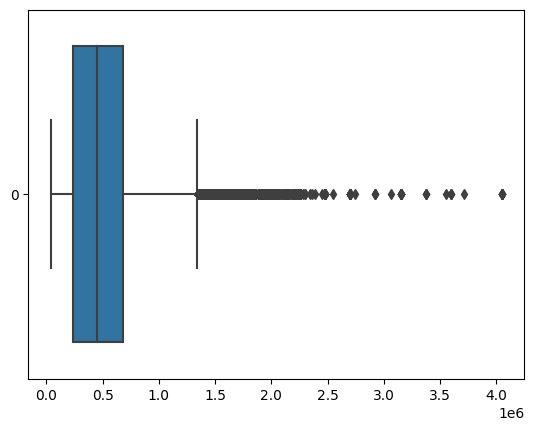

In [195]:
sns.boxplot(x_train['AMT_GOODS_PRICE'],orient= 'h')

<Axes: xlabel='AMT_GOODS_PRICE', ylabel='Count'>

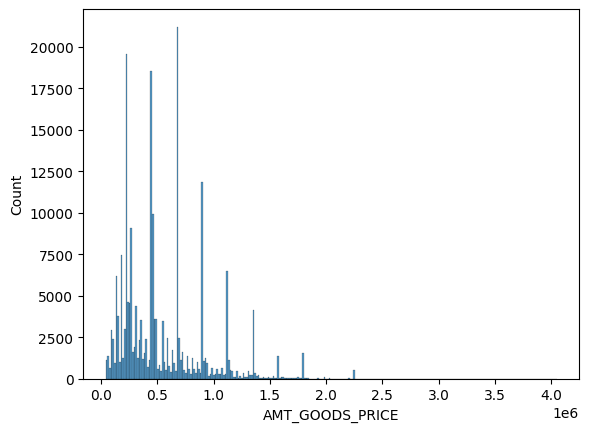

In [196]:
sns.histplot(x_train['AMT_GOODS_PRICE'])

In [197]:
x_train.AMT_GOODS_PRICE = imp_median.fit_transform(x_train[['AMT_GOODS_PRICE']])

In [198]:
x_test.AMT_GOODS_PRICE = imp_median.transform(x_test[['AMT_GOODS_PRICE']])

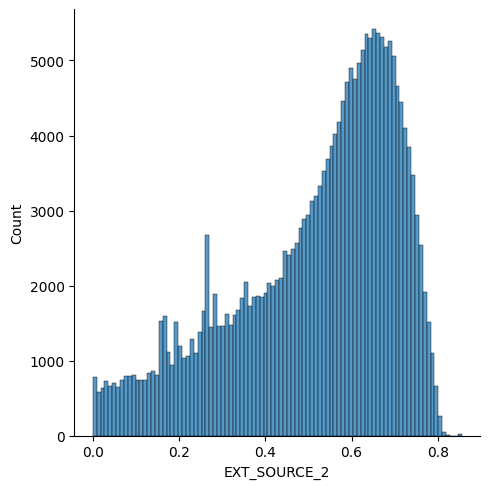

In [199]:
sns.displot(x_train["EXT_SOURCE_2"])

<Axes: >

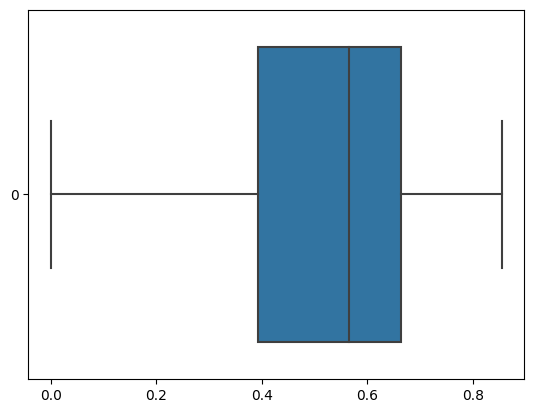

In [200]:
sns.boxplot(x_train["EXT_SOURCE_2"],orient = 'h')

In [201]:
x_train.EXT_SOURCE_2 = imp_median.fit_transform(x_train[["EXT_SOURCE_2"]])

In [202]:
x_test.EXT_SOURCE_2 = imp_median.fit_transform(x_test[["EXT_SOURCE_2"]])

In [203]:
x_train["OCCUPATION_TYPE"].unique()

['Accountants', 'Managers', 'Laborers', 'Sales staff', 'Drivers', ..., 'Cooking staff', 'Waiters/barmen staff', 'Low-skill Laborers', 'HR staff', 'Realty agents']
Length: 19
Categories (18, object): ['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', ..., 'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff']

In [204]:
mode_value = x_train['OCCUPATION_TYPE'].mode()[0]

In [205]:
x_train['OCCUPATION_TYPE'] = x_train['OCCUPATION_TYPE'].fillna(mode_value)

In [206]:
mode_value_1 = x_test['OCCUPATION_TYPE'].mode()[0]

In [207]:
x_test['OCCUPATION_TYPE'] = x_test['OCCUPATION_TYPE'].fillna(mode_value_1)

In [208]:
x_train["CNT_FAM_MEMBERS"].unique()

array([ 4.,  2.,  3.,  1.,  5.,  6., 10.,  7.,  8., 12.,  9., nan, 20.],
      dtype=float32)

In [209]:
x_train.CNT_FAM_MEMBERS = imp_mode.fit_transform(x_train[["CNT_FAM_MEMBERS"]])

In [210]:
x_test.CNT_FAM_MEMBERS = imp_mode.transform(x_test[["CNT_FAM_MEMBERS"]])

In [211]:
x_train["OBS_30_CNT_SOCIAL_CIRCLE"].unique()

array([  4.,   2.,   0.,   3.,   1.,   7.,   6.,   5.,  14.,  12.,   8.,
        10.,  nan,   9.,  11.,  15.,  13.,  25.,  16.,  17.,  23.,  27.,
        22.,  24.,  18.,  20., 348.,  21.,  19.,  29.,  30.,  47.,  28.],
      dtype=float32)

In [212]:
x_train["OBS_30_CNT_SOCIAL_CIRCLE"].mode()

0    0.0
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float32

In [213]:
x_train.OBS_30_CNT_SOCIAL_CIRCLE = cons_imputer_2.fit_transform(x_train[["OBS_30_CNT_SOCIAL_CIRCLE"]])

In [214]:
x_test.OBS_30_CNT_SOCIAL_CIRCLE = cons_imputer_2.fit_transform(x_test[["OBS_30_CNT_SOCIAL_CIRCLE"]])

In [215]:
x_train["OBS_60_CNT_SOCIAL_CIRCLE"].unique()

array([  4.,   2.,   0.,   3.,   1.,   7.,   5.,   6.,  14.,  12.,   8.,
        10.,  nan,   9.,  11.,  15.,  13.,  25.,  16.,  17.,  23.,  27.,
        22.,  21.,  24.,  18.,  19., 344.,  20.,  29.,  30.,  47.,  28.],
      dtype=float32)

In [216]:
x_train["OBS_60_CNT_SOCIAL_CIRCLE"].mode()

0    0.0
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float32

In [217]:
x_train.OBS_60_CNT_SOCIAL_CIRCLE = cons_imputer_2.fit_transform(x_train[["OBS_60_CNT_SOCIAL_CIRCLE"]])

In [218]:
x_test.OBS_60_CNT_SOCIAL_CIRCLE = cons_imputer_2.fit_transform(x_test[["OBS_60_CNT_SOCIAL_CIRCLE"]])

In [219]:
x_train["DEF_30_CNT_SOCIAL_CIRCLE"].unique()

array([ 0.,  1.,  2., nan,  3.,  4.,  6.,  5.,  8., 34.,  7.],
      dtype=float32)

In [220]:
x_train["DEF_30_CNT_SOCIAL_CIRCLE"].mode()

0    0.0
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float32

In [221]:
x_train.DEF_30_CNT_SOCIAL_CIRCLE = cons_imputer_2.fit_transform(x_train[["DEF_30_CNT_SOCIAL_CIRCLE"]])

In [222]:
x_test.DEF_30_CNT_SOCIAL_CIRCLE = cons_imputer_2.transform(x_test[["DEF_30_CNT_SOCIAL_CIRCLE"]])

In [223]:
x_train["DEF_60_CNT_SOCIAL_CIRCLE"].unique()

array([ 0.,  1.,  2., nan,  3.,  4.,  6., 24.,  5.,  7.], dtype=float32)

In [224]:
x_train["DEF_60_CNT_SOCIAL_CIRCLE"].mode()

0    0.0
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float32

In [225]:
x_train[['DEF_60_CNT_SOCIAL_CIRCLE','miss_indicator_def_60']] = cons_imputer_1.fit_transform(x_train[["DEF_60_CNT_SOCIAL_CIRCLE"]])

In [226]:
x_test[['DEF_60_CNT_SOCIAL_CIRCLE','miss_indicator_def_60']] = cons_imputer_1.transform(x_test[["DEF_60_CNT_SOCIAL_CIRCLE"]])

In [227]:
print('Number of missing values in train data:',x_train.isna().sum().sum())
print('Number of missing values in test data:',x_test.isna().sum().sum())

Number of missing values in train data: 1
Number of missing values in test data: 0


**Observations:**

- When imputing missing values, we visualized the data distribution and created box plots for each feature with missing values.
- We assessed whether the data was normally distributed, showed left/right skewness, or contained outliers.
- For normally distributed data without outliers, we imputed missing values using the mean.
- For data showing skewness or containing outliers, we used the median for imputation.
- For categorical features, we employed the mode for imputation.
- In cases where missing values were not random, such as credit scores and car information, we avoided mean/median/mode imputation as it wouldn't be appropriate.
- Instead, we used the constant strategy with a missing indicator to handle these specific records.

## EDA

## Univariate Analysis 

In [228]:
x_train.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
159703       0         Cash loans           F            Y               Y   
79269        0         Cash loans           M            N               Y   
232615       0         Cash loans           M            N               Y   
33420        0         Cash loans           F            N               Y   
88191        0         Cash loans           M            Y               N   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
159703             2          405000.0   1971072.0      68643.0   
79269              0          337500.0    508495.5      38146.5   
232615             1          112500.0    110146.5      13068.0   
33420              2           40500.0     66384.0       3519.0   
88191              0          225000.0    298512.0      31801.5   

        AMT_GOODS_PRICE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
159703        1800000.0  Commercial associate               Higher education   
79269          454500.0         State servant               Higher education   
232615          90000.0  Commercial associate  Secondary / secondary special   
33420           45000.0  Commercial associate  Secondary / secondary special   
88191          270000.0  Commercial associate  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
159703            Married  House / apartment                    0.006852   
79269             Married  House / apartment                    0.010276   
232615            Married  House / apartment                    0.005084   
33420             Married  House / apartment                    0.031329   
88191             Married  House / apartment                    0.019101   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
159703      -13587          -1028            -7460.0            -1823   
79269       -17543          -1208            -4054.0            -1090   
232615      -11557           -593            -5554.0            -4130   
33420       -15750          -5376            -5285.0            -5290   
88191       -19912          -1195              -86.0            -3033   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
159703         13.0           1               1                0   
79269          -1.0           1               1                0   
232615         -1.0           1               1                0   
33420          -1.0           1               1                0   
88191          11.0           1               1                0   

        FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
159703                 1           0           0     Accountants   
79269                  1           0           0        Managers   
232615                 1           1           1        Laborers   
33420                  1           0           0     Sales staff   
88191                  1           0           0         Drivers   

        CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
159703              4.0                     3                            3   
79269               2.0                     2                            2   
232615              3.0                     2                            2   
33420               4.0                     2                            2   
88191               2.0                     2                            2   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
159703                           0                           0   
79269                            0                           0   
232615                           0                           0   
33420                            0                           0   
88191                            0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
159703      

In [229]:
report = sv.analyze(x_train,target_feat="TARGET")
report.show_html()

Done! Use 'show' commands to display/save.   |█████████████████████████████████████████| [100%]   00:10 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Visualizations of some features in sweetviz were not clear enough to derive insights.Separate visualizations are created 
for the features (CNT_CHILDREN, CNT_FAM_MEMBERS, ORGANIZATION_TYPE, DAYS_EMPLOYED, OBS_30_CNT_SOCIAL_CIRCLE,
OBS_60_CNT_SOCIAL_CIRCLE) as follows.**

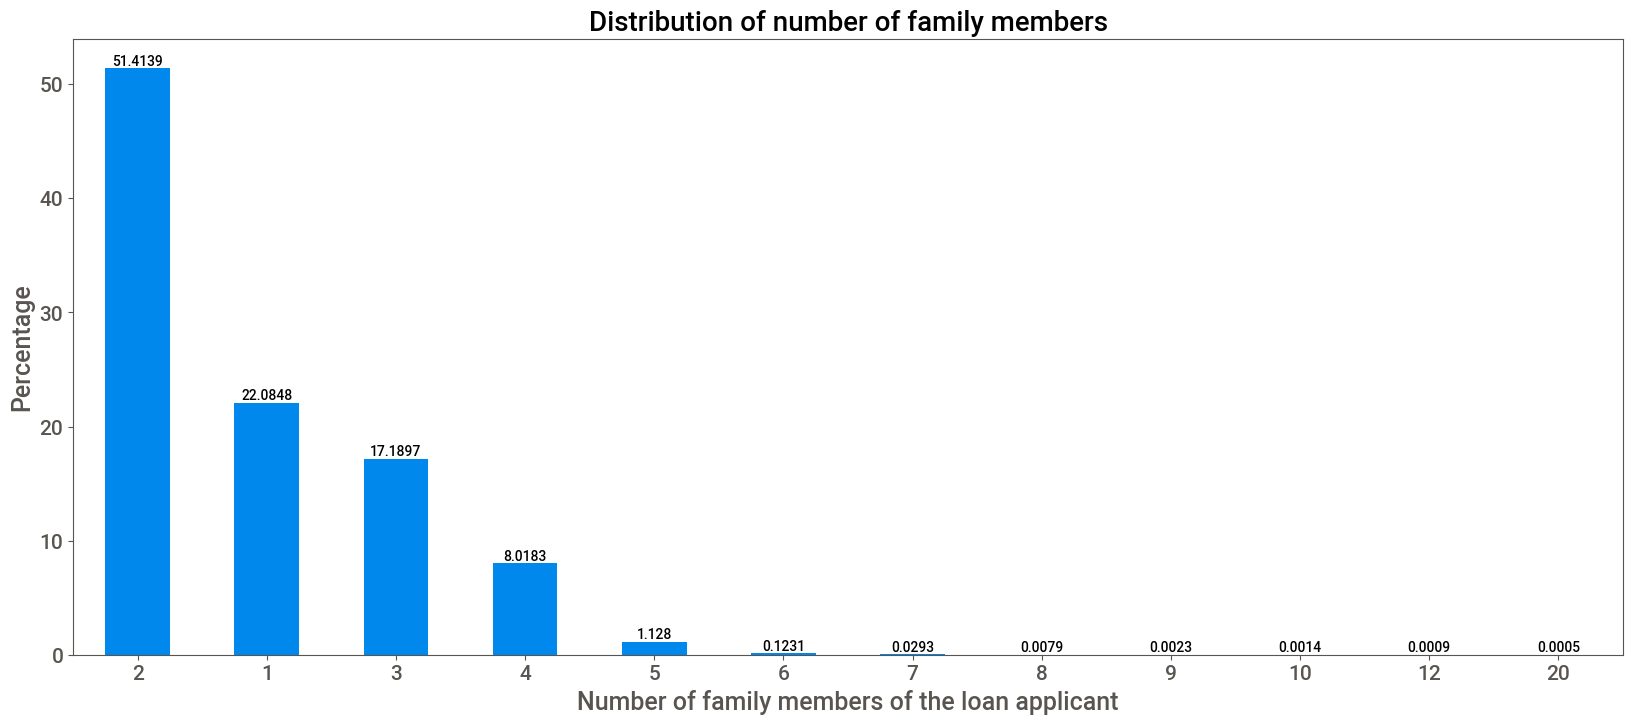

In [230]:
plt.figure(figsize=(20,8))

ax = x_train.CNT_FAM_MEMBERS.dropna().astype('int').value_counts(normalize=True).mul(100).round(4).plot.bar()

plt.xticks(rotation = 0, fontsize =15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of family members of the loan applicant',fontsize = 18)
plt.ylabel('Percentage',fontsize = 18)
plt.title('Distribution of number of family members',fontsize = 20)

ax.bar_label(ax.containers[0]);

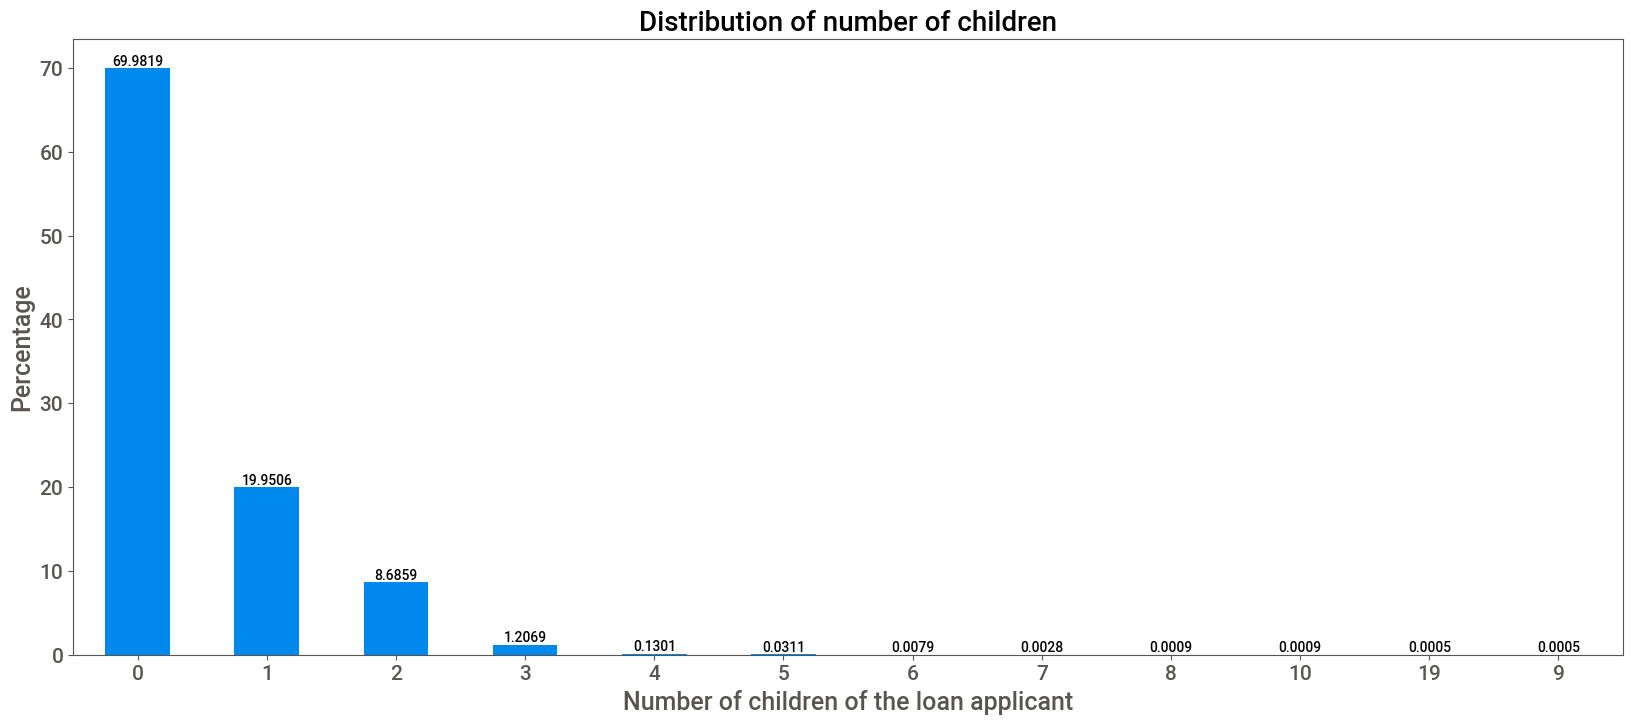

In [231]:
plt.figure(figsize=(20,8))

ax = x_train.CNT_CHILDREN.value_counts(normalize = True).mul(100).round(4).plot.bar()

plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of children of the loan applicant',fontsize = 18)
plt.ylabel('Percentage',fontsize = 18)
plt.title('Distribution of number of children',fontsize= 20);

ax.bar_label(ax.containers[0]);


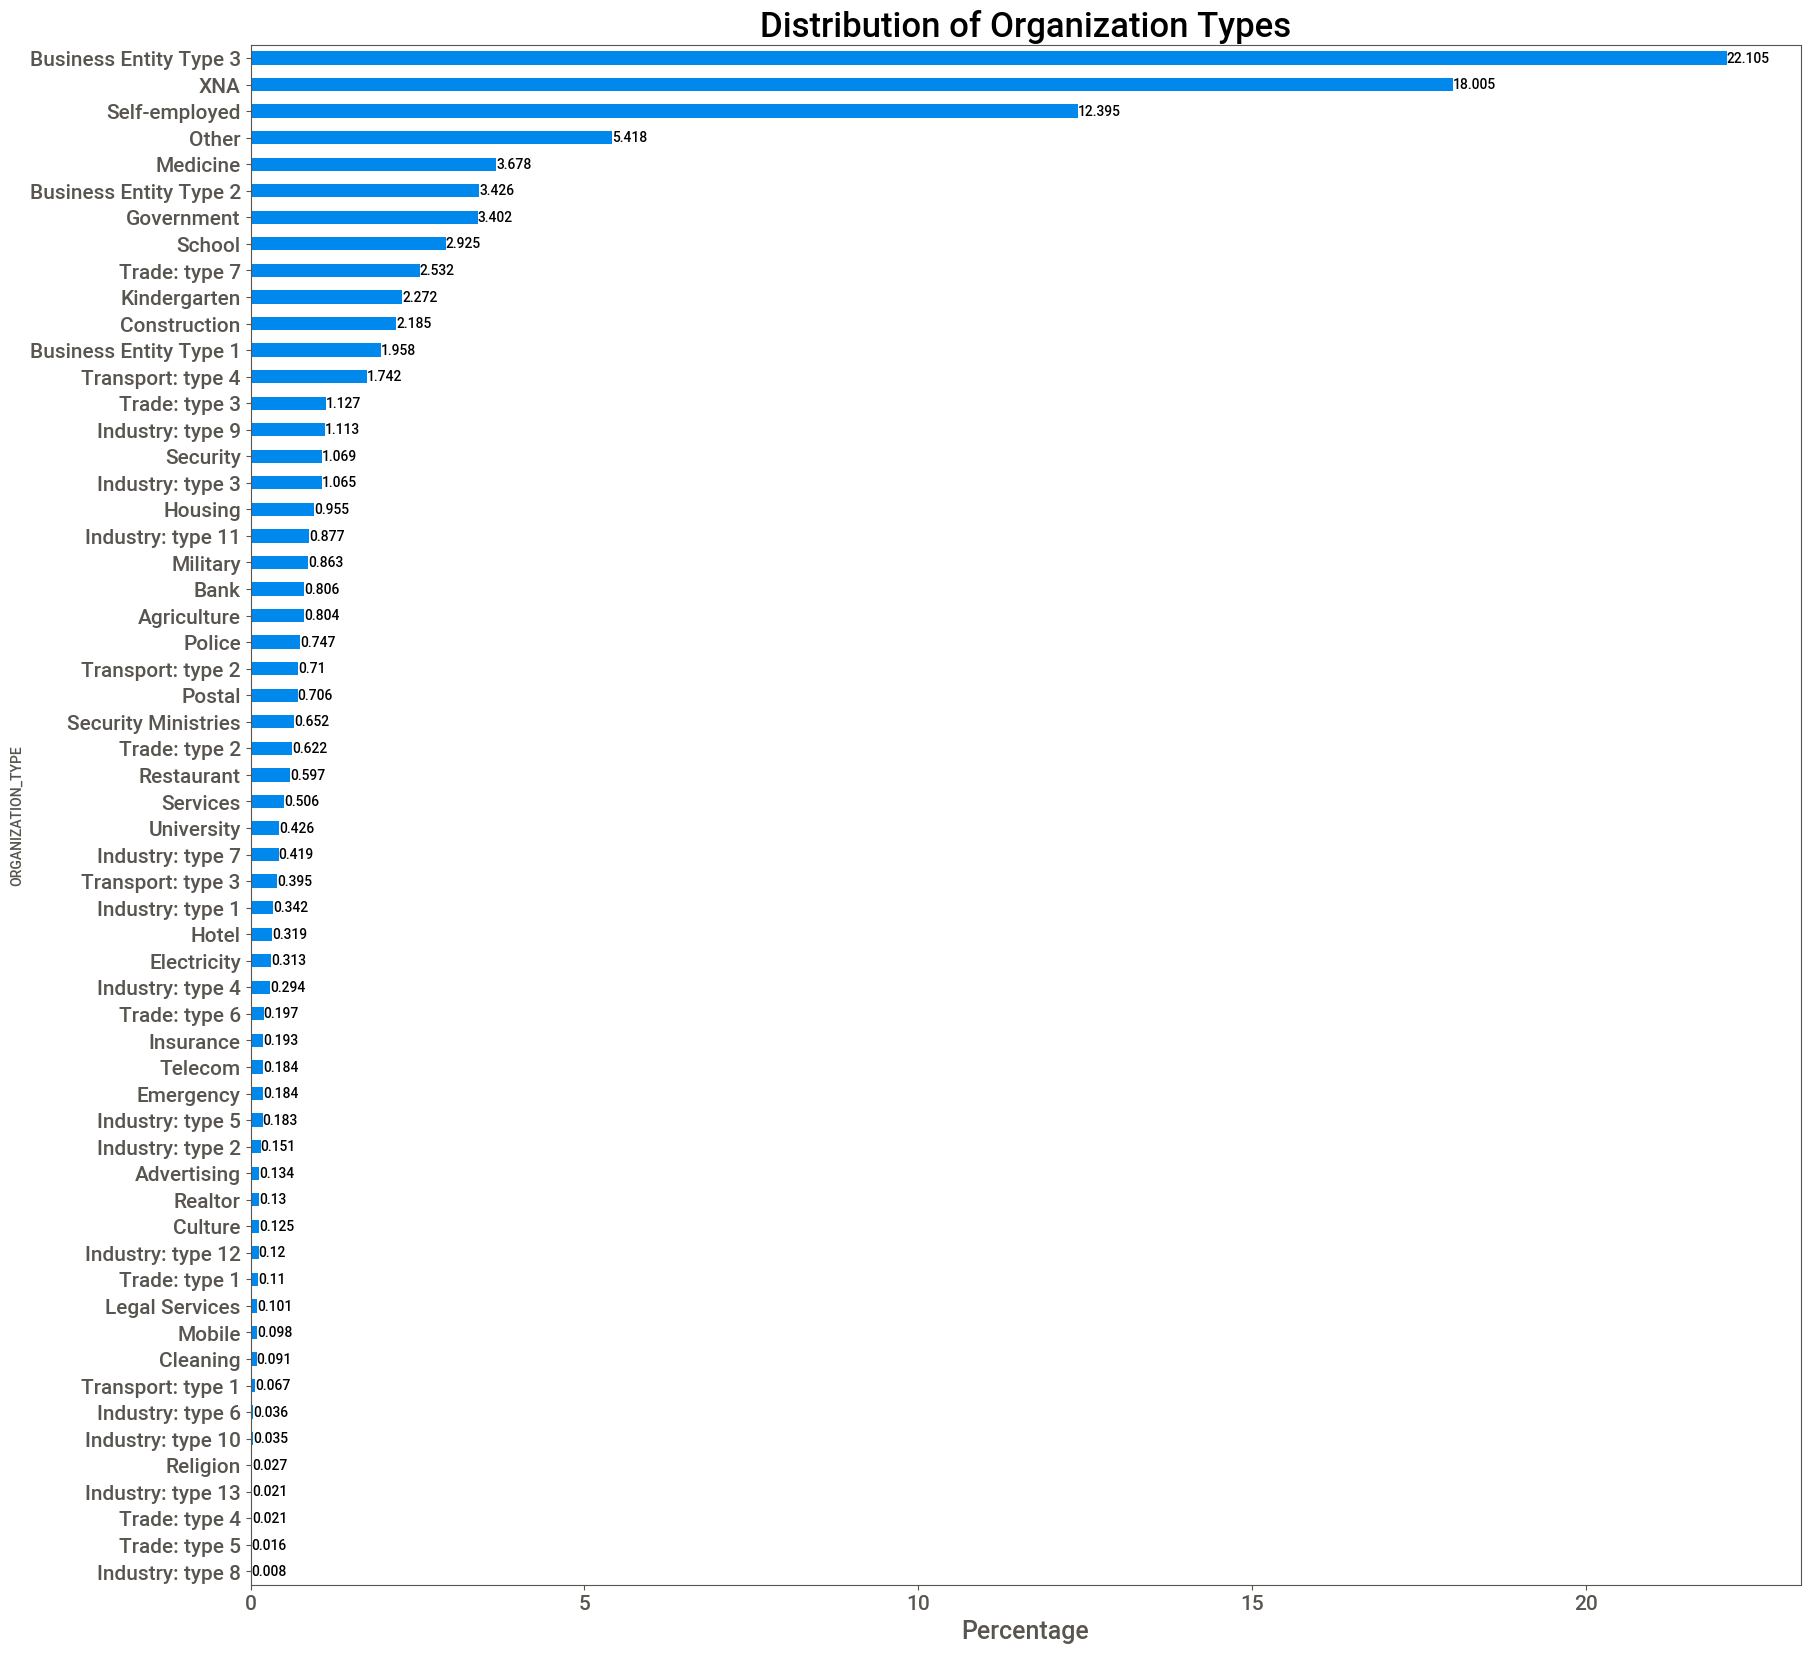

In [232]:
plt.figure(figsize=(20,20))

ax = x_train.ORGANIZATION_TYPE.value_counts(normalize = True).sort_values().mul(100).round(3).plot.barh(width = 0.5)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Percentage',fontsize = 18)
plt.title('Distribution of Organization Types',fontsize =25)

ax.bar_label(ax.containers[0]);


Text(0, 0.5, 'Frequency')

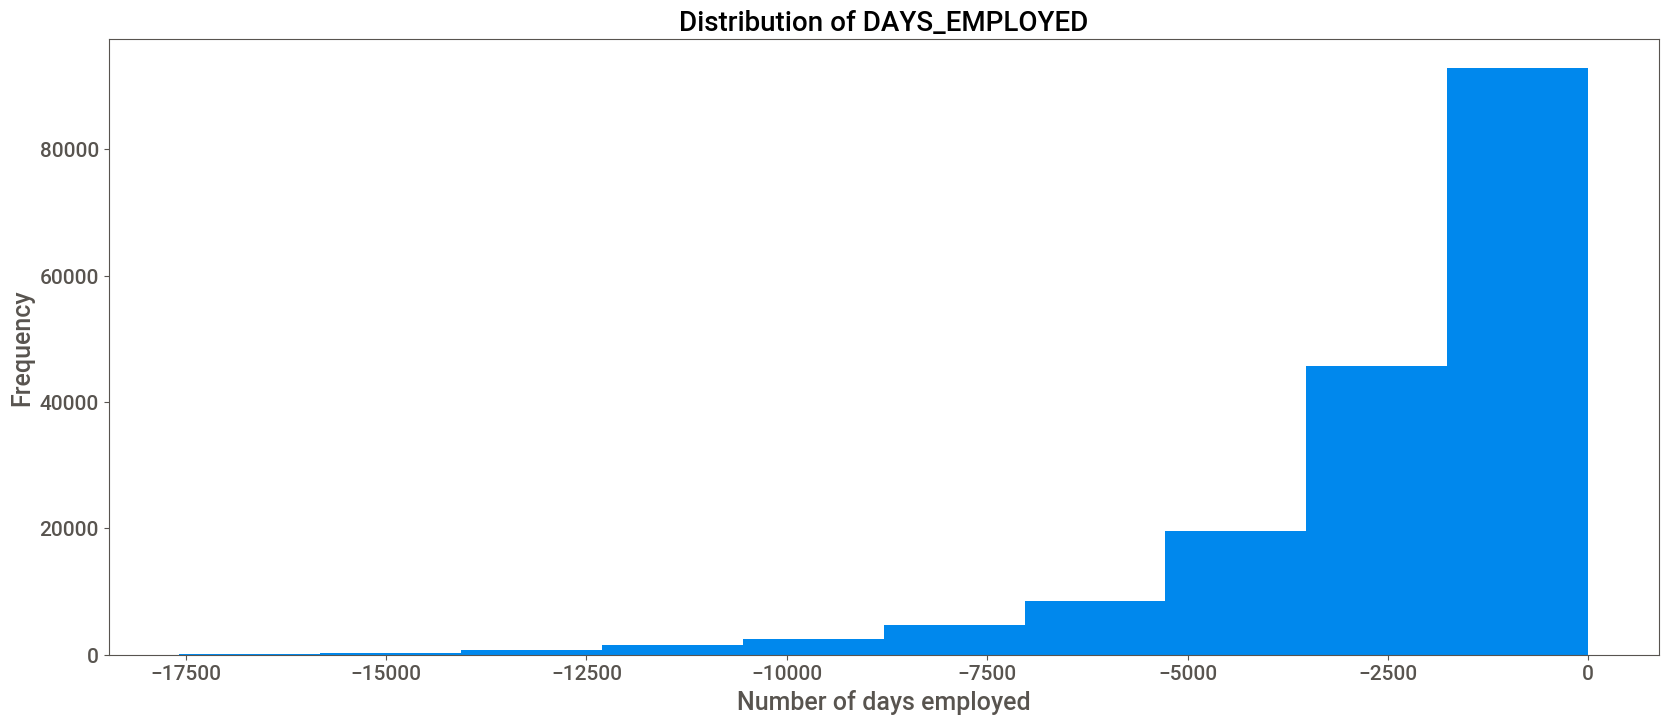

In [233]:
plt.figure(figsize=(20,8))

x_train.DAYS_EMPLOYED.replace(365243,np.nan).dropna().plot.hist()

plt.title('Distribution of DAYS_EMPLOYED',fontsize =20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of days employed',fontsize = 18)
plt.ylabel('Frequency',fontsize = 18)

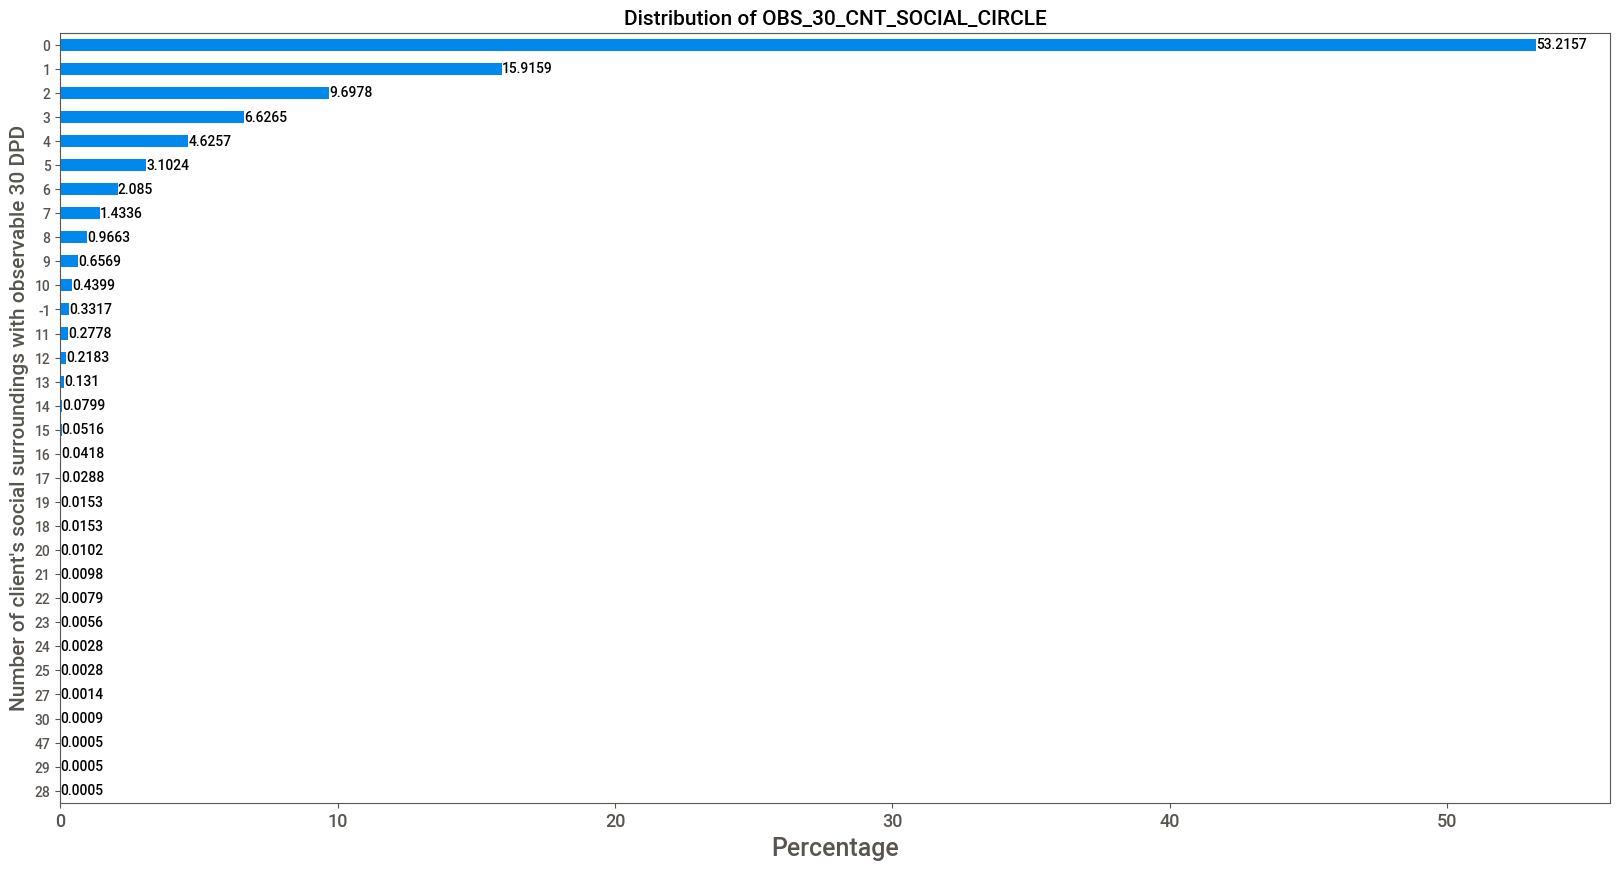

In [234]:
plt.figure(figsize=(20,10))

ax = x_train.OBS_30_CNT_SOCIAL_CIRCLE.replace(348,np.nan).dropna().astype('int').value_counts(normalize = True).sort_values().mul(100).round(4).plot.barh()

plt.title('Distribution of OBS_30_CNT_SOCIAL_CIRCLE',fontsize = 15);
plt.xticks(rotation = 0,fontsize = 13)
plt.yticks(fontsize = 10)
plt.ylabel("Number of client's social surroundings with observable 30 DPD",fontsize = 15)
plt.xlabel("Percentage",fontsize = 18)

ax.bar_label(ax.containers[0]);

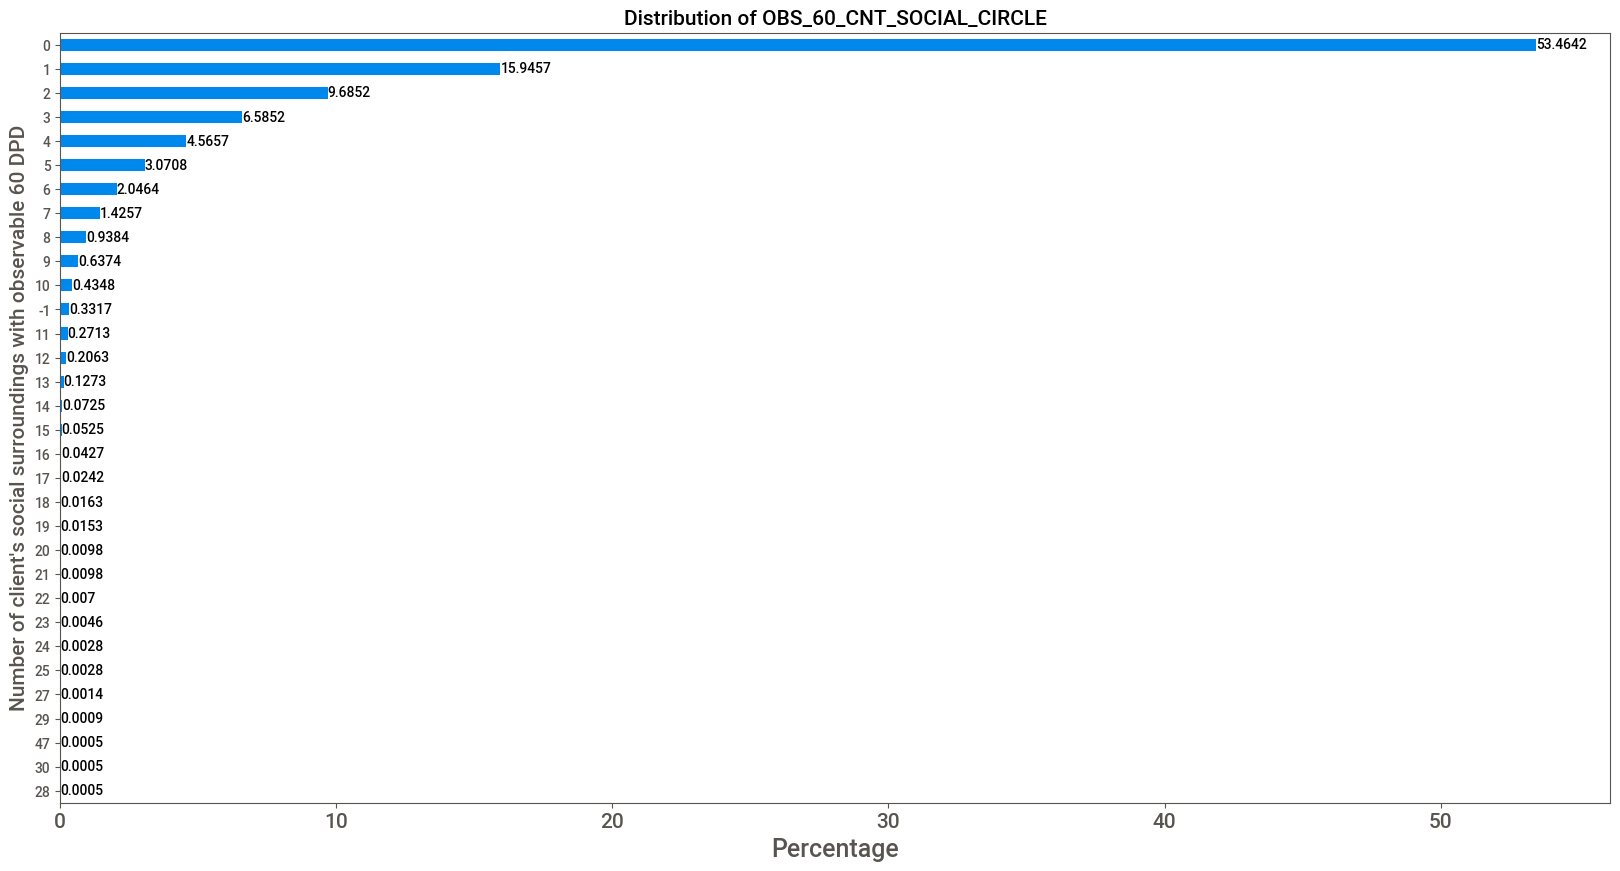

In [235]:
plt.figure(figsize=(20,10))

ax = x_train.OBS_60_CNT_SOCIAL_CIRCLE.replace(344,np.nan).dropna().astype('int').value_counts(normalize = True).sort_values().mul(100).round(4).plot.barh()

plt.title('Distribution of OBS_60_CNT_SOCIAL_CIRCLE',fontsize = 15);
plt.xticks(rotation = 0,fontsize = 15)
plt.yticks(fontsize = 10)
plt.ylabel("Number of client's social surroundings with observable 60 DPD",fontsize = 15)
plt.xlabel("Percentage",fontsize = 18)

ax.bar_label(ax.containers[0]);

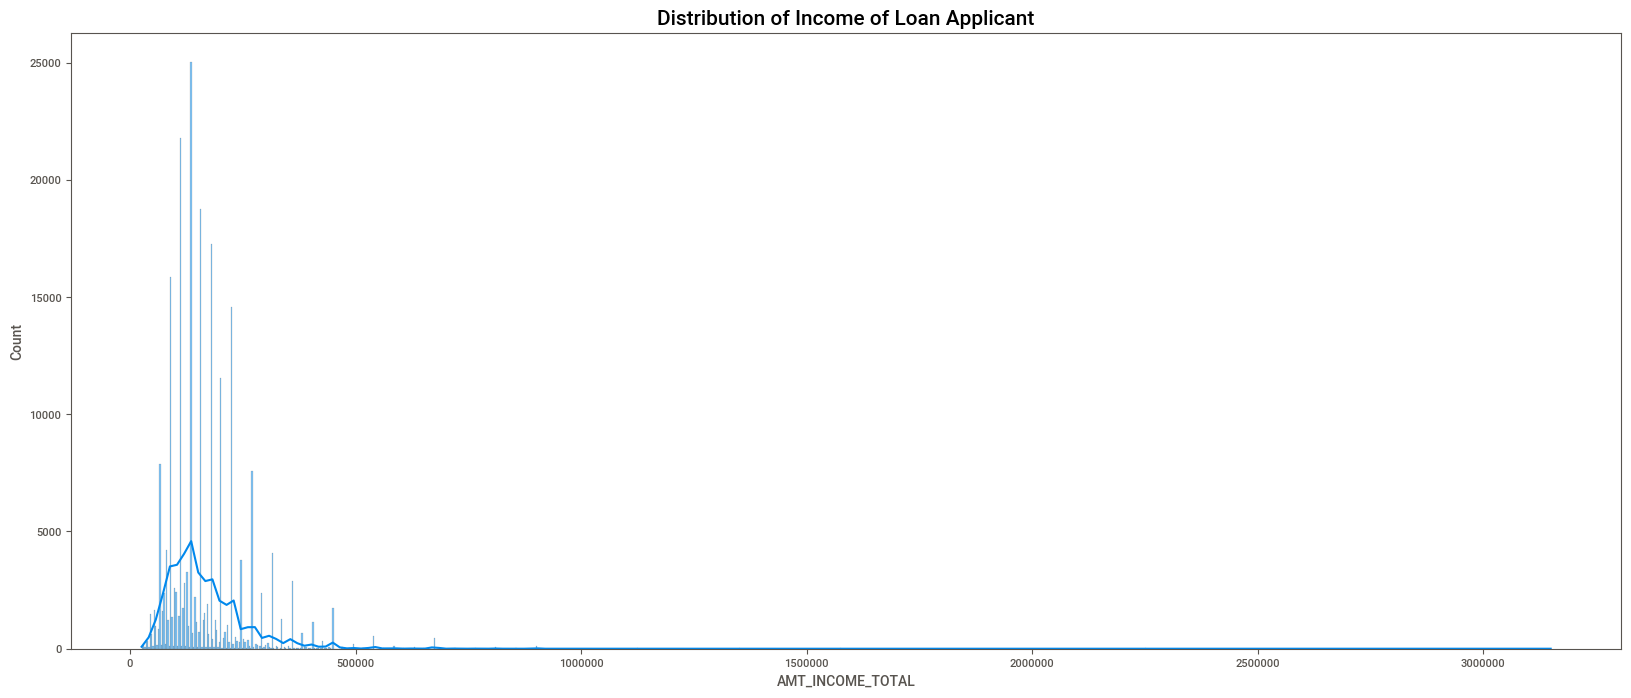

In [236]:
plt.figure(figsize=(20,8))

sns.histplot(x = 'AMT_INCOME_TOTAL', data = x_train.sort_values('AMT_INCOME_TOTAL')[:-10],kde= True)

plt.title('Distribution of Income of Loan Applicant',fontsize = 15);
plt.xticks(rotation = 0);

## Insights from Univariate EDA

**CNT_CHILDREN** - Most of the applicants (around 99%) have less than 3 children. There is one applicant that has 19 children.

**REGION_POPULATION_RELATIVE** - There is a discontinuity in the distribution. There is no applicant living in densities between 
                             0.036 and 0.046, 0.05 and 0.065. There are people living in more congested areas (>0.065).
    
**DAYS_BIRTH** - Applicants are as young as 21 years and old as 69 years.

**ORGANIZATION_TYPE** - Feature with highest cardinality (58).XNA is a category (for most Pensioners and all Unemployed people).

**DAYS_EMPLOYED**  - There are a lot of loan applicants with a high positive value (365243 for most of the pensioners and all      unemployed people)

From most of the **FLAG_DOCUMENT** based features, around 99% people have NOT submitted the documents

**FLAG_DOCUMENT_3** - This is the only FLAG_DOC based feature that has more 1s than 0s implying that people who have submitted the documents exceed the number of applicants who haven't submitted them.

**FLAG_MOBIL** - There is only one applicant who did not provide mobile number.

**FLAG_EMAIL** - Most of them haven't provided the email.

**OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE** - A very large number in each of these four features (348, 344, 34, 24 respectively)


In [237]:
x_train = x_train.drop(columns=["FLAG_MOBIL",'FLAG_DOCUMENT_12','DAYS_LAST_PHONE_CHANGE','FLAG_OWN_CAR'])

In [238]:
x_test = x_test.drop(columns=["FLAG_MOBIL",'FLAG_DOCUMENT_12','DAYS_LAST_PHONE_CHANGE','FLAG_OWN_CAR'])

## Bivariate EDA

### Bivariate Analysis with TARGET

In [239]:
few_n_unique_columns = x_train.nunique()[x_train.nunique() <= 10].index.to_list()

few_n_unique_columns.remove('TARGET')

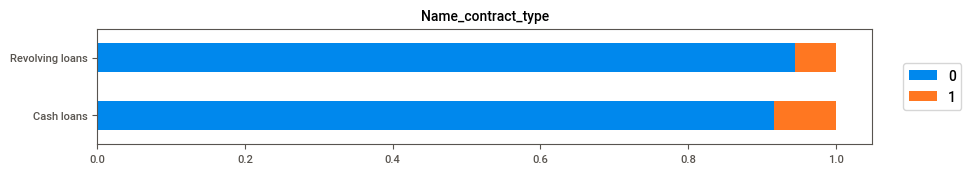

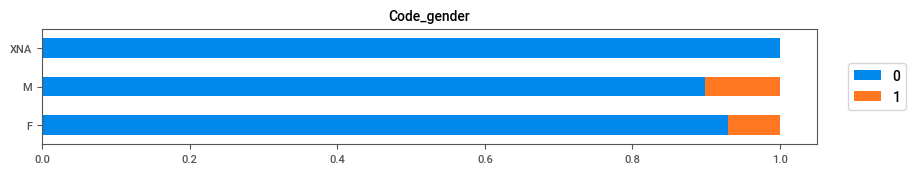

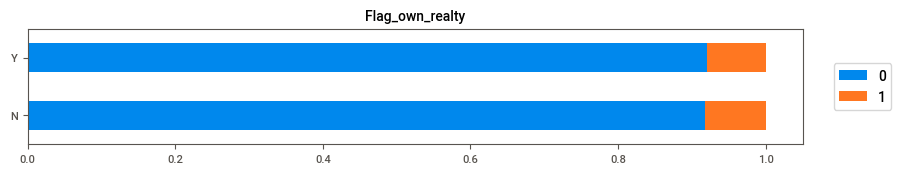

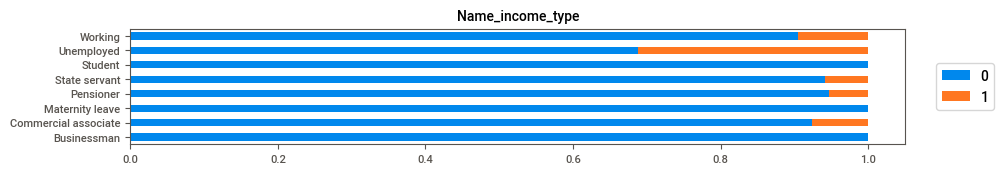

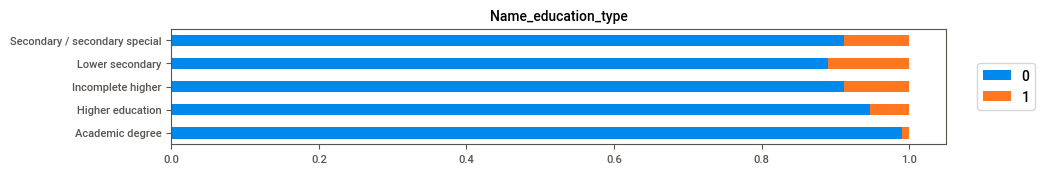

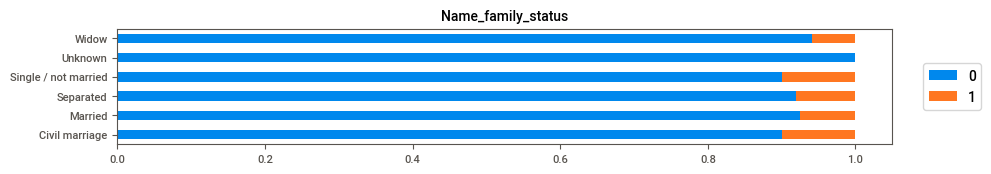

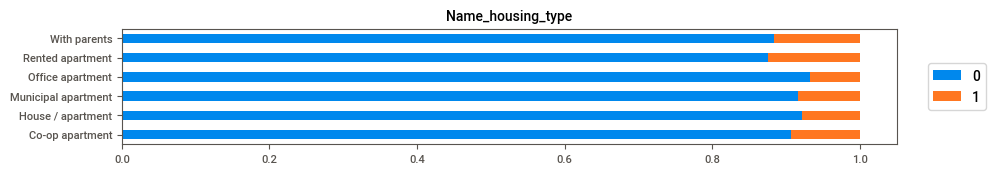

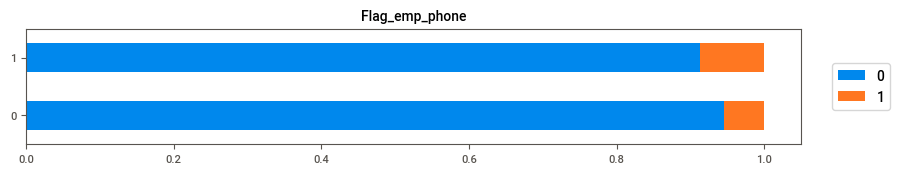

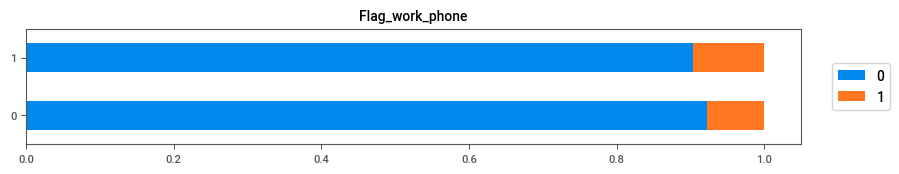

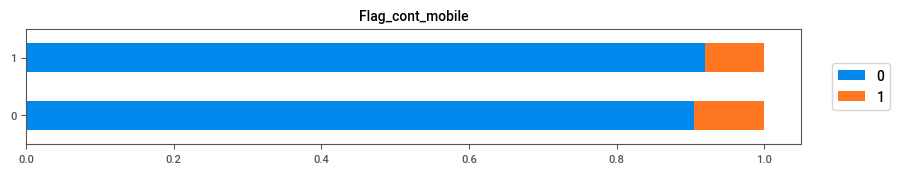

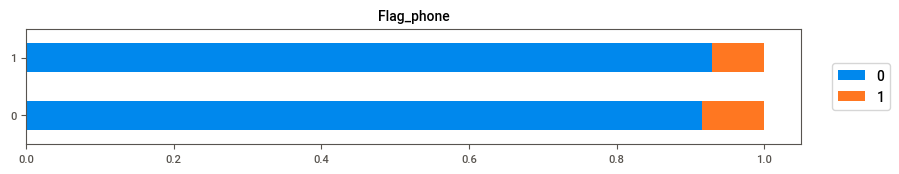

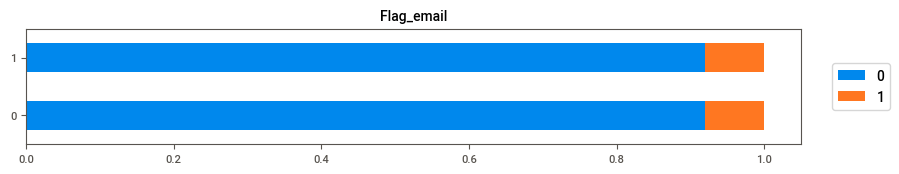

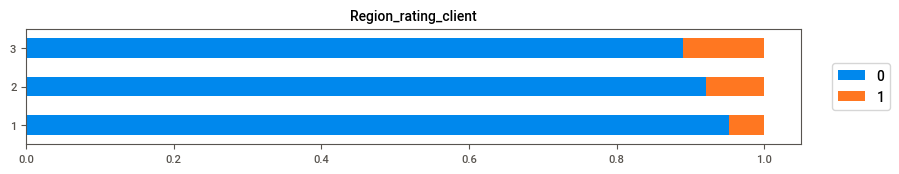

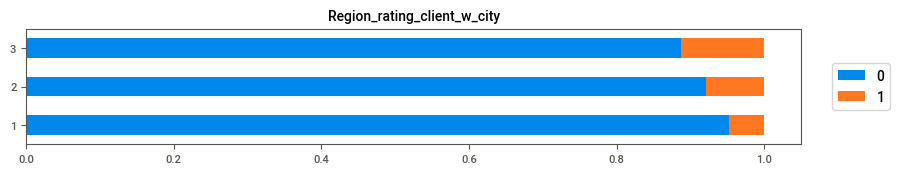

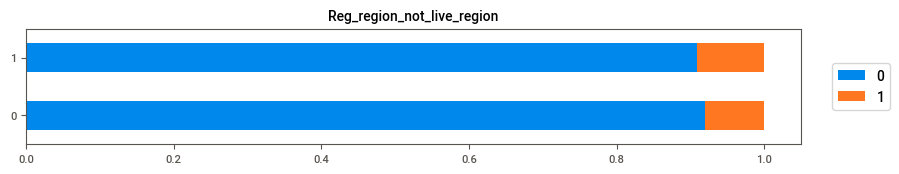

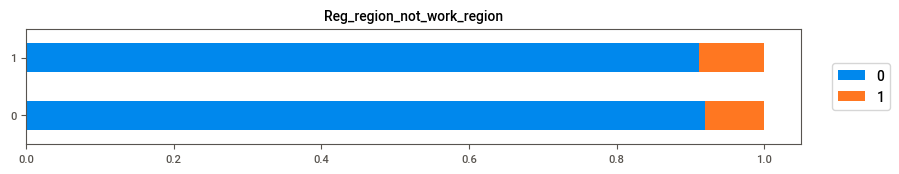

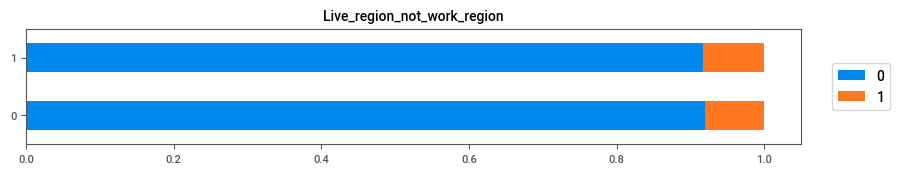

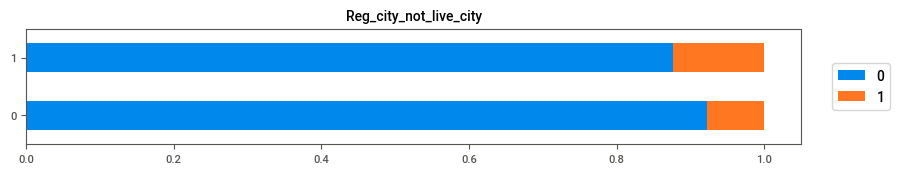

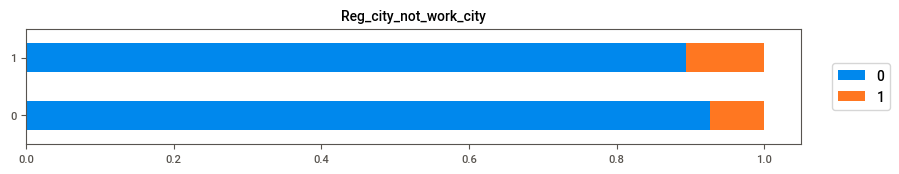

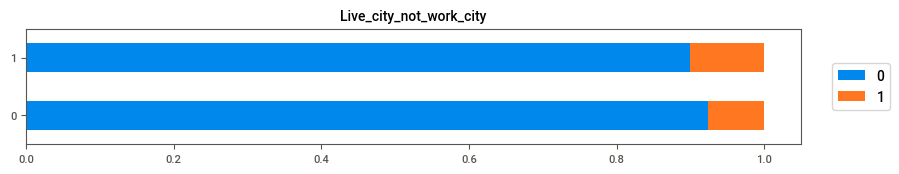

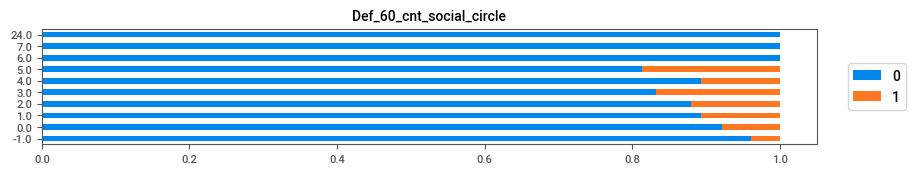

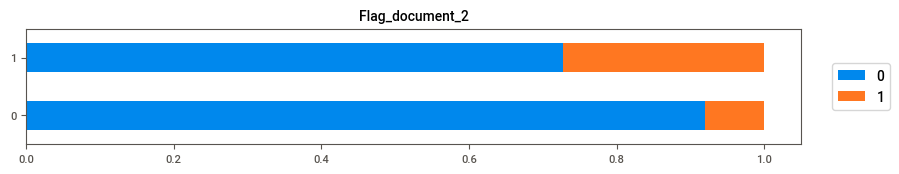

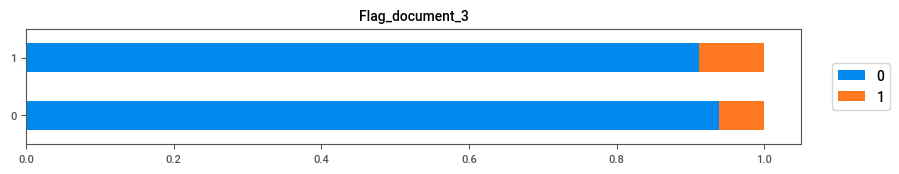

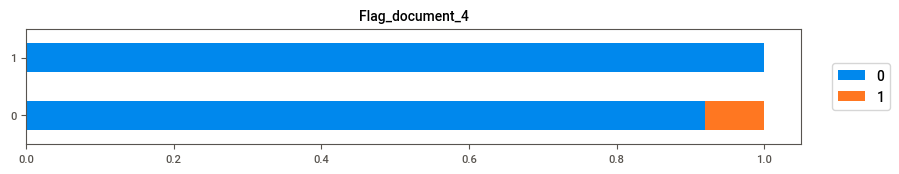

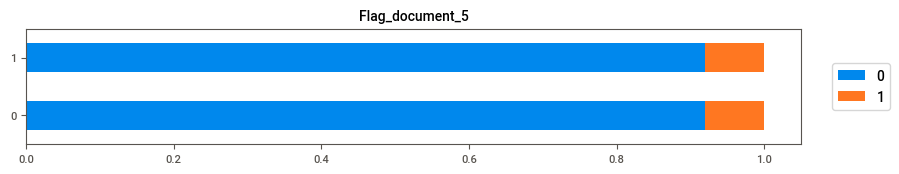

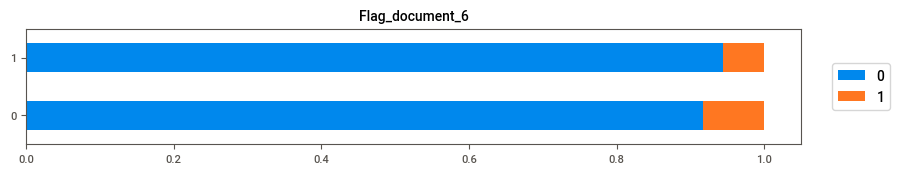

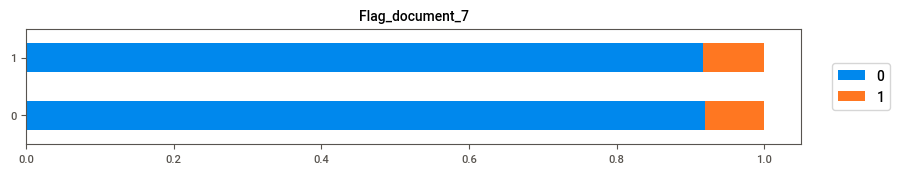

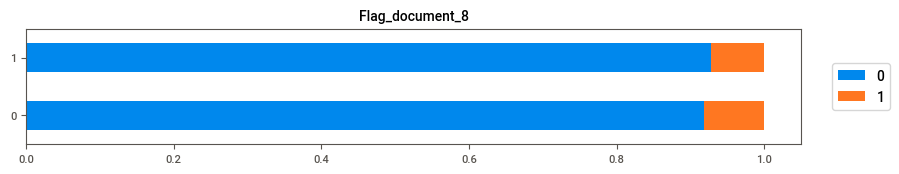

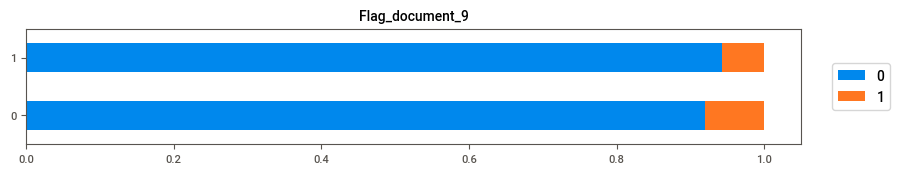

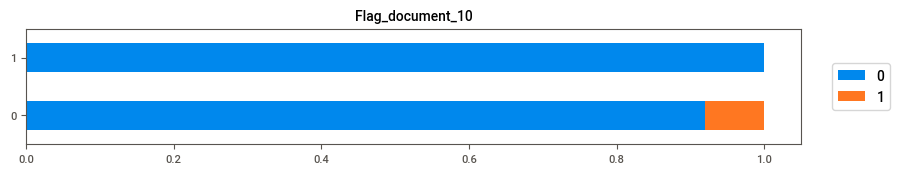

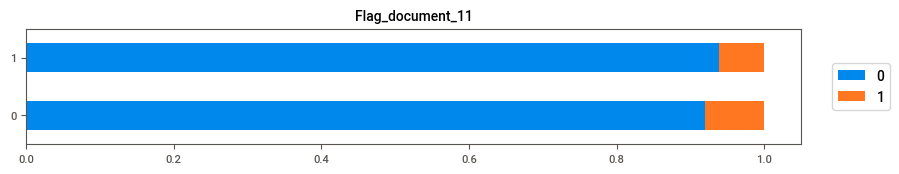

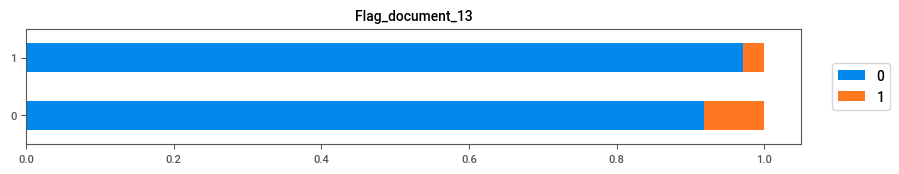

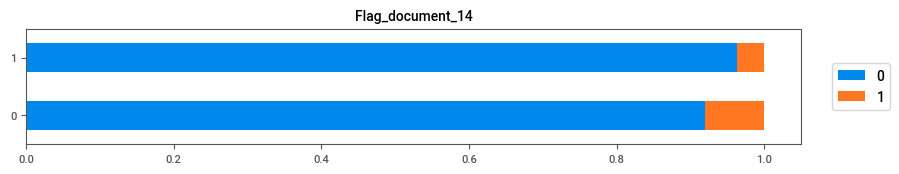

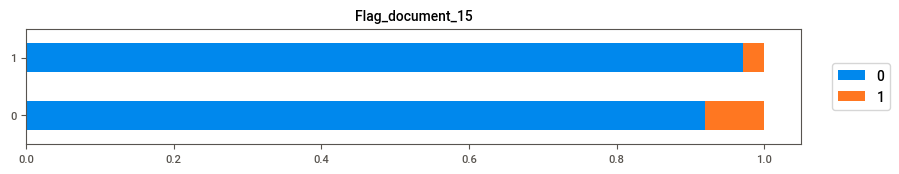

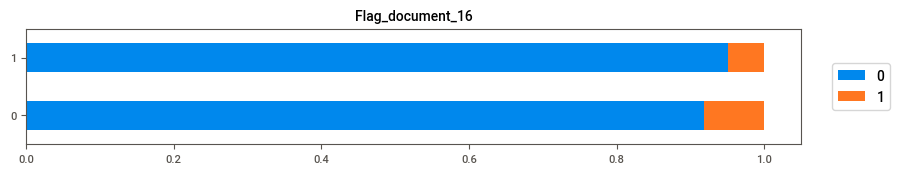

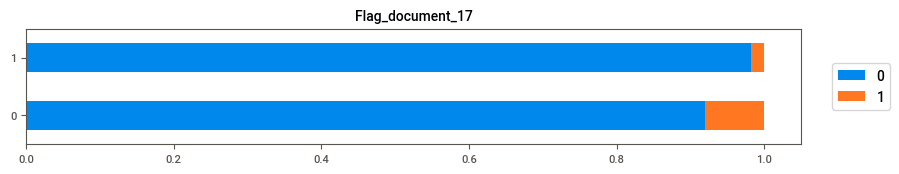

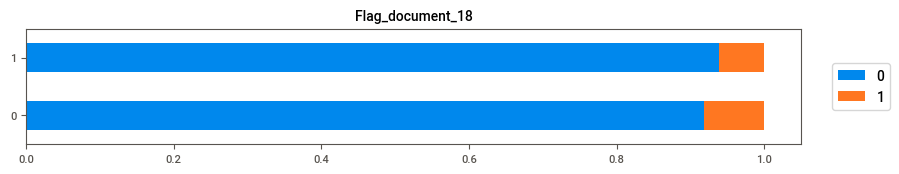

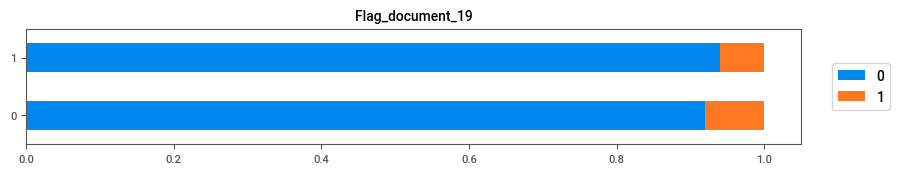

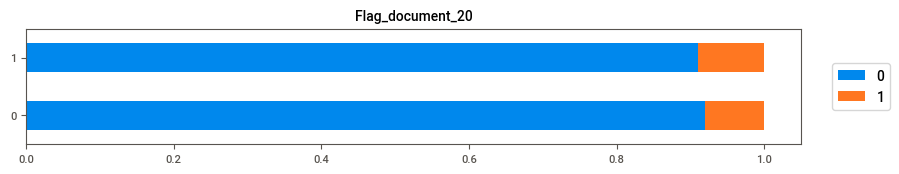

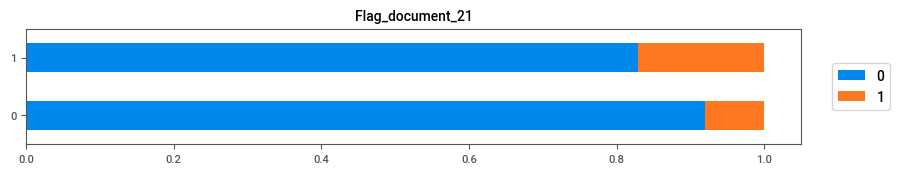

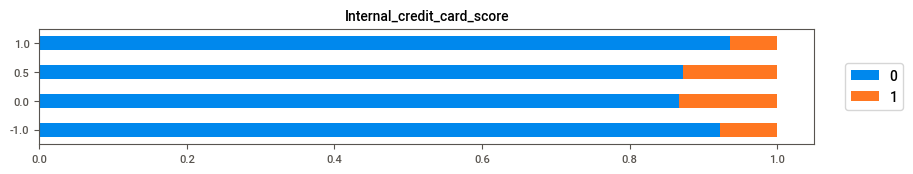

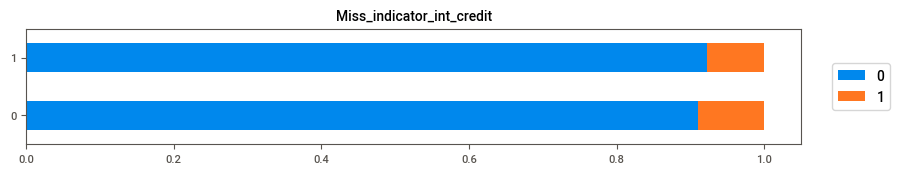

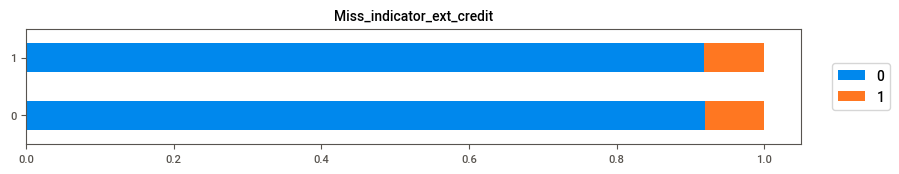

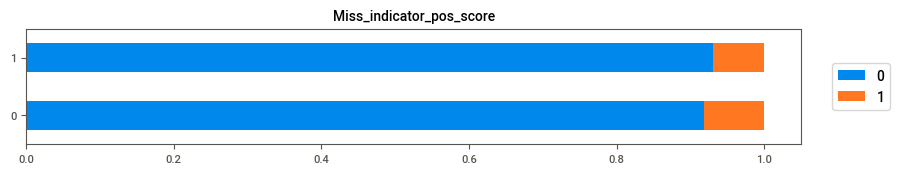

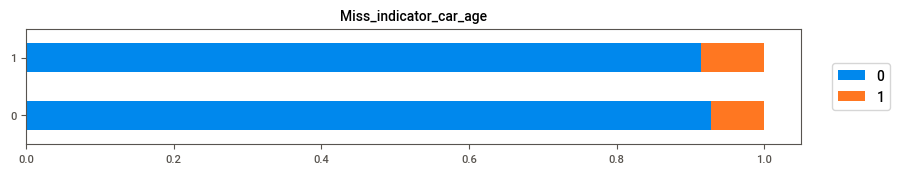

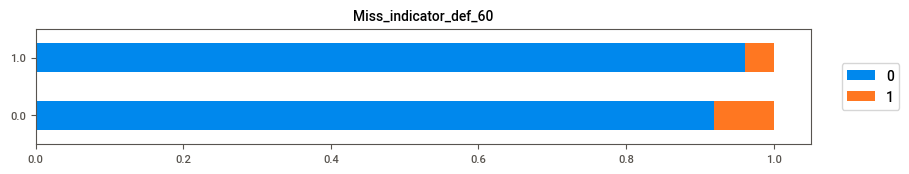

In [240]:
for column in few_n_unique_columns:
    
    x_train.groupby(column).TARGET.value_counts(normalize = True).unstack('TARGET').plot(kind = 'barh',stacked = True)
    plt.gcf().set_size_inches(10,1.5)
    plt.xticks(rotation = 0)
    plt.title(column.capitalize(),fontsize = 10)
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


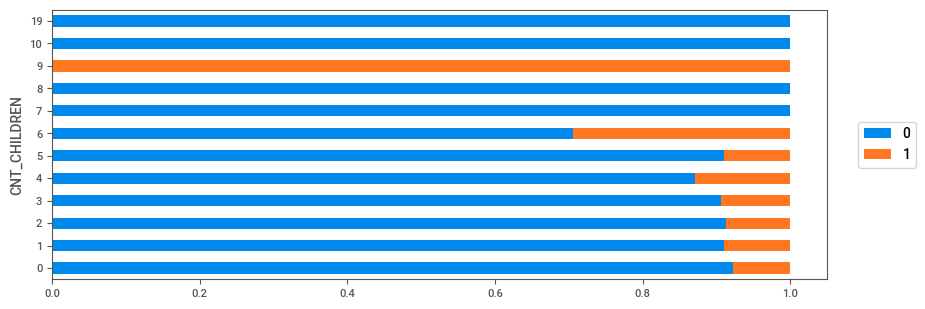

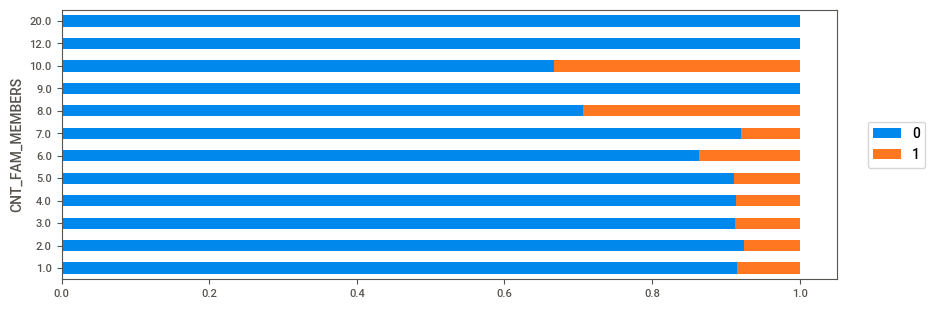

In [241]:
for column in ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']:
    
    x_train.groupby(column).TARGET.value_counts(normalize = True).unstack('TARGET').plot(kind = 'barh',stacked = True)
    plt.gcf().set_size_inches(10,3.5)
    plt.xticks(rotation = 0);
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


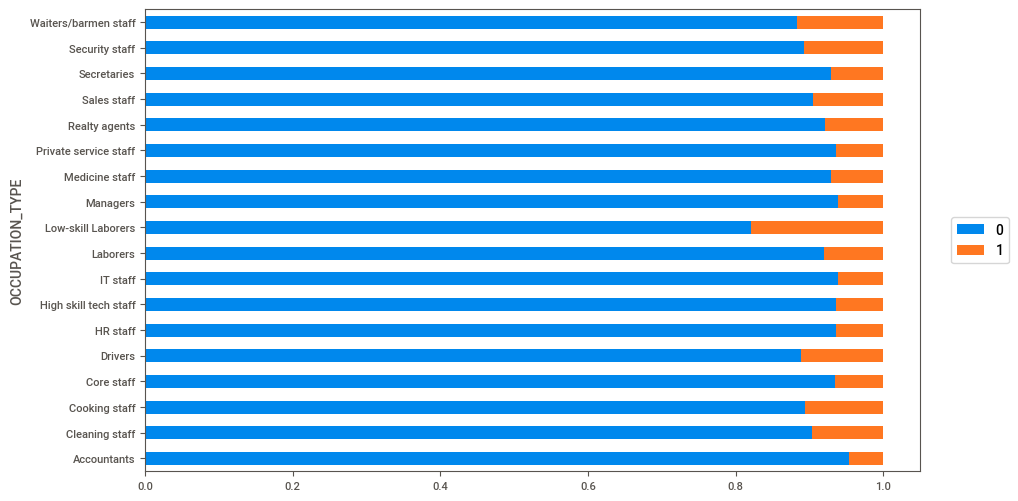

In [242]:
x_train.groupby('OCCUPATION_TYPE').TARGET.value_counts(normalize = True).unstack('TARGET').plot(kind = 'barh',stacked = True)
plt.gcf().set_size_inches(10,6)
plt.xticks(rotation = 0);
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

In [243]:
integer_index_obs_60 = x_train.OBS_60_CNT_SOCIAL_CIRCLE.sort_values(ascending = False).unique().astype('int')
integer_index_obs_30 = x_train.OBS_30_CNT_SOCIAL_CIRCLE.sort_values(ascending = False).unique().astype('int')

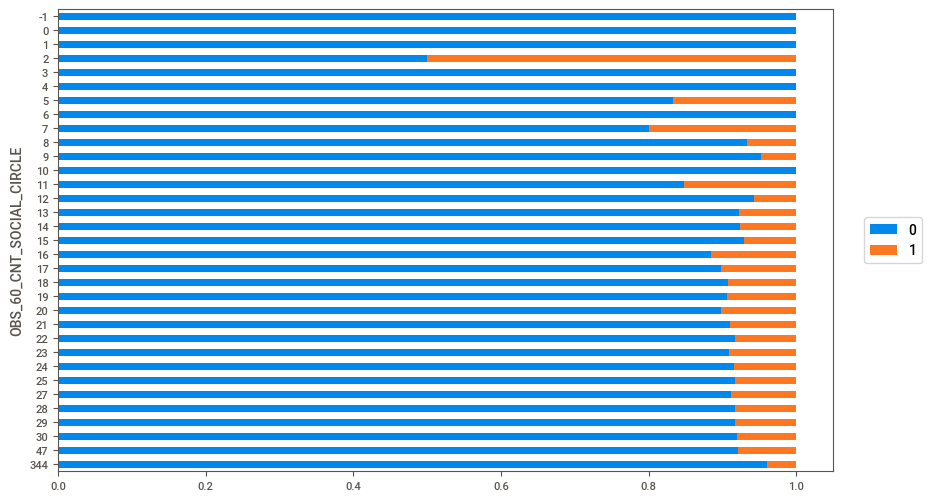

In [244]:
(x_train.groupby('OBS_60_CNT_SOCIAL_CIRCLE').TARGET.value_counts(normalize = True).unstack('TARGET').
 set_index(integer_index_obs_60).
 plot(kind = 'barh',stacked = True))
plt.gcf().set_size_inches(10,6)
plt.xticks(rotation = 0);
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.ylabel('OBS_60_CNT_SOCIAL_CIRCLE');

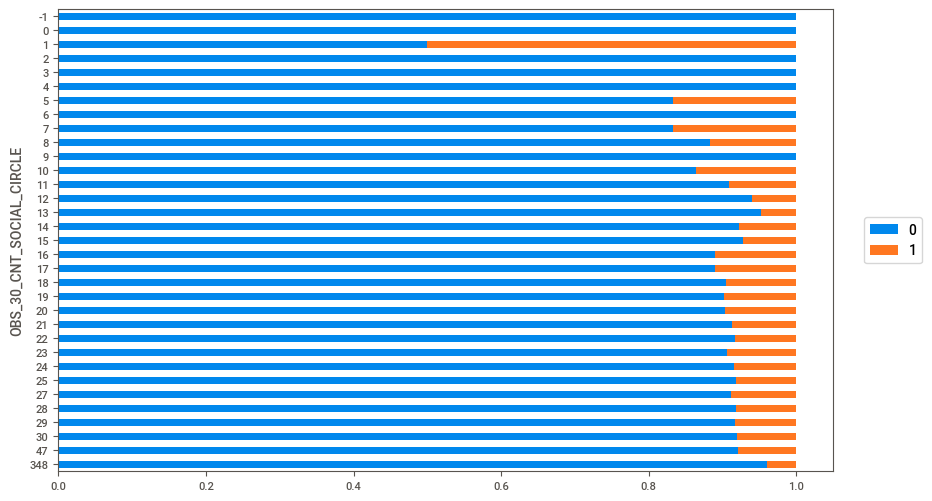

In [245]:
(x_train.groupby('OBS_30_CNT_SOCIAL_CIRCLE').TARGET.value_counts(normalize = True).unstack('TARGET').
 set_index(integer_index_obs_30).
 plot(kind = 'barh',stacked = True))
plt.gcf().set_size_inches(10,6)
plt.xticks(rotation = 0);
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.ylabel('OBS_30_CNT_SOCIAL_CIRCLE');

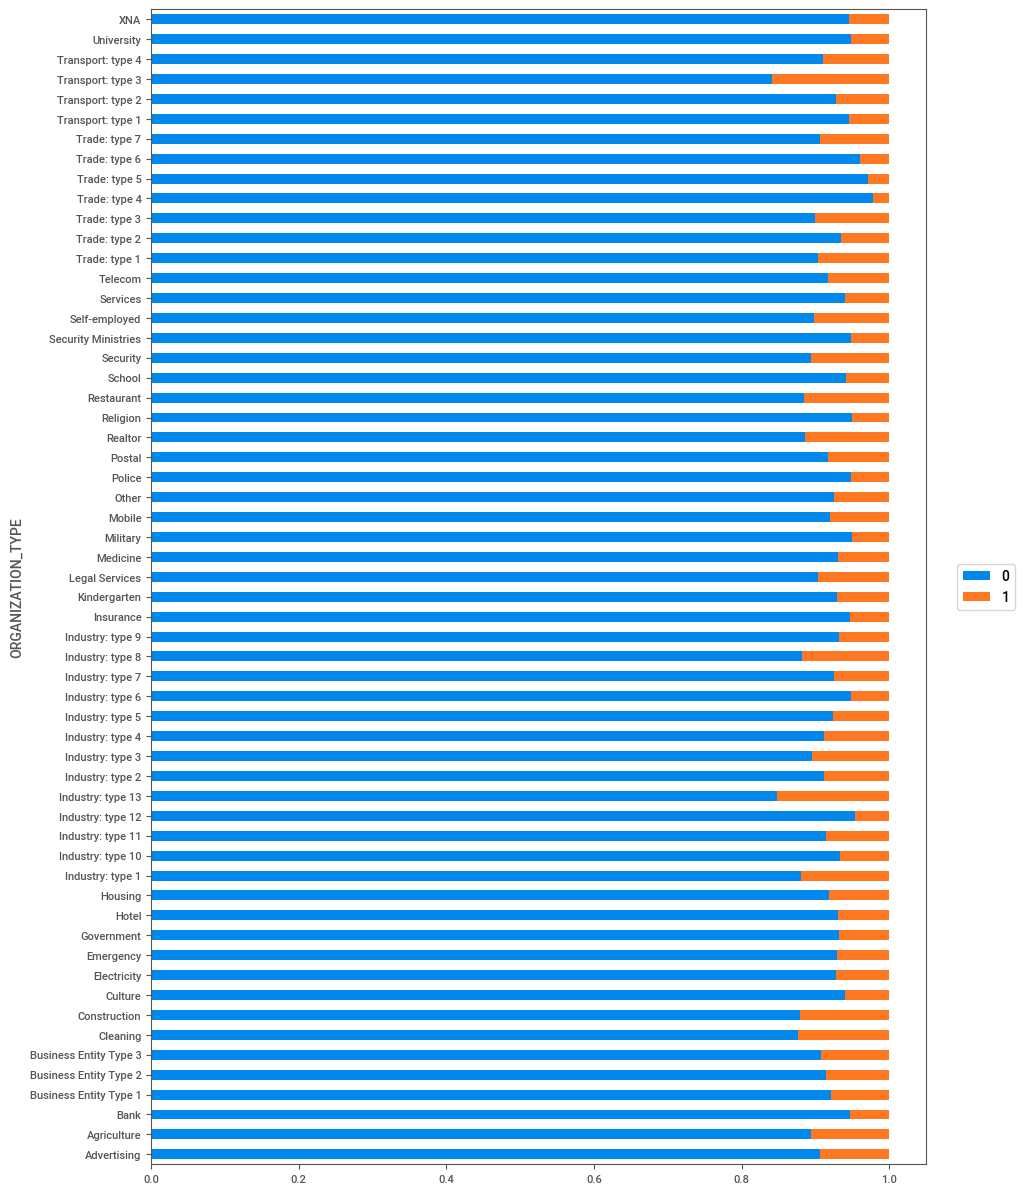

In [246]:
x_train.groupby('ORGANIZATION_TYPE').TARGET.value_counts(normalize = True).unstack('TARGET'). \
plot(kind = 'barh',stacked = True)
plt.gcf().set_size_inches(10,15)
plt.xticks(rotation = 0);
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

In [247]:
continuous_columns = x_train.nunique()[x_train.nunique() > 80].index.to_list() + ['OWN_CAR_AGE','Internal_POS_score']

In [248]:
continuous_columns

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'External_credit_score',
 'OWN_CAR_AGE',
 'Internal_POS_score']

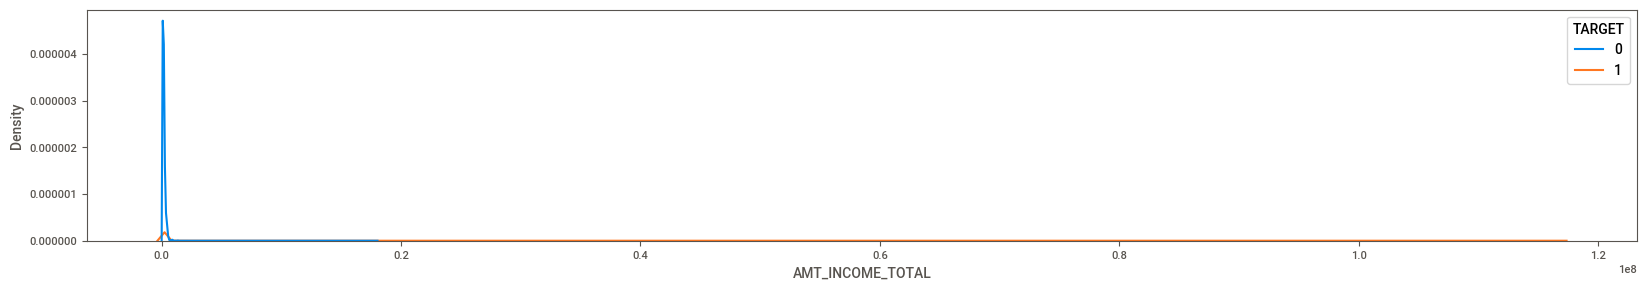

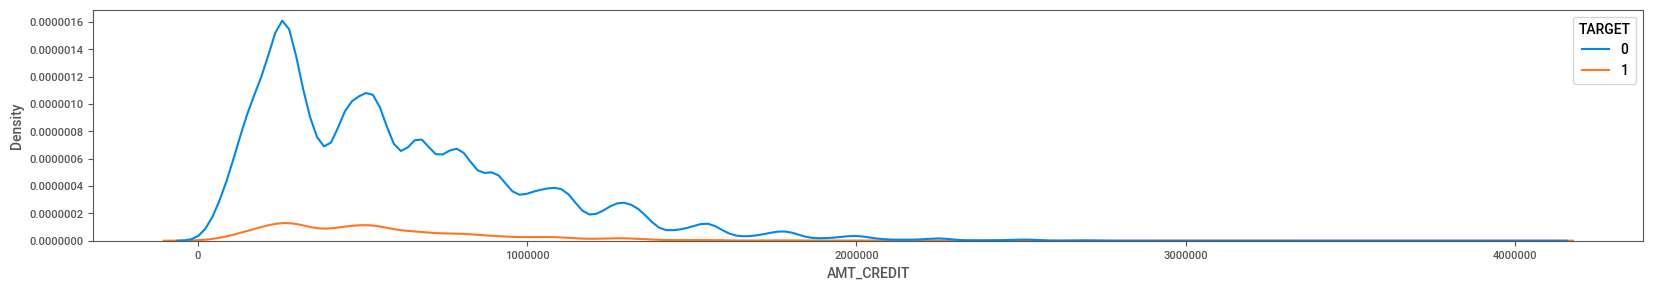

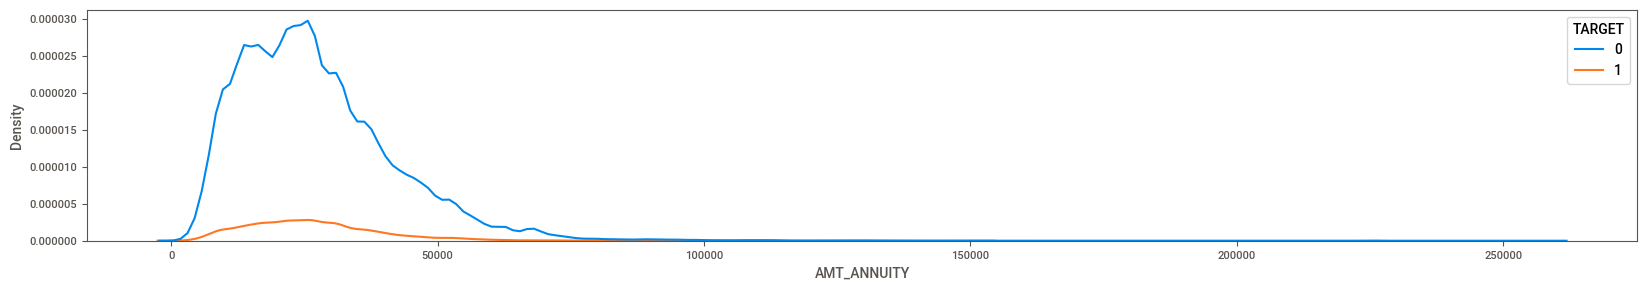

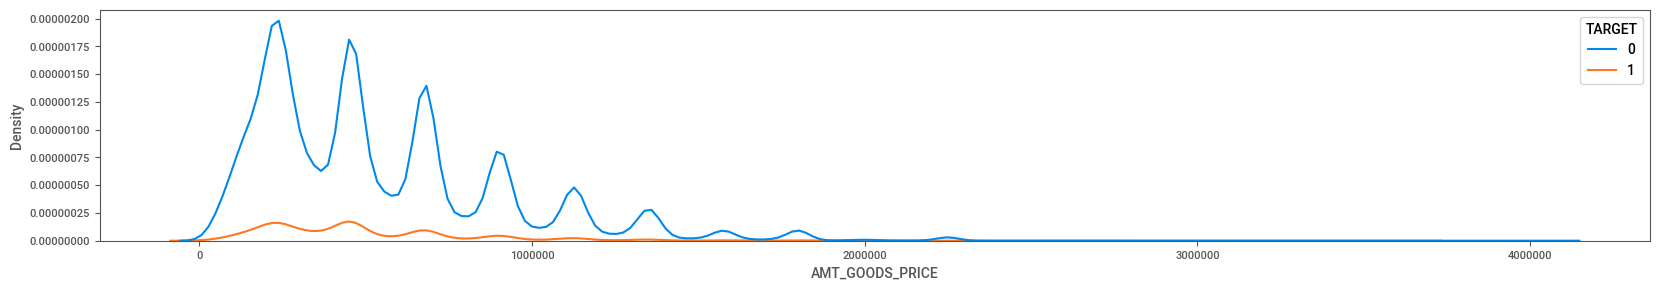

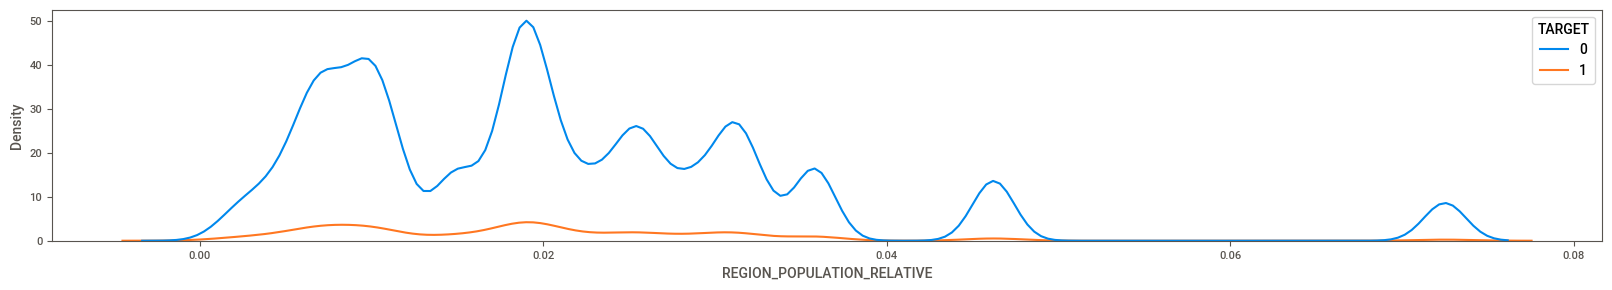

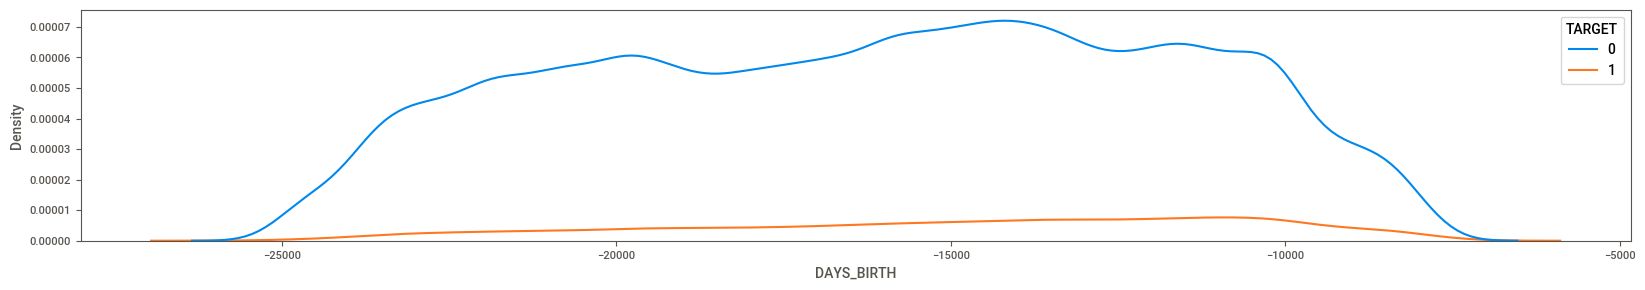

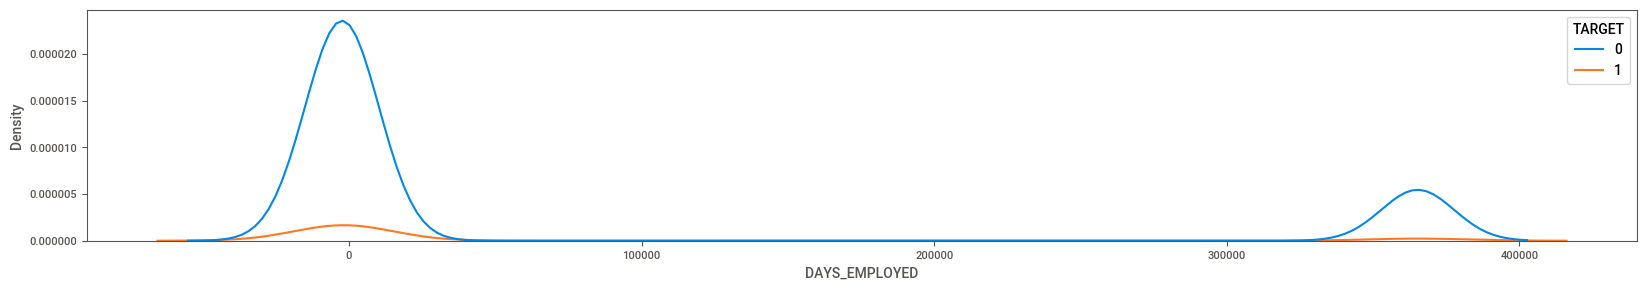

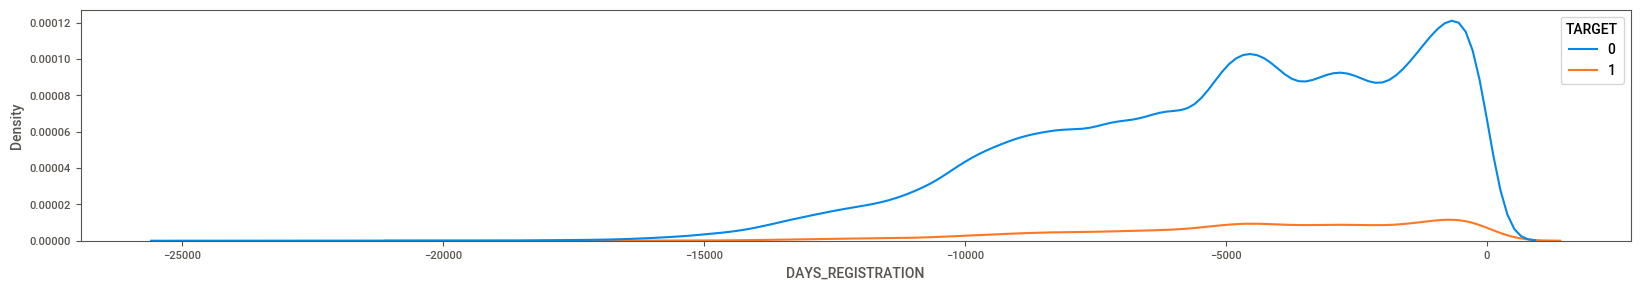

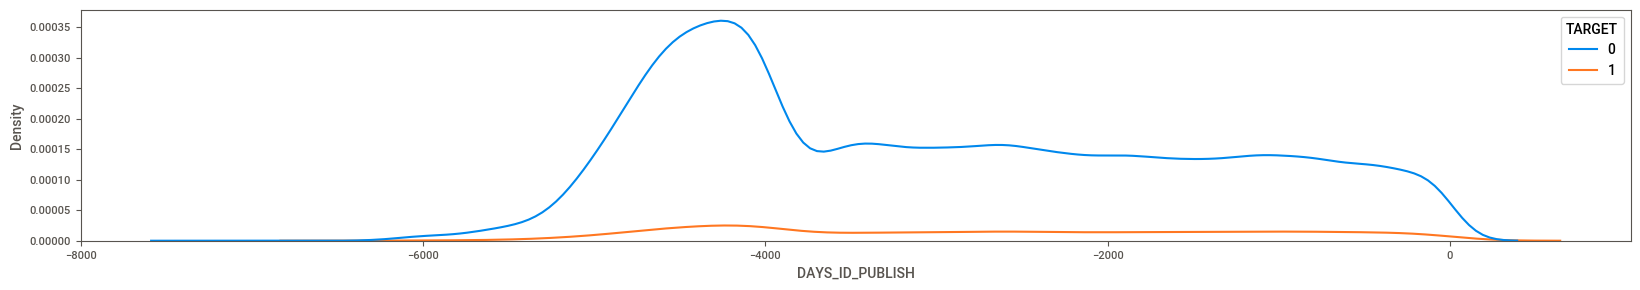

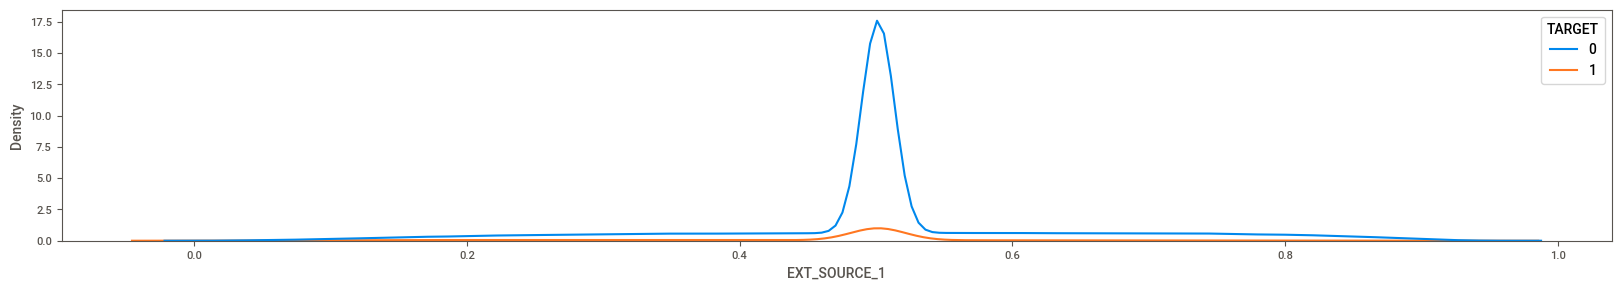

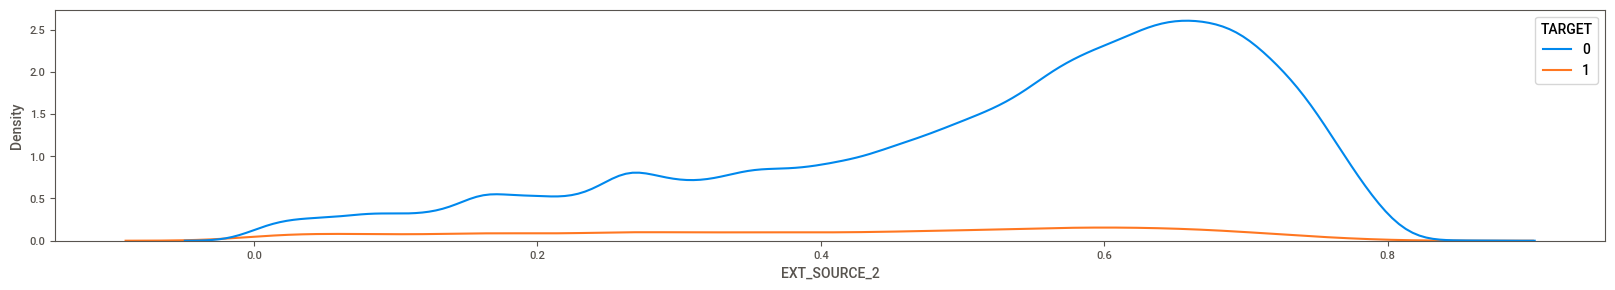

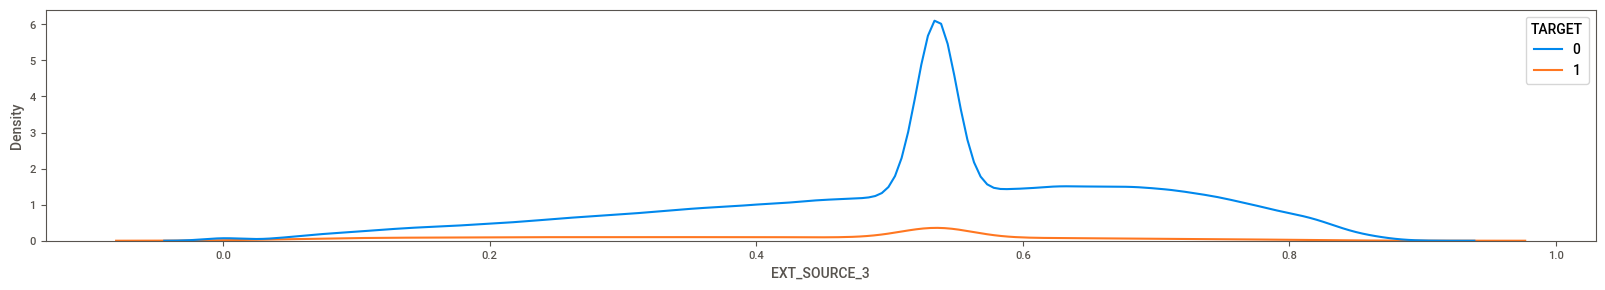

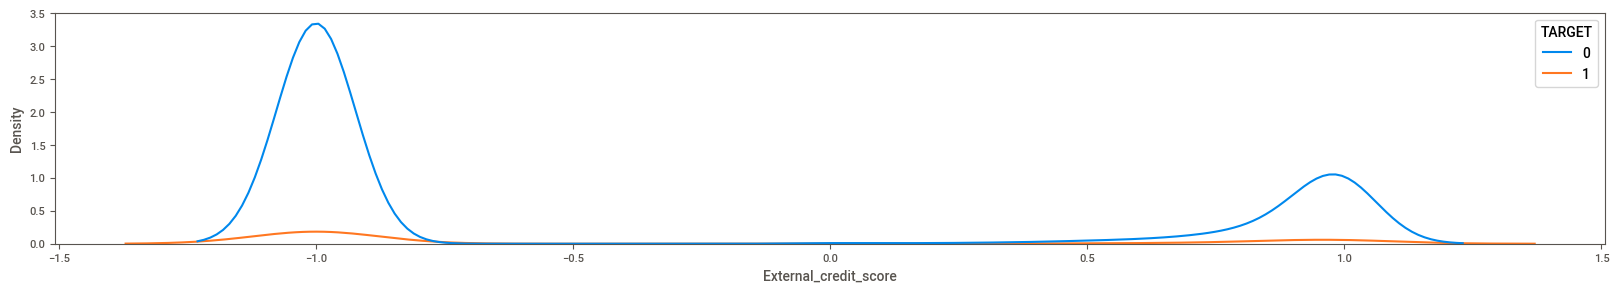

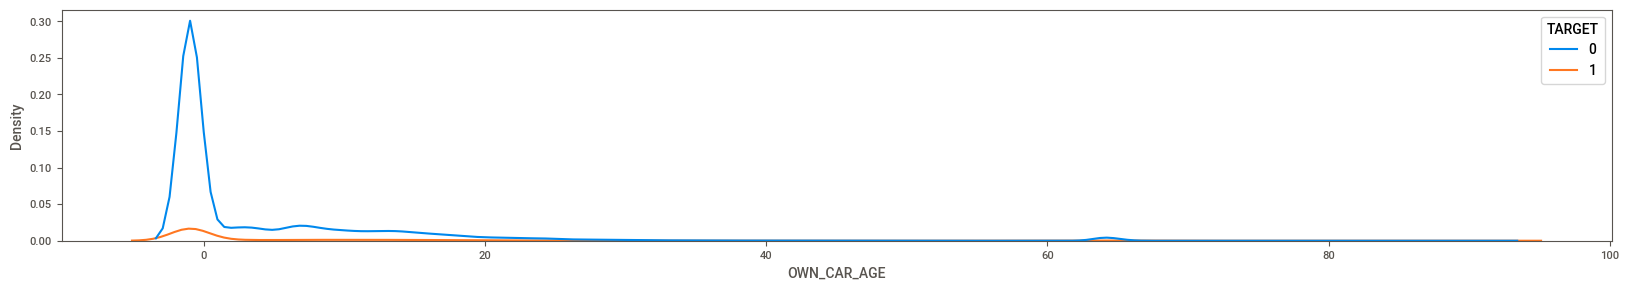

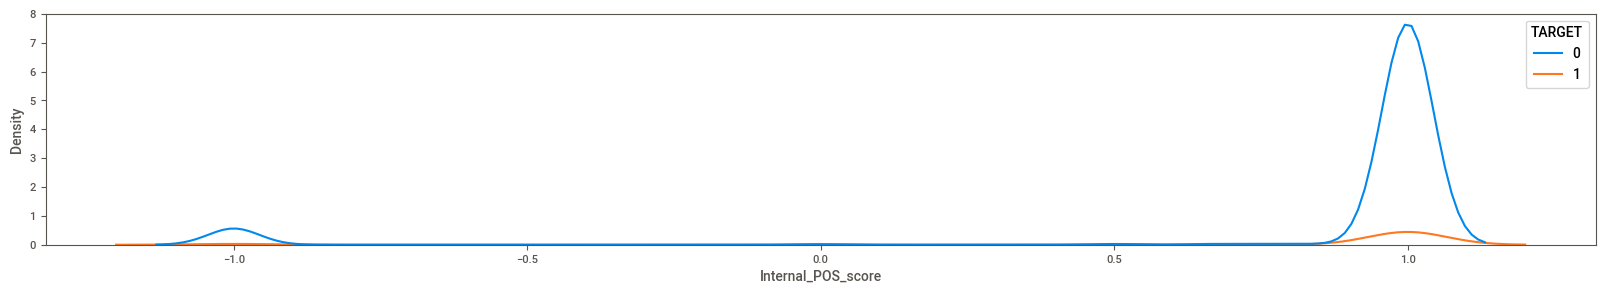

In [249]:
np.seterr(under='ignore')

for column in continuous_columns:
        plt.figure(figsize=(20,3))
        sns.kdeplot(x = column,data = x_train,hue = 'TARGET')

**Observations:** Most of the features have no strict relationship with the target.
    
**NAME_INCOME_TYPE** - Applicants in categories like Businessman, Students and Maternity Leave have no defaulters.

**NAME_EDUCATION_TYPE** - As the education level increases, the defaulting capabilities are decreasing.
 

## Bivariate Analysis between Features

**Exploring linear relationship among two continuous numeric feature combinations using Pearson correlation**

In [250]:
continuous_columns = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH',
'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','Internal_POS_score','Internal_credit_card_score','External_credit_score']

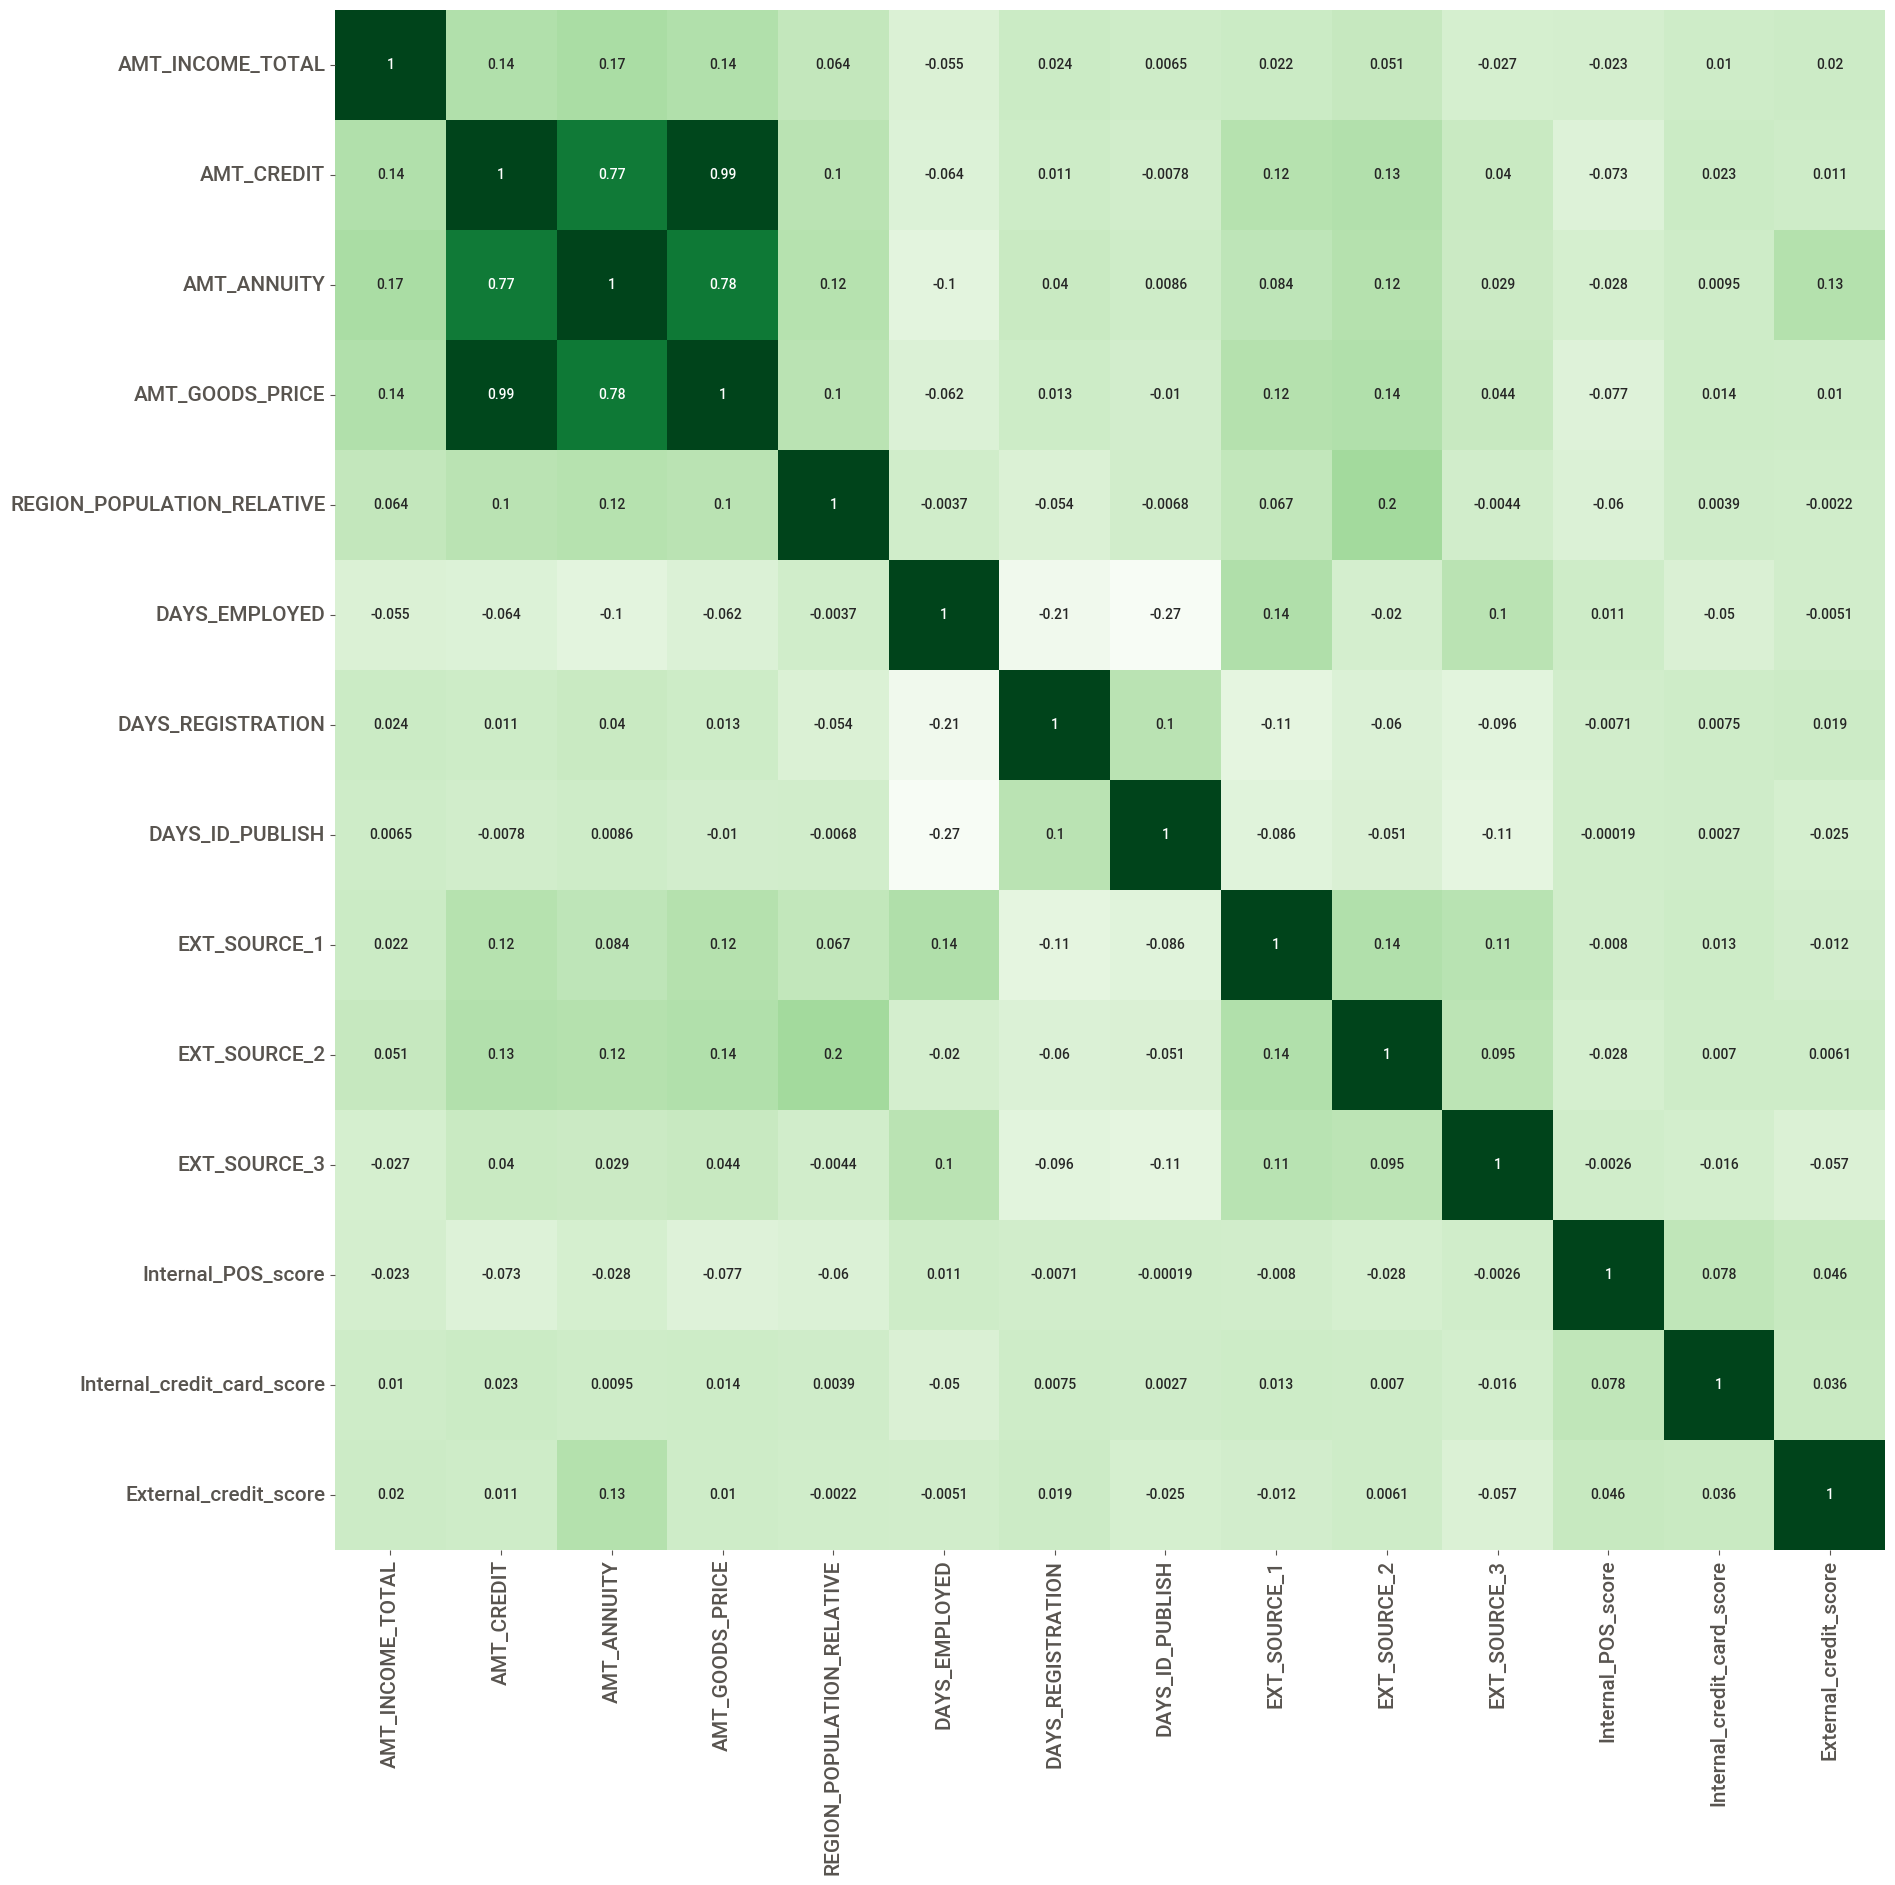

In [251]:
plt.figure(figsize=(20,20))
sns.heatmap(x_train[continuous_columns].corr(),annot=True,cbar=False,cmap= 'Greens')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

**Observations:** AMT_CREDIT and AMT_GOODS_PRICE are correlated to almost 1.

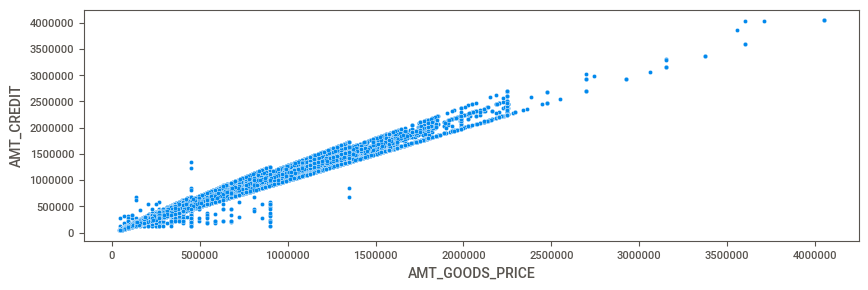

In [252]:
plt.figure(figsize=(10,3))
sns.scatterplot(x = 'AMT_GOODS_PRICE',y = 'AMT_CREDIT', data = x_train);

**Observation:** The scatterplot reveals a perfect linear relationship between AMT_CREDIT and AMT_GOODS_PRICE, in consistent with the observation found in heatmap.

In [253]:
pd.crosstab(x_train.CNT_FAM_MEMBERS,x_train.CNT_CHILDREN)  

CNT_CHILDREN         0      1      2     3    4   5   6   7   8   9   10  19
CNT_FAM_MEMBERS                                                             
1.0               47539      0      0     0    0   0   0   0   0   0   0   0
2.0              103102   7570      0     0    0   0   0   0   0   0   0   0
3.0                   0  35375   1627     0    0   0   0   0   0   0   0   0
4.0                   0      0  17070   190    0   0   0   0   0   0   0   0
5.0                   0      0      0  2408   20   0   0   0   0   0   0   0
6.0                   0      0      0     0  260   5   0   0   0   0   0   0
7.0                   0      0      0     0    0  62   1   0   0   0   0   0
8.0                   0      0      0     0    0   0  16   1   0   0   0   0
9.0                   0      0      0     0    0   0   0   5   0   0   0   0
10.0                  0      0      0     0    0   0   0   0   2   1   0   0
12.0                  0      0      0     0    0   0   0   0   0   0   2   0
20.0                  0      0      0     0    0   0   0   0   0   0   0   1

**Observations:** There is almost an one to one relationship between the two features. 
    
Mostly, Number of family members = Number of children + 2

<Axes: xlabel='AMT_CREDIT', ylabel='NAME_CONTRACT_TYPE'>

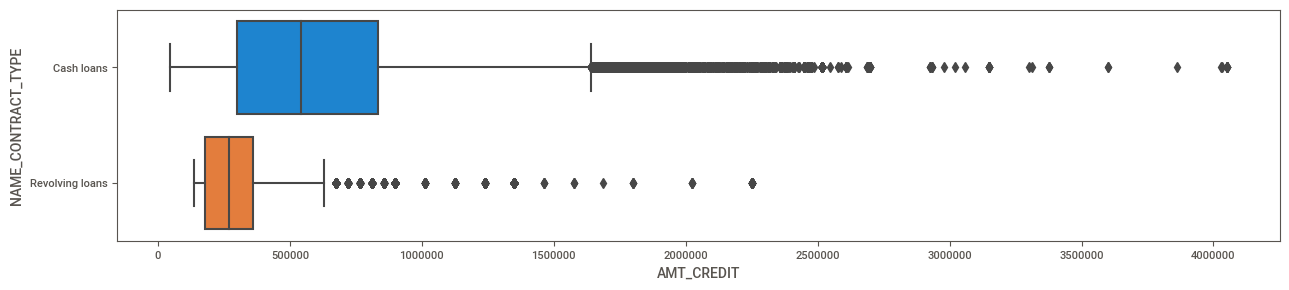

In [254]:
plt.figure(figsize=(15,3))
sns.boxplot(y = 'NAME_CONTRACT_TYPE', x = 'AMT_CREDIT', data = x_train,orient = 'h')

**Observations:**  The loan amount provided for cash loans is higher than that revolving loans.
    

<Axes: xlabel='AMT_CREDIT', ylabel='NAME_EDUCATION_TYPE'>

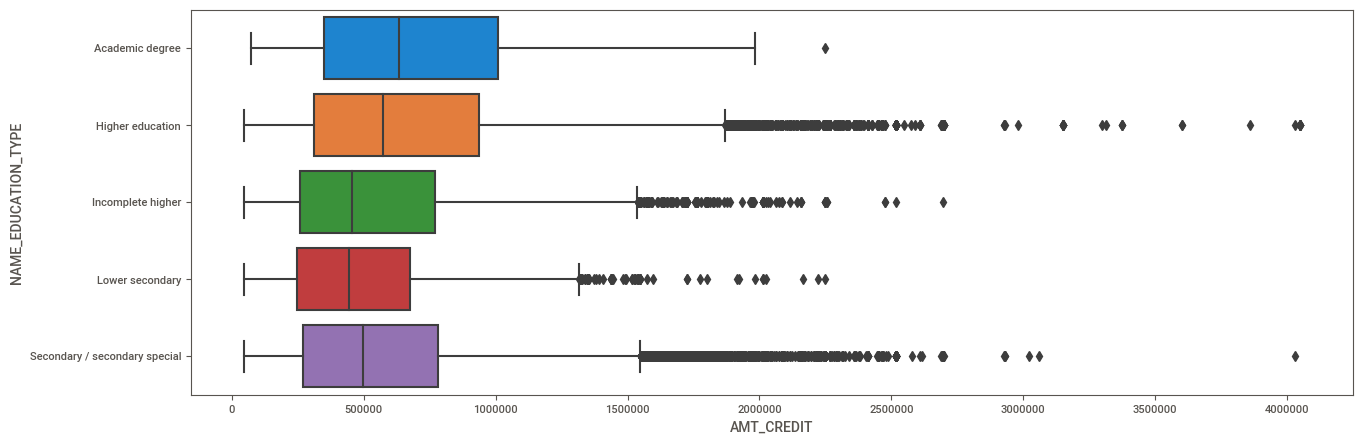

In [255]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'AMT_CREDIT', y = 'NAME_EDUCATION_TYPE', data = x_train,orient = 'h')

**Observations:** Higher the level of education attained by the loan applicant, higher the loan he gets.

<Axes: xlabel='REGION_POPULATION_RELATIVE', ylabel='REGION_RATING_CLIENT'>

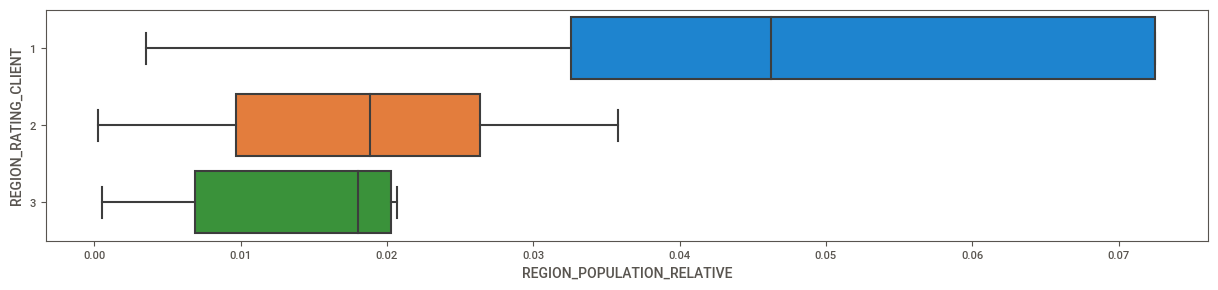

In [256]:
plt.figure(figsize=(15,3))
sns.boxplot(x = 'REGION_POPULATION_RELATIVE',y = 'REGION_RATING_CLIENT', data = x_train,orient = 'h')

<Axes: xlabel='REGION_POPULATION_RELATIVE', ylabel='REGION_RATING_CLIENT_W_CITY'>

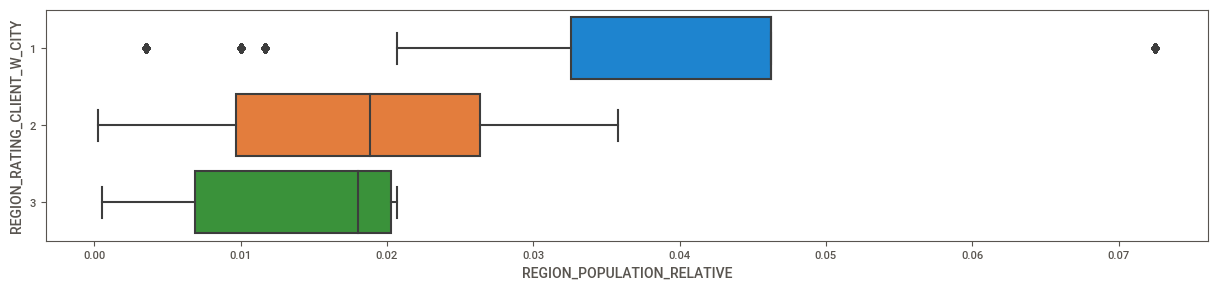

In [257]:
plt.figure(figsize=(15,3))
sns.boxplot(x = 'REGION_POPULATION_RELATIVE',y = 'REGION_RATING_CLIENT_W_CITY' , data = x_train, orient = 'h')

**Observations (from the above two plots):** Higher the population density, higher the region rating. This indicates that the population density of a region mostly determines the region rating of the same.

## Outlier Analysis and Handling

### Outlier Analysis

In [258]:
columns = x_train.select_dtypes('float').columns.to_list() + ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','CNT_CHILDREN']

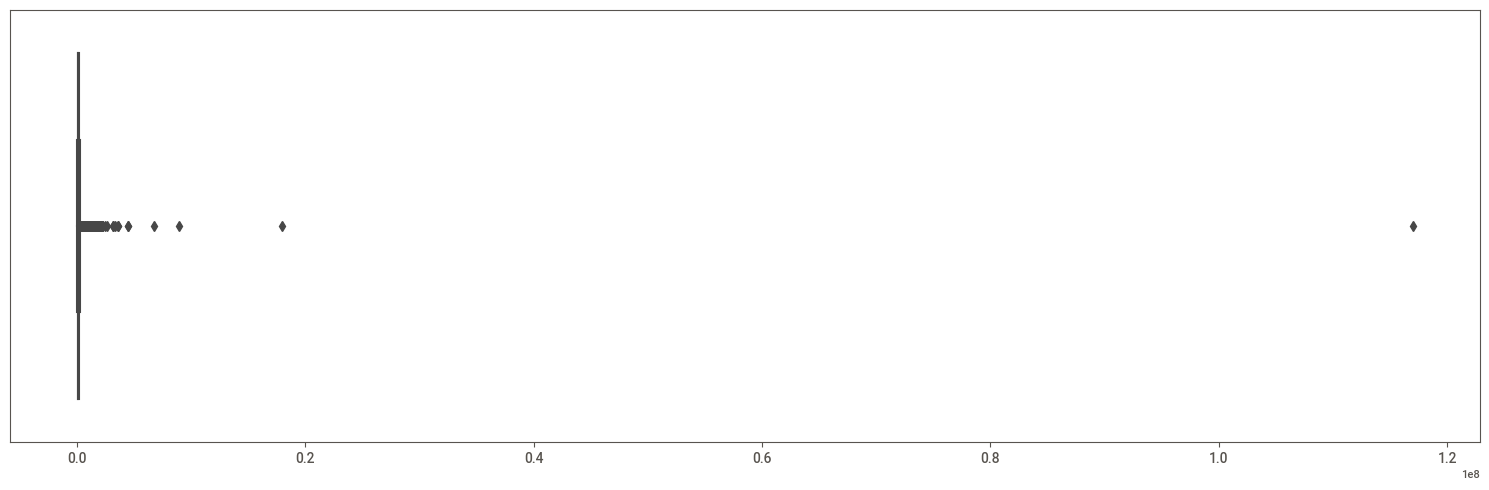

*****************************************************************************************************************************


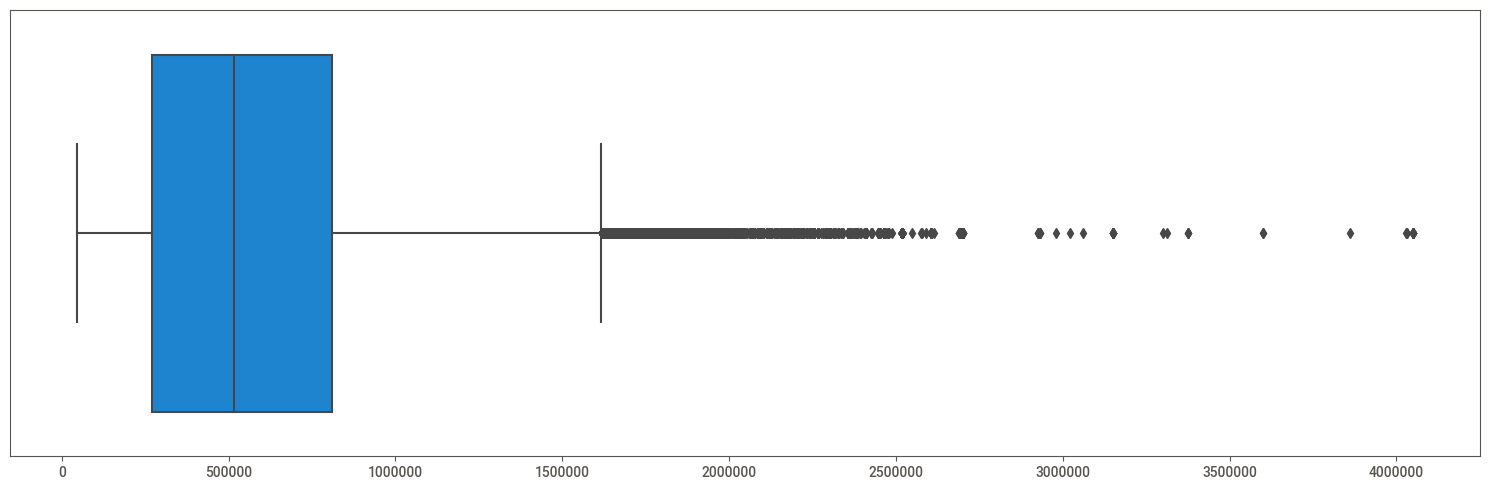

*****************************************************************************************************************************


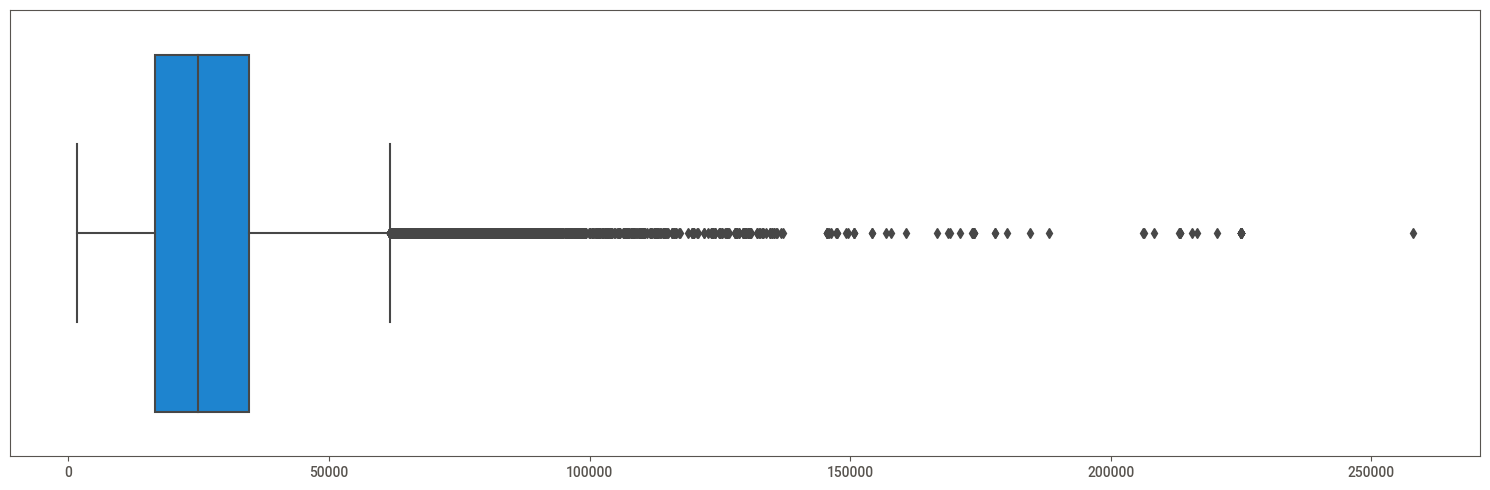

*****************************************************************************************************************************


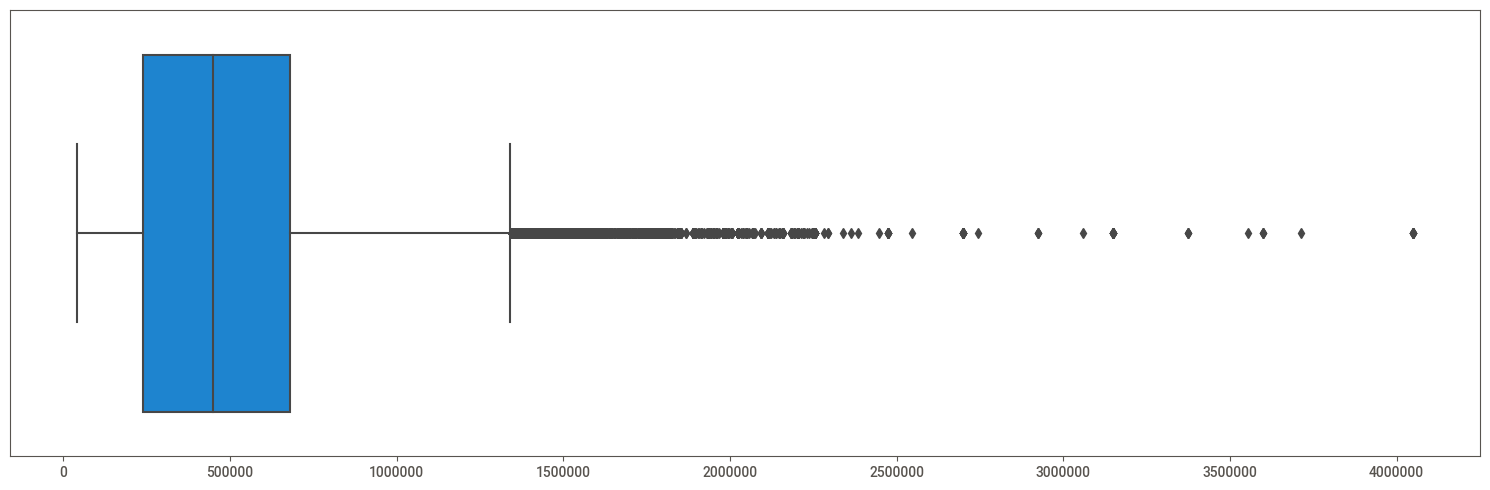

*****************************************************************************************************************************


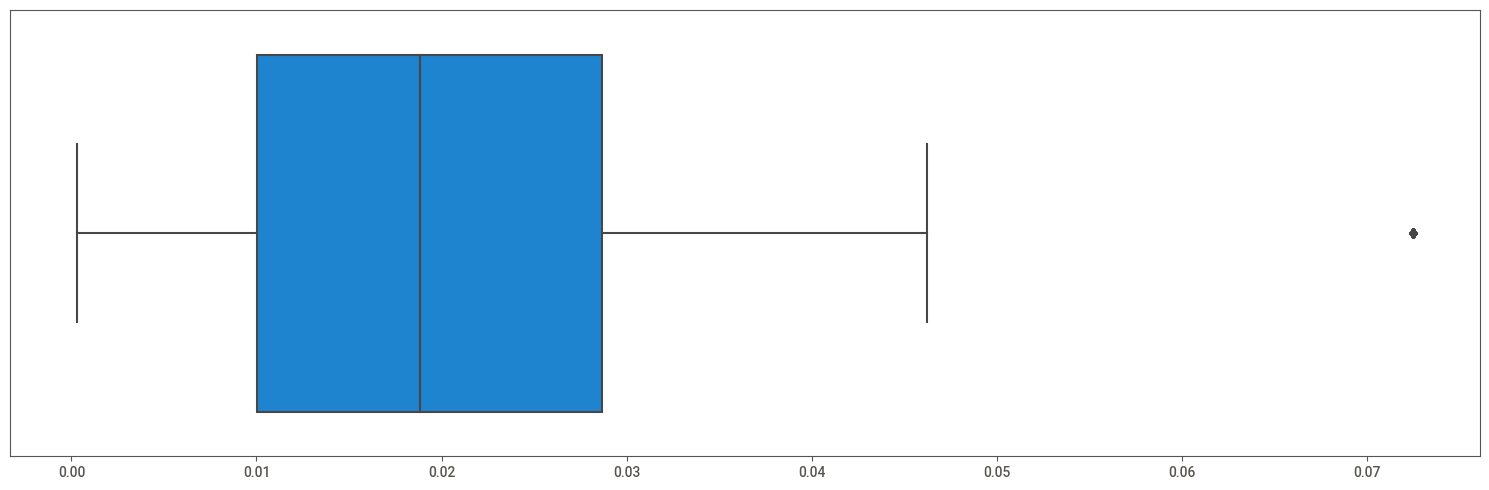

*****************************************************************************************************************************


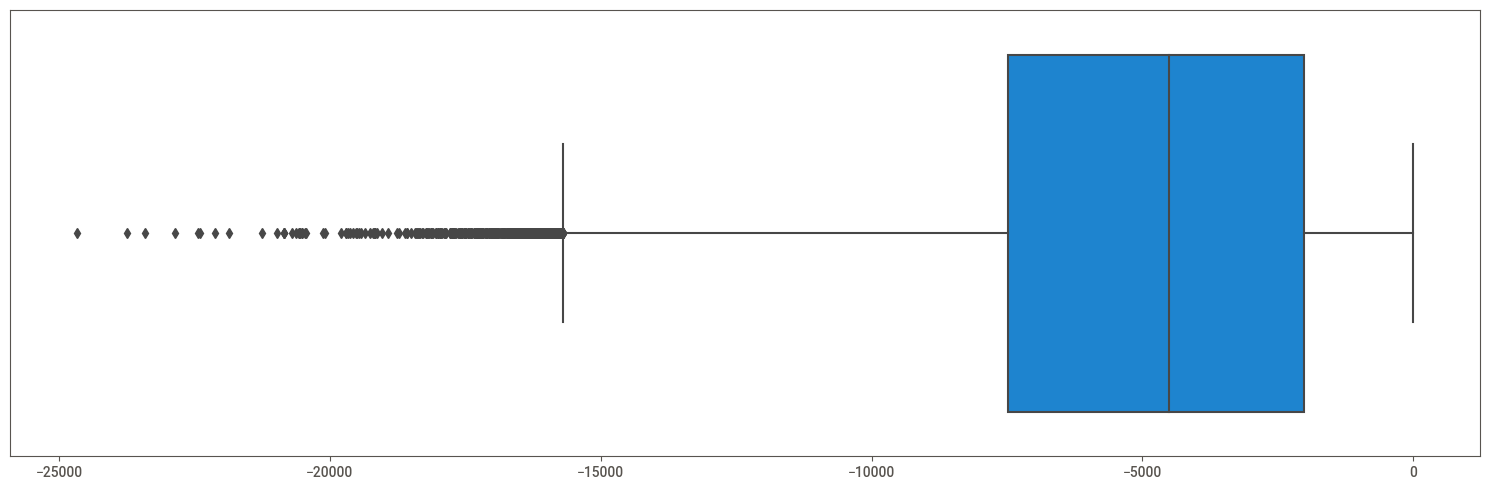

*****************************************************************************************************************************


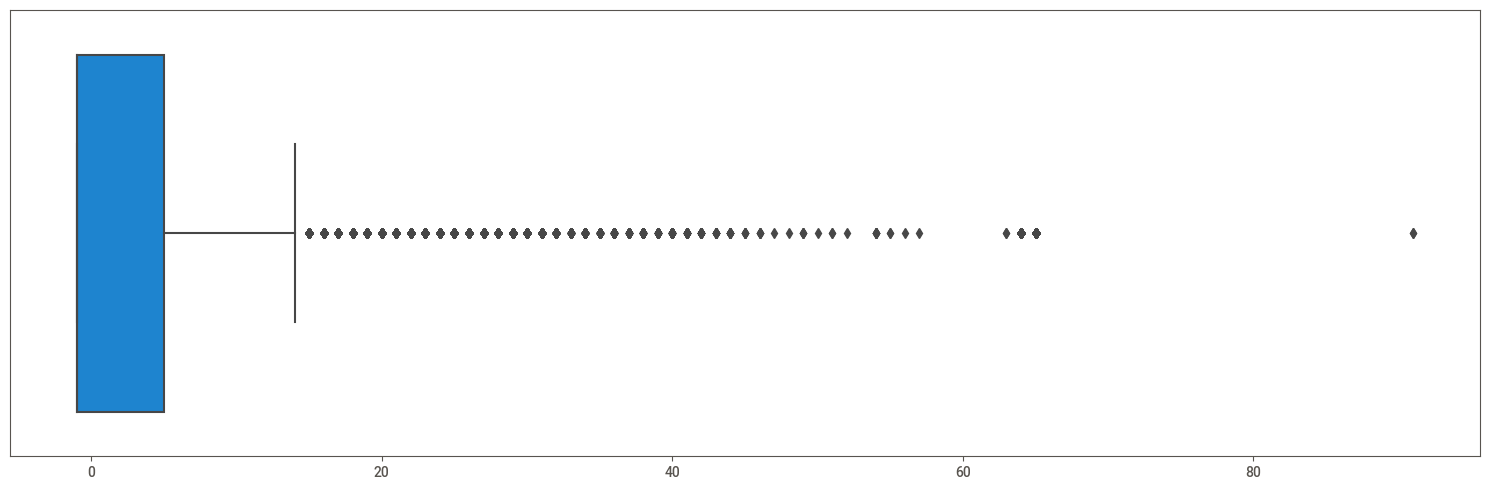

*****************************************************************************************************************************


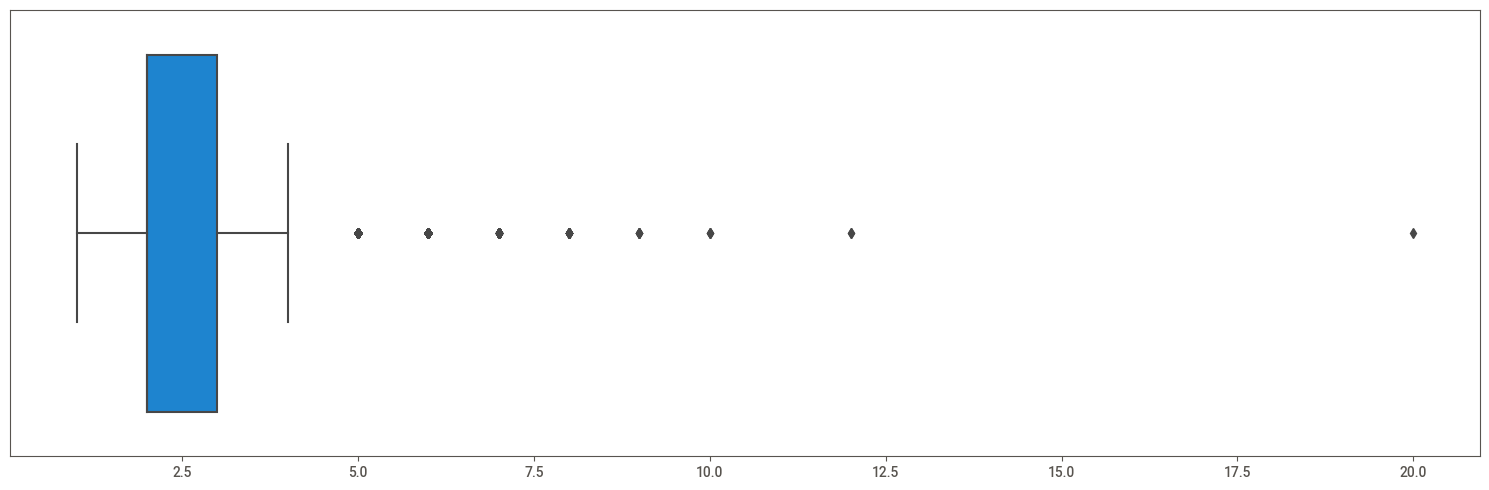

*****************************************************************************************************************************


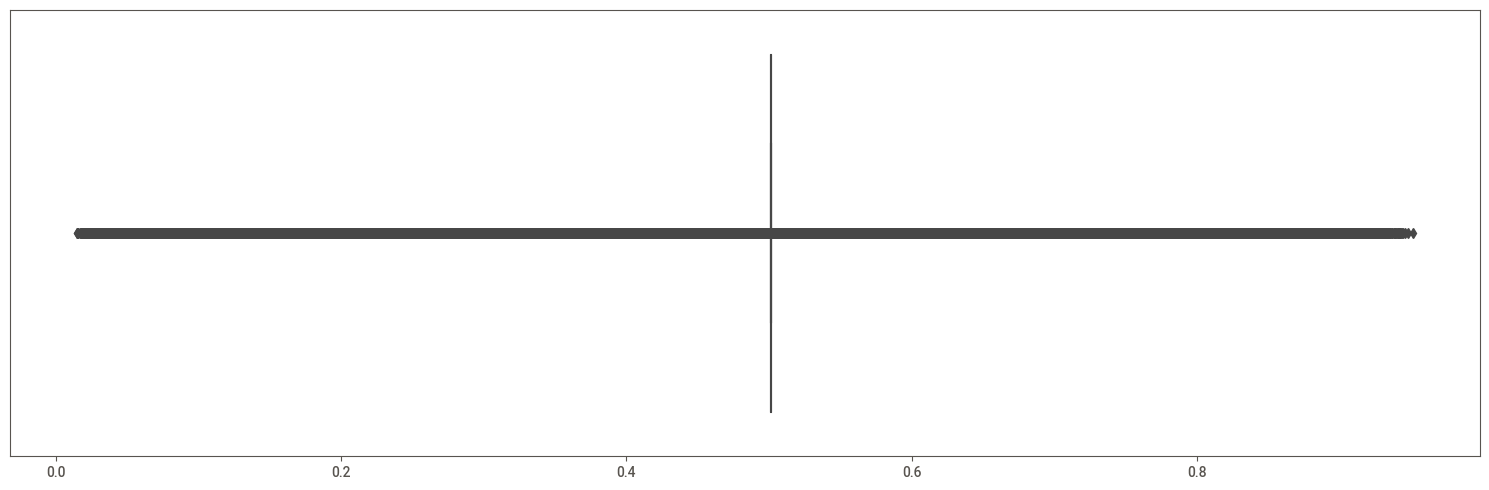

*****************************************************************************************************************************


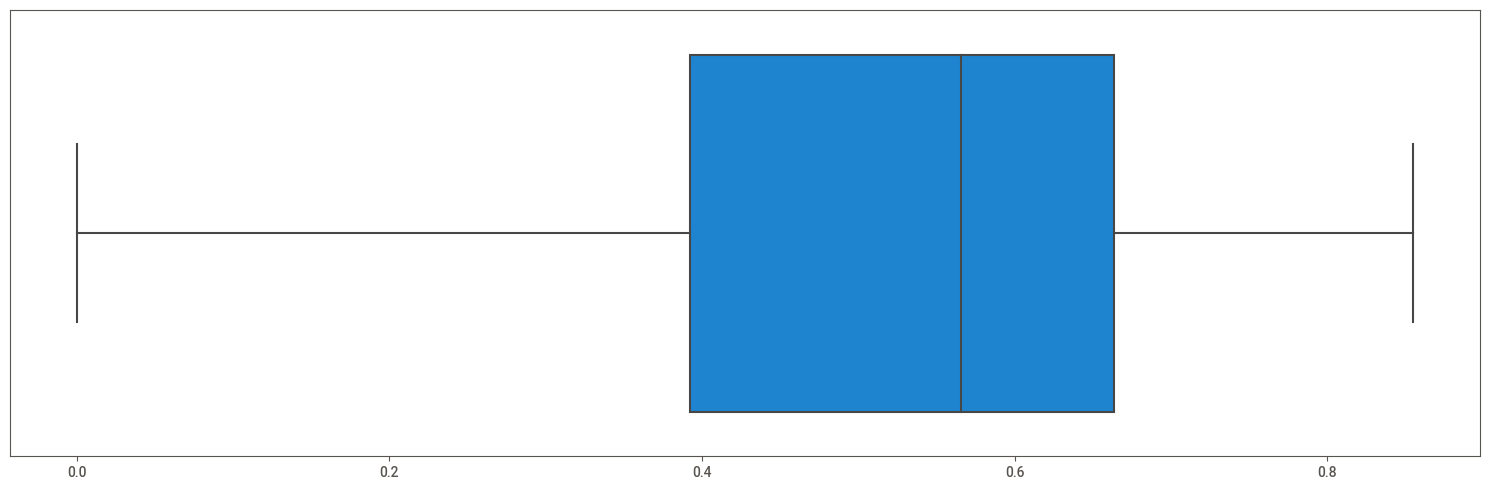

*****************************************************************************************************************************


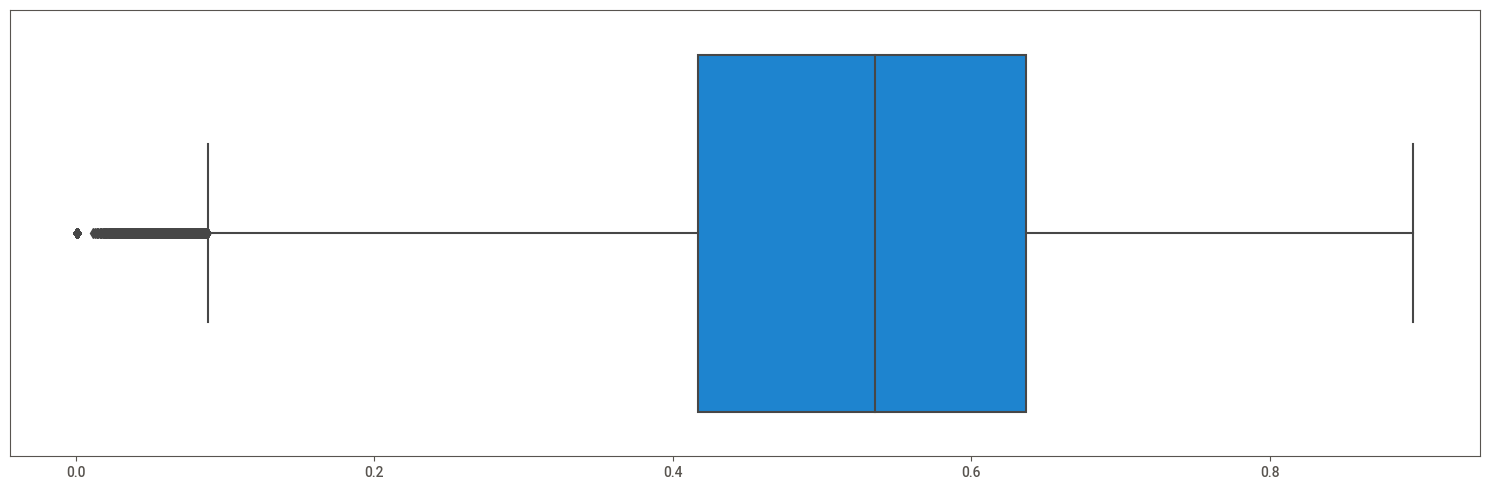

*****************************************************************************************************************************


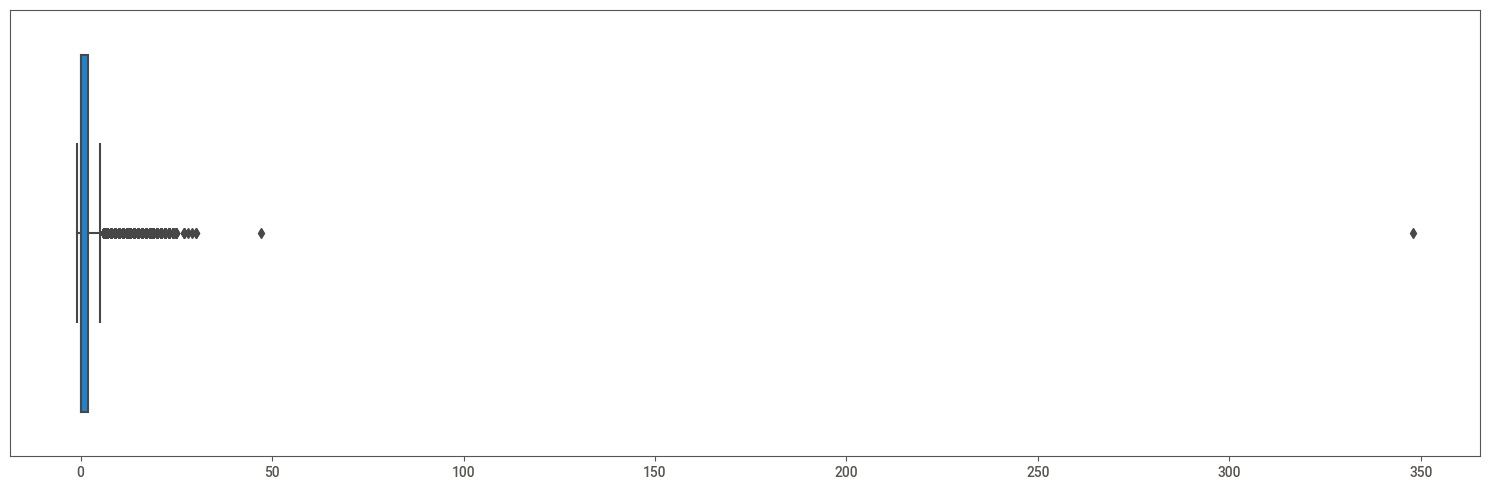

*****************************************************************************************************************************


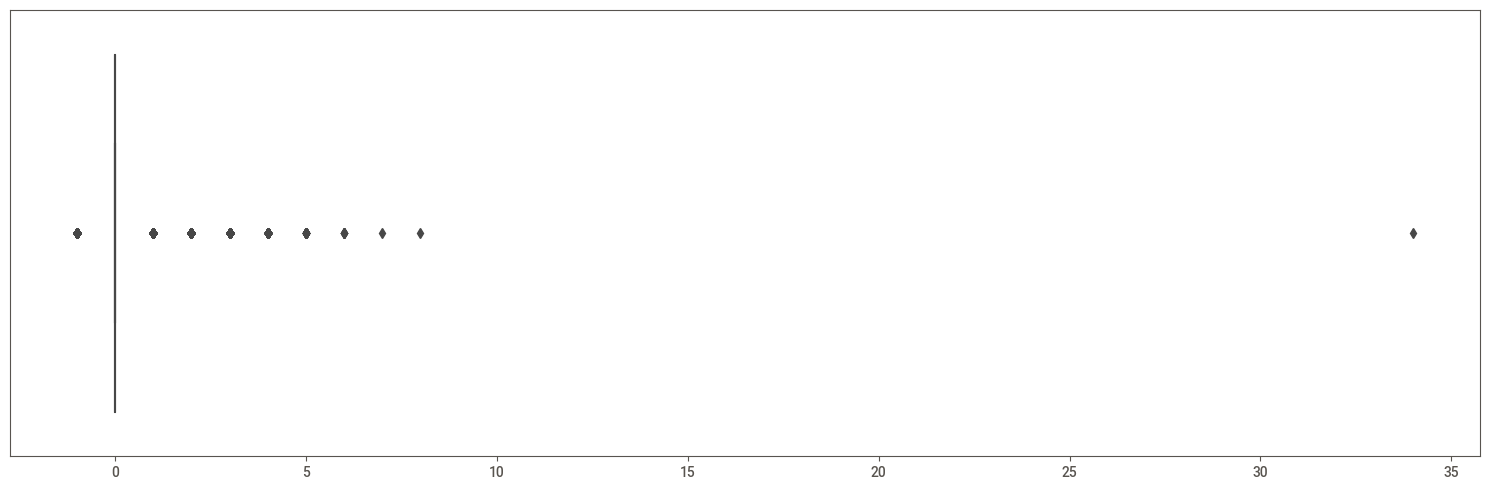

*****************************************************************************************************************************


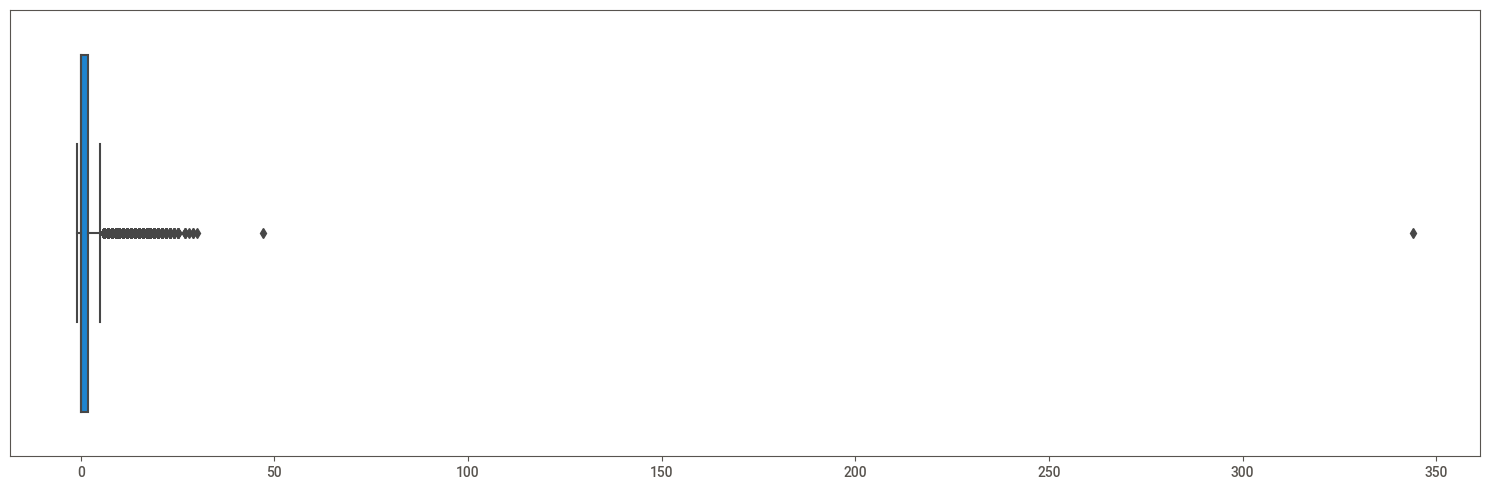

*****************************************************************************************************************************


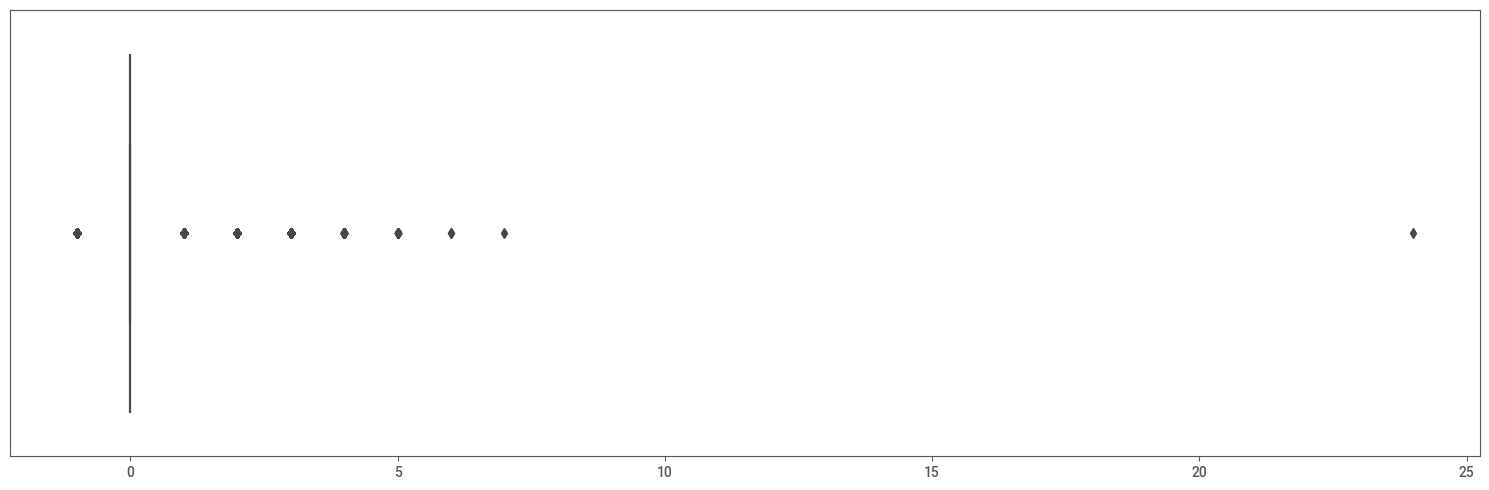

*****************************************************************************************************************************


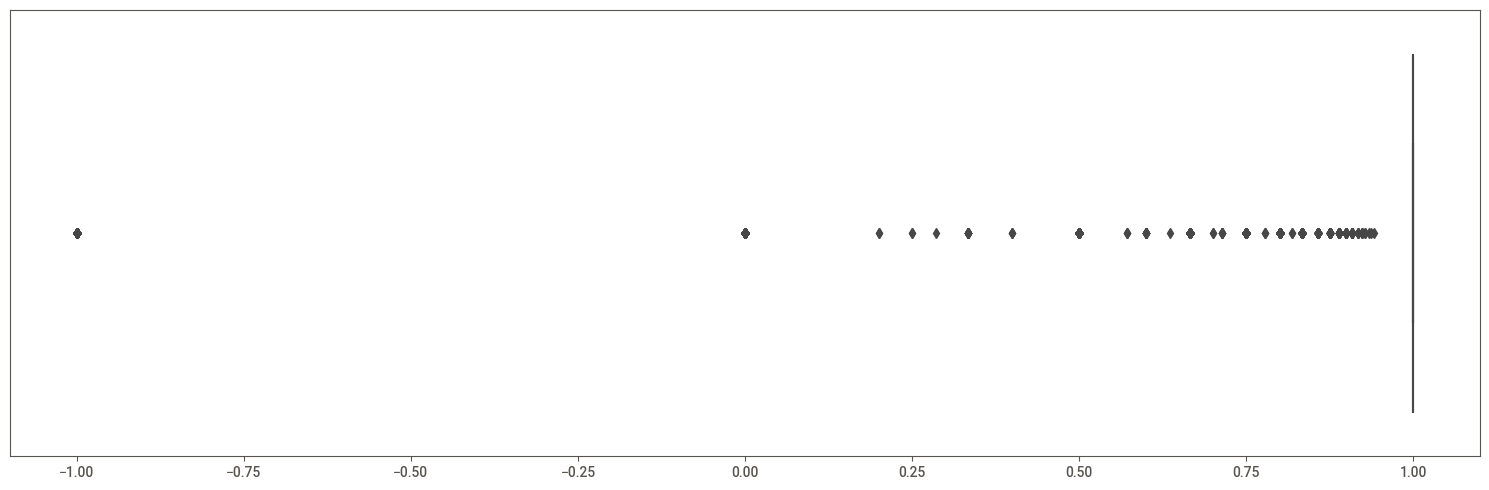

*****************************************************************************************************************************


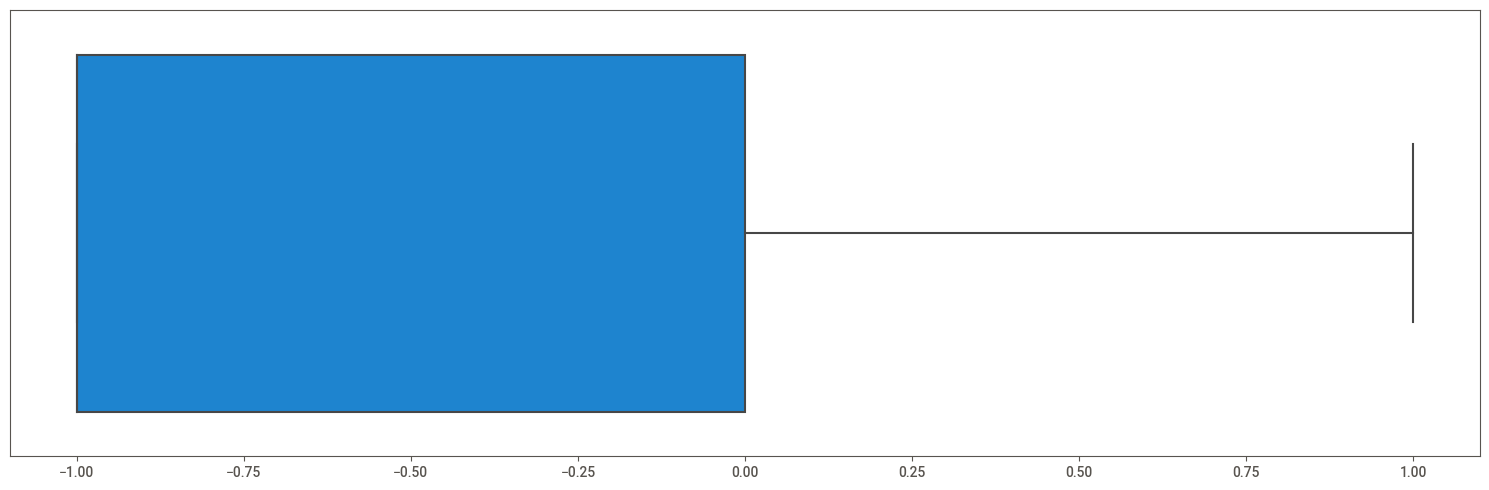

*****************************************************************************************************************************


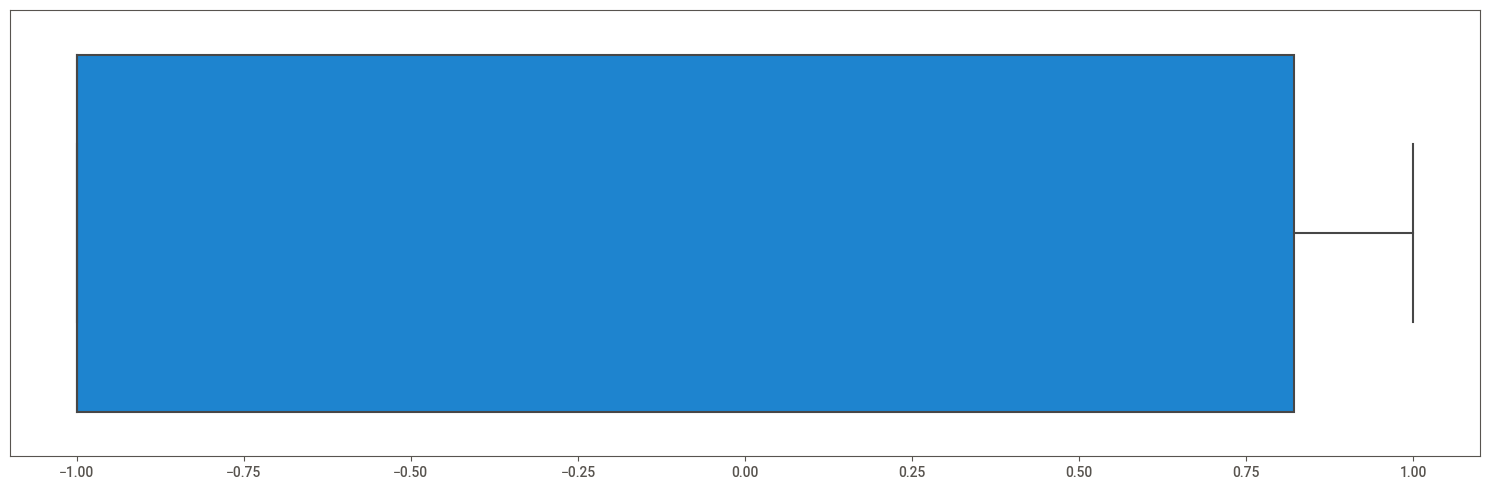

*****************************************************************************************************************************


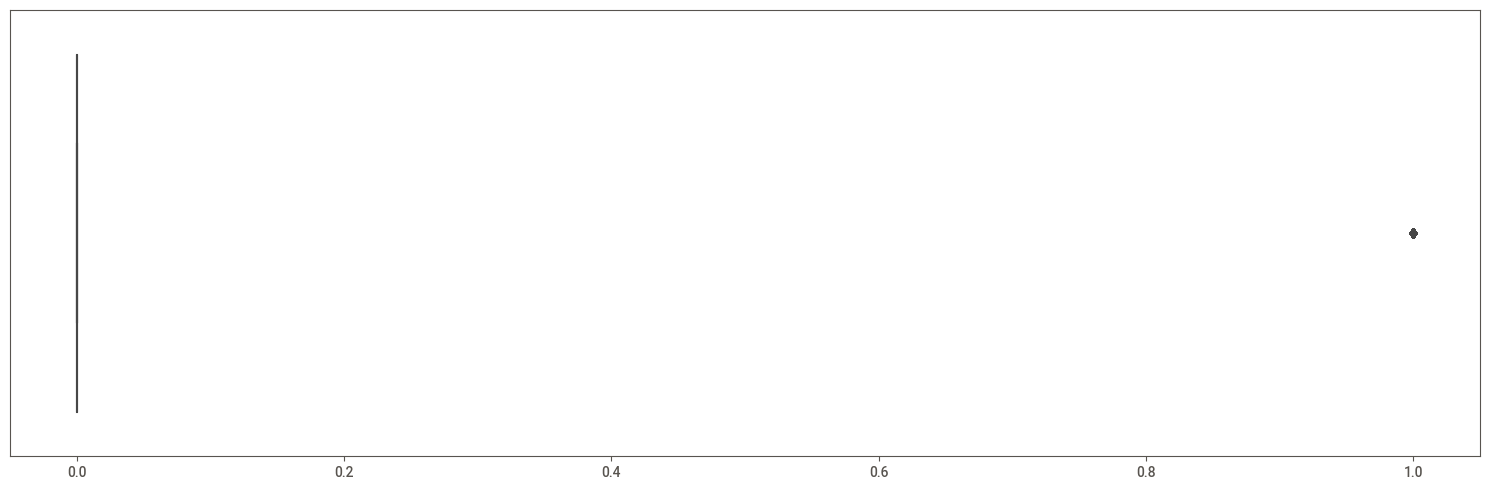

*****************************************************************************************************************************


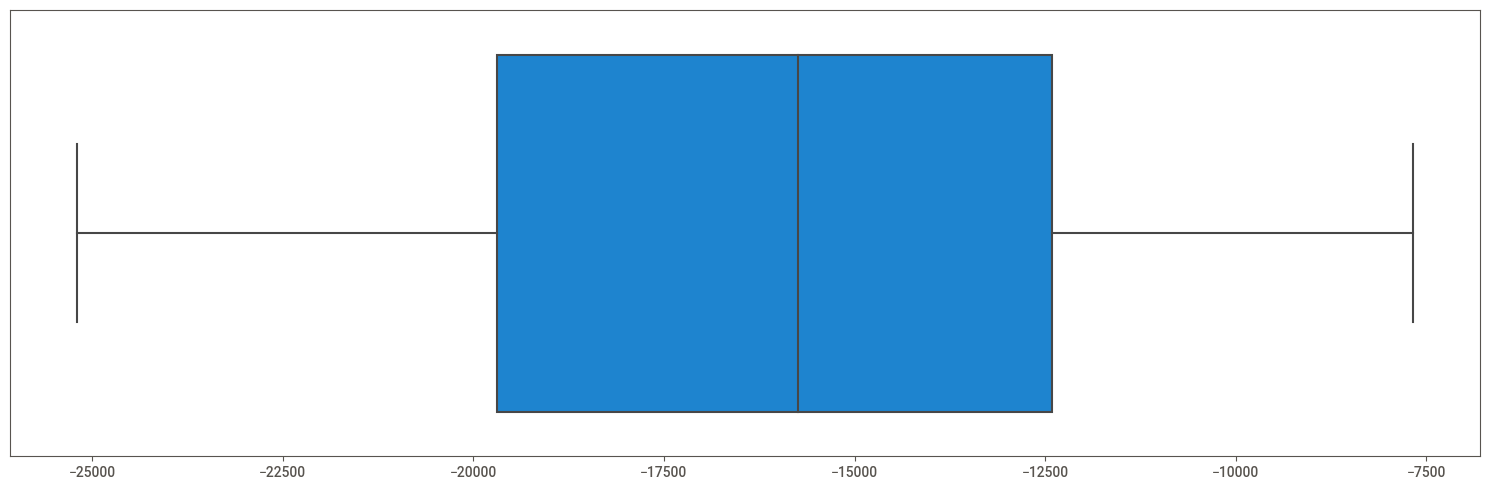

*****************************************************************************************************************************


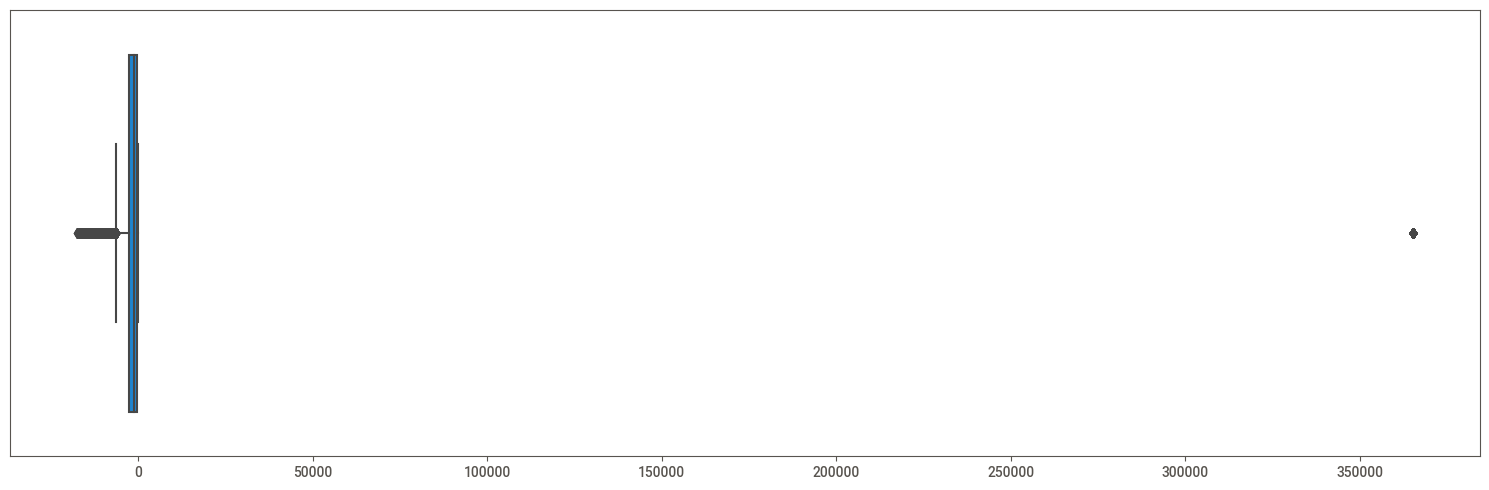

*****************************************************************************************************************************


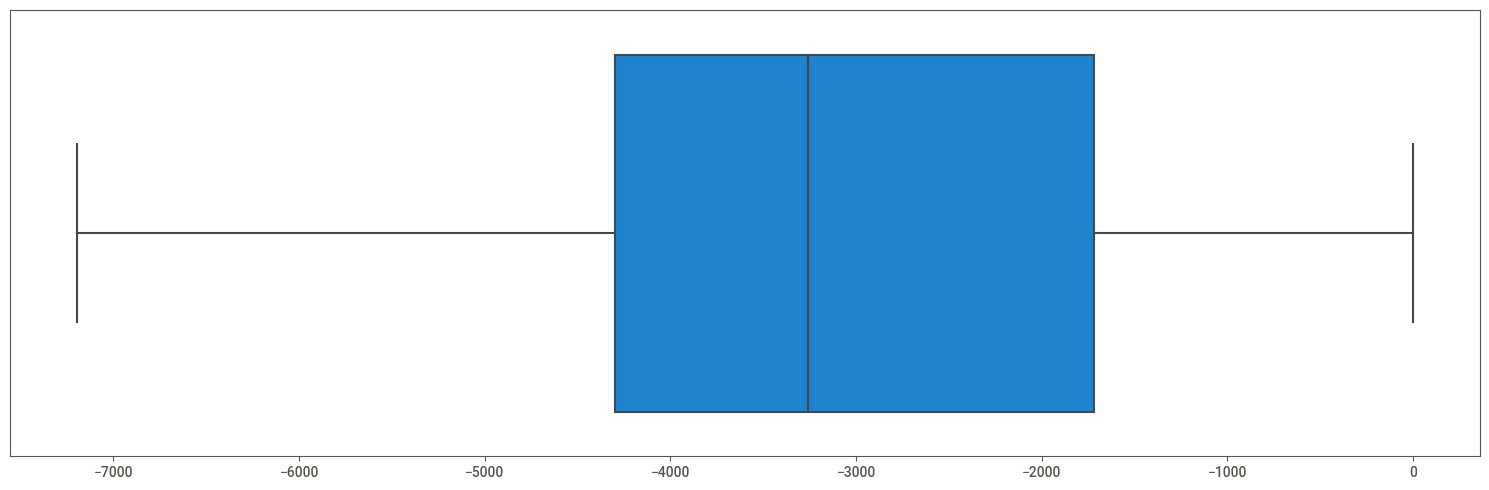

*****************************************************************************************************************************


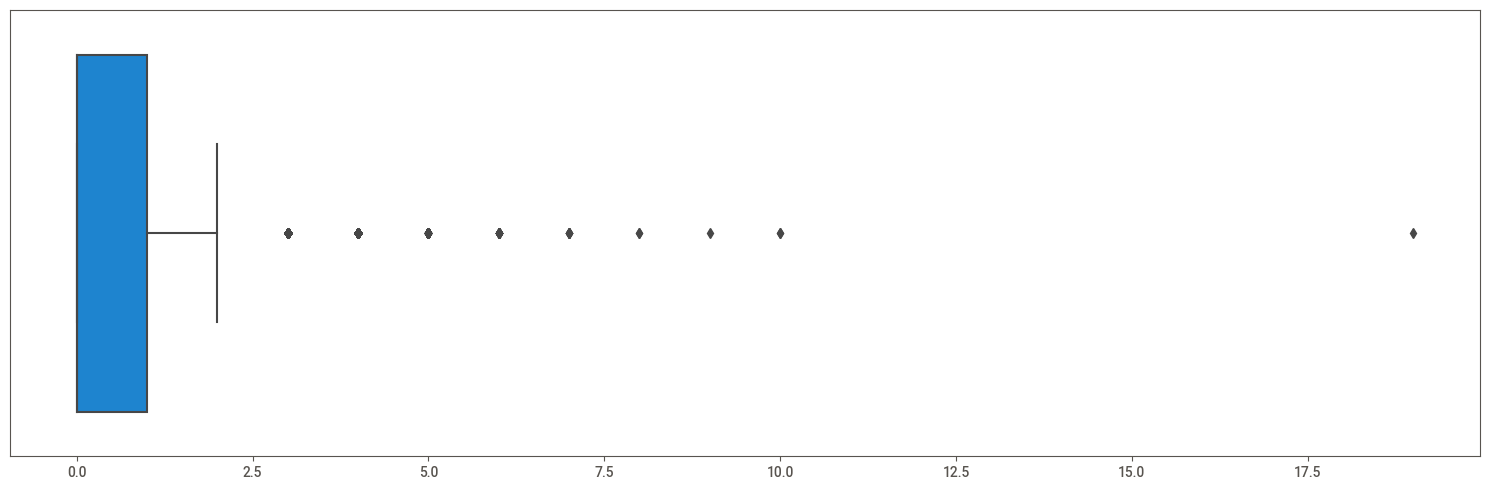

*****************************************************************************************************************************


In [259]:
for col in columns:
   
    plt.figure(figsize=(15,5))

    plt.subplot(1,1,1)
   
    sns.boxplot(data= x_train[col],orient='h')
    
    plt.xticks(fontsize = 10)
    plt.yticks([])
    plt.tight_layout()

    plt.show()
    print('*' * 125)

**Observation:** It seems that there are a lot of outliers, as seen from the boxplots above. Before handling them, lets look at how much outliers are present in those features as follows.

In [260]:
# Finding the number of outliers in each feature
outlier_df = pd.DataFrame()

for index,column in enumerate(columns):
    
    Q1 = x_train[column].quantile(0.25)
    Q3 = x_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    
    outlier_df.loc[index,'Feature'] = column
    outlier_df.loc[index,'Number_of_Outliers'] = len(x_train[~x_train[column].between(lower_fence,upper_fence)])
    
outlier_df = outlier_df.sort_values('Number_of_Outliers')

outlier_df

Feature  Number_of_Outliers
19                  DAYS_BIRTH                 0.0
17       External_credit_score                 0.0
9                 EXT_SOURCE_2                 0.0
21             DAYS_ID_PUBLISH                 0.0
16  Internal_credit_card_score                 0.0
5            DAYS_REGISTRATION               472.0
18       miss_indicator_def_60               714.0
7              CNT_FAM_MEMBERS              2784.0
22                CNT_CHILDREN              2974.0
10                EXT_SOURCE_3              3082.0
1                   AMT_CREDIT              4612.0
2                  AMT_ANNUITY              5277.0
4   REGION_POPULATION_RELATIVE              5875.0
0             AMT_INCOME_TOTAL              9856.0
3              AMT_GOODS_PRICE             10304.0
13    OBS_60_CNT_SOCIAL_CIRCLE             13673.0
11    OBS_30_CNT_SOCIAL_CIRCLE             13959.0
15          Internal_POS_score             17595.0
14    DEF_60_CNT_SOCIAL_CIRCLE             18643.0
6                  OWN_CAR_AGE             20079.0
12    DEF_30_CNT_SOCIAL_CIRCLE             25269.0
20               DAYS_EMPLOYED             50600.0
8                 EXT_SOURCE_1             93884.0

**Observation:** There are a lot of outliers for those features. We are keeping them as it is to avoid loss of information. However,there are a few values that looks invalid. We are handling them by dropping the corresponding records.

### Handling Invalid Values

In [261]:
x_train[x_train.AMT_INCOME_TOTAL == 117000000.0]

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_REALTY  CNT_CHILDREN  \
12840       1         Cash loans           F               Y             1   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
12840       117000000.0    562491.0      26194.5         454500.0   

      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
12840          Working  Secondary / secondary special            Married   

       NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
12840  House / apartment                    0.010643      -12615   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
12840           -922            -6762.0            -3643         -1.0   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
12840               1                0                 1           0   

       FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
12840           0        Laborers              3.0                     2   

       REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  \
12840                            2                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
12840                           0                            0   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
12840                       0                       0   

       LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
12840                        0  Business Entity Type 3      0.460809   

       EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
12840      0.113161      0.145543                       0.0   

       DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
12840                       0.0                       0.0   

       DEF_60_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
12840                       0.0                0                1   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
12840                0                0                0                0   

       FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
12840                0                0                 0                 0   

       FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  \
12840                 0                 0                 0                 0   

       FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  \
12840                 0                 0                 0                 0   

       FLAG_DOCUMENT_21  Internal_POS_score  Internal_credit_card_score  \
12840                 0                 1.0                        -1.0   

       External_credit_score  miss_indicator_int_credit  \
12840                   -1.0                          1   

       miss_indicator_ext_credit  miss_indicator_pos_score  \
12840                          1                         0   

       miss_indicator_car_age  miss_indicator_def_60  
12840                       1                    0.0

In [262]:
x_train= x_train.drop(index=[12840],axis=0)

In [263]:
y_train = y_train.drop(index=[12840],axis=0)

**Observation:** The loan applicant has the highest income of all but she has no car. There is probably an error in the value of AMT_INCOME_TOTAL. We are dropping this error record.

In [264]:
x_train.DAYS_EMPLOYED.value_counts().sort_values(ascending = False).head()

DAYS_EMPLOYED
 365243    38756
-229         112
-212         110
-200         108
-199         105
Name: count, dtype: int64

In [265]:
x_train[x_train.DAYS_EMPLOYED == 365243].NAME_INCOME_TYPE.value_counts().head()

NAME_INCOME_TYPE
Pensioner               38740
Unemployed                 16
Businessman                 0
Commercial associate        0
Maternity leave             0
Name: count, dtype: int64

In [266]:
x_train.loc[x_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = -1

**Observations:** DAYS_EMPLOYED feature should only have negative values. But there is a very higher positive value 365243 with many records having the same. It is given that way to indicate 'Unemployed' and 'Pensioners' who are not currently working. We are replacing that with -1 and converting everything else to positive numbers without changing any information.

In [267]:
x_train[x_train["OBS_30_CNT_SOCIAL_CIRCLE"] == 348]

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_REALTY  CNT_CHILDREN  \
148403       0    Revolving loans           M               Y             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
148403          202500.0    180000.0       9000.0         180000.0   

       NAME_INCOME_TYPE NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
148403    State servant    Higher education  Single / not married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
148403  House / apartment                    0.020246      -10111   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
148403          -1917            -2306.0            -2306         -1.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
148403               1                0                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
148403           0      Core staff              1.0                     3   

        REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  \
148403                            3                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
148403                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
148403                       0                       1   

        LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  \
148403                        1            Police      0.360649      0.304506   

        EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
148403      0.357293                     348.0                      34.0   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_2  \
148403                     344.0                      24.0                0   

        FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
148403                0                0                0                0   

        FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
148403                0                0                0                 0   

        FLAG_DOCUMENT_11  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
148403                 0                 0                 0   

        FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
148403                 0                 0                 0   

        FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  \
148403                 0                 0                 0   

        FLAG_DOCUMENT_21  Internal_POS_score  Internal_credit_card_score  \
148403                 0                 1.0                        -1.0   

        External_credit_score  miss_indicator_int_credit  \
148403                   -1.0                          1   

        miss_indicator_ext_credit  miss_indicator_pos_score  \
148403                          1                         0   

        miss_indicator_car_age  miss_indicator_def_60  
148403                       1                    0.0

In [268]:
x_train = x_train.drop(index=[148403],axis=0)

In [269]:
y_train = y_train.drop(index=[148403],axis=0)

**Observations:** There is one record with highest values for OBS_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE. We are dropping the same record.

## Feature Engineering

Feature engineering refers to manipulation — addition, deletion, combination, mutation — of your data set to improve machine learning model training, leading to better performance and greater accuracy. Effective feature engineering is based on sound knowledge of the business problem and the available data sources.

In [270]:
# All values of this features are in days

x_train["DAYS_BIRTH"].head()       

159703   -13587
79269    -17543
232615   -11557
33420    -15750
88191    -19912
Name: DAYS_BIRTH, dtype: int16

In [271]:
#  Converting it into years without losing significant information.

x_train["DAYS_BIRTH"] = x_train["DAYS_BIRTH"]/365
x_test["DAYS_BIRTH"] = x_test["DAYS_BIRTH"]/365

In [272]:
x_train["DAYS_BIRTH"] = x_train.DAYS_BIRTH.round(0).astype('int')
x_test["DAYS_BIRTH"] = x_test.DAYS_BIRTH.round(0).astype('int')

In [273]:
x_train["DAYS_BIRTH"].head()

159703   -37
79269    -48
232615   -32
33420    -43
88191    -55
Name: DAYS_BIRTH, dtype: int32

## Categorical Encoding

In [274]:
no_cat_cols = x_train.select_dtypes('category').shape[1]

print('Number of categorical features in the dataset before categorical encoding',no_cat_cols)              

Number of categorical features in the dataset before categorical encoding 9


In [275]:
x_train.select_dtypes('category').nunique()    

NAME_CONTRACT_TYPE      2
CODE_GENDER             3
FLAG_OWN_REALTY         2
NAME_INCOME_TYPE        8
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      6
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        18
ORGANIZATION_TYPE      58
dtype: int64

**Observations:** All categorical features except OCCUPATION_TYPE,ORGANIZATION_TYPE have low cardinality. Lower cardinal features are either encoded as one-hot or ordinal. Higher cardinal features (with no inherent order) are encoded with Target Encoding technique.

In [276]:
home_order = dict(zip(['Y','N'],range(2)))
                  
education_order =dict(zip(['Lower secondary','Secondary / secondary special','Incomplete higher',
          'Higher education','Academic degree'],range(5)))
                  
income_order = dict(zip(['Unemployed','Pensioner','Student','Maternity leave','Working','State servant',
                               'Commercial associate','Businessman'],range(8)))

In [277]:
ordinal_enc = OrdinalEncoder(
                             cols=['FLAG_OWN_REALTY','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE'],
    
                             mapping= [{'col': 'FLAG_OWN_REALTY','mapping': home_order},
                                       {'col': 'NAME_EDUCATION_TYPE','mapping': education_order},
                                       {'col': 'NAME_INCOME_TYPE', 'mapping': income_order}]
                            )

In [278]:
x_train = ordinal_enc.fit_transform(x_train)
x_test = ordinal_enc.transform(x_test)

In [279]:
target_enc = TargetEncoder(cols = ['OCCUPATION_TYPE','ORGANIZATION_TYPE'])


In [280]:
np.seterr(under='ignore')

x_train = target_enc.fit_transform(x_train,x_train['TARGET'])
x_test = target_enc.transform(x_test)

In [281]:
ohe_encoder = OneHotEncoder(cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_HOUSING_TYPE','NAME_FAMILY_STATUS'])

In [282]:
x_train = ohe_encoder.fit_transform(x_train)
x_test = ohe_encoder.transform(x_test)

In [283]:
no_cat_cols_ce = x_train.select_dtypes('category').shape[1]

print('Number of categorical features in the dataset after categorical encoding =',no_cat_cols_ce)              

Number of categorical features in the dataset after categorical encoding = 0


## Feature Selection

 Feature Selection is the method of reducing the input variable to your model by using only relevant data and getting rid of noise in data. It is the process of automatically choosing relevant features for your machine learning model based on the type of problem you are trying to solve.02

In [284]:
total_features_before_fs = x_train.shape[1]

print('Number of features in the dataset',total_features_before_fs)

Number of features in the dataset 82


In [285]:
x_train['AMT_CREDIT'].corr(x_train['AMT_GOODS_PRICE'])

0.9867677237412888

**Observation:** AMT_GOODS_PRICE and AMT_CREDIT are extremely correlated. We are dropping AMT_GOODS_PRICE to avoid multi-collinearity.

In [286]:
x_train.drop(columns= 'AMT_GOODS_PRICE',inplace = True)
x_test.drop(columns= 'AMT_GOODS_PRICE',inplace = True)

In [287]:
# All categorical features to be analysed for feature selection

categorical_features = ['FLAG_EMAIL','REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 
 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3', 
'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9', 
'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','FLAG_PHONE',
'FLAG_CONT_MOBILE','FLAG_EMP_PHONE','FLAG_OWN_REALTY','FLAG_WORK_PHONE','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT', 
'NAME_EDUCATION_TYPE','NAME_INCOME_TYPE', 'DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE', 'CNT_CHILDREN', 
'CNT_FAM_MEMBERS','OCCUPATION_TYPE', 'OBS_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE']

In [288]:
# Identifying categorical features that has poor relationship with the target

redundant_features = []

for column in categorical_features:
    
    p_value = chi2_contingency(pd.crosstab(x_train[column],x_train.TARGET))[1]
    
    if p_value > 0.05:        
        redundant_features.append(column)
        
print('Categorical Features to be dropped: \n',redundant_features)             

Categorical Features to be dropped: 
 ['FLAG_EMAIL', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_CONT_MOBILE']


In [289]:
# Dropping all redundant categorical features from train and test set

x_train = x_train.drop(columns= redundant_features)
x_test = x_test.drop(columns= redundant_features)

In [290]:
total_features_after_fs = x_train.shape[1]

print('Number of features BEFORE feature selection',total_features_before_fs)

print('Number of features AFTER feature selection',total_features_after_fs)

Number of features BEFORE feature selection 82
Number of features AFTER feature selection 69


## Feature Scaling

In [291]:
scaler = MinMaxScaler()

In [292]:
x_train = x_train.drop(columns = 'TARGET')
x_test = x_test.drop(columns = 'TARGET')

In [293]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Handling Class Imbalance with SMOTE

In [294]:
y_train.value_counts()             

TARGET
0    197879
1     17376
Name: count, dtype: int64

**Observations:** The number of loan defaulters (1) is very lower than that of non-defaulters (0). 

Oversampling is preferred here over under-sampling to avoid losing majority of the records (nearly 18000 records). 

We are using SMOTE for over-sampling the minority class.

In [295]:
smote = SMOTE(sampling_strategy='minority')

In [296]:
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

In [297]:
y_train_smote.value_counts()

TARGET
0    197879
1    197879
Name: count, dtype: int64

**Observation:** The target is now balanced among both the classes, as a result of over-sampling.

# Model Creation

*1. Logistic Regression*

*2. Support Vector Machine*

*3. Random Forest*

*4. Gradient Boosting Classifier*

**Based on the business case, we are trying to create a model to detect loan defaulters to the best extent. Hence we are preferring recall score over accuracy as the best performance metric.**

### Logistic Regression

In [298]:
lr = LogisticRegression(random_state=42)

In [299]:
lr.fit(x_train_smote,y_train_smote)

LogisticRegression(random_state=42)

In [300]:
y_pred_train = lr.predict(x_train_smote)
y_pred_test = lr.predict(x_test)

In [301]:
print('Train Accuracy score', accuracy_score(y_train_smote,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.6957004027713906

 Test Accuracy score 0.5577861122552952


In [302]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_smote,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.6957004027713907

 Test Balanced Accuracy score 0.6377980239755141


In [303]:
print('Train Recall score', recall_train_lr_smote := recall_score(y_train_smote,y_pred_train))

print('\n Test Recall score', recall_test_lr_smote := recall_score(y_test,y_pred_test))

Train Recall score 0.6989928188438389

 Test Recall score 0.7332169709989259


## Support Vector Machine

- LinearSVC which uses liblinear optimization which is faster than libsvm optimization.

In [304]:
svc= LinearSVC(random_state=42)

In [305]:
svc.fit(x_train_smote,y_train_smote)

LinearSVC(random_state=42)

In [306]:
y_pred_test = svc.predict(x_test)
y_pred_train = svc.predict(x_train_smote)

In [307]:
print('Train Accuracy score', accuracy_score(y_train_smote,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.6959758236093775

 Test Accuracy score 0.5569081015457324


In [308]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_smote,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.6959758236093774

 Test Balanced Accuracy score 0.6374429360390441


In [309]:
print('Train Recall score', recall_train_svm_smote :=  recall_score(y_train_smote,y_pred_train))

print('\n Test Recall score', recall_test_svm_smote := recall_score(y_test,y_pred_test))

Train Recall score 0.7000035375153503

 Test Recall score 0.7334854994629431


### Random Forest

In [310]:
rf= RandomForestClassifier(random_state=42)

In [311]:
rf.fit(x_train_smote,y_train_smote)

RandomForestClassifier(random_state=42)

In [312]:
y_pred_train = rf.predict(x_train_smote)
y_pred_test = rf.predict(x_test)

In [313]:
print('Train Accuracy score', accuracy_score(y_train_smote,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 1.0

 Test Accuracy score 0.9168599735512823


In [314]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_smote,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 1.0

 Test Balanced Accuracy score 0.5077541037428878


In [315]:
print('Train Recall score', recall_train_rf_smote := recall_score(y_train_smote,y_pred_train))

print('\n Test Recall score', recall_test_rf_smote :=  recall_score(y_test,y_pred_test))

Train Recall score 1.0

 Test Recall score 0.01987110633727175


### Gradient Boosting Classifier

In [316]:
gb = GradientBoostingClassifier(random_state=42)

In [317]:
gb.fit(x_train_smote,y_train_smote)

GradientBoostingClassifier(random_state=42)

In [318]:
y_pred_train = gb.predict(x_train_smote)
y_pred_test = gb.predict(x_test)

In [319]:
print('Train Accuracy score', accuracy_score(y_train_smote,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.9220533760530425

 Test Accuracy score 0.906117891907126


In [320]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_smote,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.9220533760530425

 Test Balanced Accuracy score 0.5241401361160607


In [321]:
print('Train Recall score', recall_train_gb_smote := recall_score(y_train_smote,y_pred_train))

print('\n Test Recall score',recall_test_gb_smote :=  recall_score(y_test,y_pred_test))

Train Recall score 0.8641745713289435

 Test Recall score 0.06860902255639098


**Observation:** After trying all the above four models, we thought to go for hyperparameter tuning (HPT) for improving our recall scores. But HPT was taking too much time because of almost 4 lakh records (created at the end of SMOTE) to train on hyperparameters and we found no significant improvement in scores. As an alternative to improve scores, we are trying a different strategy for resampling the unbalanced data using oversampling with ADASYN followed by undersampling with NeighbourhoodCleaningRule. 

## Oversampling & Undersampling 

In [322]:
# ADASYN for oversampling

adasyn = ADASYN(sampling_strategy='auto',  
                random_state= 42,          
                n_neighbors=5,
                n_jobs= cpu_count() - 1)               

In [323]:
# Neighbourhood Cleaning for undersampling

ncr = NeighbourhoodCleaningRule(sampling_strategy='all',
                                n_neighbors=3, 
                                kind_sel='mode', 
                                threshold_cleaning=0.1) 

In [324]:
scaler = MinMaxScaler()

In [325]:
scaler.fit(x_train)

MinMaxScaler()

In [326]:
x_train_scaled=scaler.transform(x_train)

In [327]:
x_test_scaled=scaler.transform(x_test)

In [328]:
x_train_sc_ad,y_train_ad=adasyn.fit_resample(x_train_scaled,y_train)

In [329]:
x_train_sc_ad_nc,y_train_ad_nc=ncr.fit_resample(x_train_sc_ad,y_train_ad)

In [330]:
y_train_ad_nc.value_counts()

TARGET
1    197368
0    152559
Name: count, dtype: int64

**Observation:** The minority class is almost balanced as evident from the value_counts above.

In [331]:
print('Number of records after oversampling with undersampling',x_train_sc_ad_nc.shape[0])

Number of records after oversampling with undersampling 349927


## Logistic Regression

In [332]:
lr_2 = LogisticRegression(random_state=42)

In [333]:
lr_2.fit(x_train_sc_ad_nc,y_train_ad_nc)

LogisticRegression(random_state=42)

In [334]:
y_pred_test = lr_2.predict(x_test)
y_pred_train = lr_2.predict(x_train_sc_ad_nc)

In [335]:
print('Train Accuracy score', accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.726551537892189

 Test Accuracy score 0.4759793613285061


In [336]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.7169953131264255

 Test Balanced Accuracy score 0.6310851527614945


In [337]:
print('Train Recall score', recall_train_lr_ad:= recall_score(y_train_ad_nc,y_pred_train))

print('\n Test Recall score',recall_test_lr_ad:= recall_score(y_test,y_pred_test))

Train Recall score 0.7916227554618783

 Test Recall score 0.8160580021482277


## Support Vector Machine

In [338]:
svc_2 = LinearSVC(random_state=42)

In [339]:
svc_2.fit(x_train_sc_ad_nc,y_train_ad_nc)

LinearSVC(random_state=42)

In [340]:
y_pred_test = svc_2.predict(x_test)
y_pred_train = svc_2.predict(x_train_sc_ad_nc)

In [341]:
print('Train Accuracy score', accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.7264086509471975

 Test Accuracy score 0.47466776508335684


In [342]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.7168202808724613

 Test Balanced Accuracy score 0.6308616502951464


In [343]:
print('Train Recall score', recall_train_svm_ad:= recall_score(y_train_ad_nc,y_pred_train))

print('\n Test Recall score', recall_test_svm_ad:= recall_score(y_test,y_pred_test))

Train Recall score 0.791698755624012

 Test Recall score 0.8171321160042965


## Random Forest

In [344]:
rf_2 = RandomForestClassifier(random_state=42)

In [345]:
rf_2.fit(x_train_sc_ad_nc,y_train_ad_nc)

RandomForestClassifier(random_state=42)

In [346]:
y_pred_test = rf_2.predict(x_test)
y_pred_train = rf_2.predict(x_train_sc_ad_nc)

In [347]:
print('Train Accuracy score', accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.9999971422611001

 Test Accuracy score 0.9032887462874238


In [348]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.9999974666612622

 Test Balanced Accuracy score 0.5401149136287375


In [349]:
print('Train Recall score',  recall_train_rf_ad:= recall_score(y_train_ad_nc,y_pred_train))

print('\n Test Recall score',  recall_test_rf_ad:= recall_score(y_test,y_pred_test))

Train Recall score 0.9999949333225244

 Test Recall score 0.10700859291084855


## Gradient Boosting Classifier

In [350]:
gb_2 = GradientBoostingClassifier(random_state=42)

In [351]:
gb_2.fit(x_train_sc_ad_nc,y_train_ad_nc)

GradientBoostingClassifier(random_state=42)

In [352]:
y_pred_test = gb_2.predict(x_test)
y_pred_train = gb_2.predict(x_train_sc_ad_nc)

In [353]:
print('Train Accuracy score', accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Accuracy score', accuracy_score(y_test,y_pred_test))

Train Accuracy score 0.9132733398680296

 Test Accuracy score 0.8634205562902422


In [354]:
print('Train Balanced Accuracy score', balanced_accuracy_score(y_train_ad_nc,y_pred_train))

print('\n Test Balanced Accuracy score', balanced_accuracy_score(y_test,y_pred_test))

Train Balanced Accuracy score 0.9162488727973559

 Test Balanced Accuracy score 0.5774006905708823


In [355]:
print('Train Recall score', recall_train_gb_ad:= recall_score(y_train_ad_nc,y_pred_train))

print('\n Test Recall score',  recall_test_gb_ad:= recall_score(y_test,y_pred_test))

Train Recall score 0.893012038425682

 Test Recall score 0.23630504833512353


**Observation:** The results have improved significantly by using the combination of oversampling and undersampling relative to SMOTE.

In [356]:
# Dataframe creation for model comparison

model_comparison = pd.DataFrame()

model_comparison['Algorithm'] = ['Logistic Regression','Logistic Regression', 'Support Vector Machine', 
                                 'Support Vector Machine','Random Forest','Random Forest',
                                 'Gradient Boosting Classifier','Gradient Boosting Classifier']

model_comparison['Resampling Technique'] = ['SMOTE','ADASYN- NeighbourhoodCleaning','SMOTE','ADASYN- NeighbourhoodCleaning',
                                            'SMOTE','ADASYN- NeighbourhoodCleaning','SMOTE','ADASYN- NeighbourhoodCleaning']

model_comparison['Recall score (Train)'] = [recall_train_lr_smote,
                                            recall_train_lr_ad,
                                            recall_train_svm_smote,
                                            recall_train_svm_ad,
                                            recall_train_rf_smote,
                                            recall_train_rf_ad,
                                            recall_train_gb_smote,
                                            recall_train_gb_ad]

model_comparison['Recall score (Test)'] =  [recall_test_lr_smote,
                                            recall_test_lr_ad,
                                            recall_test_svm_smote,
                                            recall_test_svm_ad,
                                            recall_test_rf_smote,
                                            recall_test_rf_ad,
                                            recall_test_gb_smote,
                                            recall_test_gb_ad]

model_comparison.set_index(['Algorithm','Resampling Technique'],inplace=True)


In [357]:
model_comparison           # Df with all 4 models compared 

Recall score (Train)  \
Algorithm                    Resampling Technique                                  
Logistic Regression          SMOTE                                      0.698993   
                             ADASYN- NeighbourhoodCleaning              0.791623   
Support Vector Machine       SMOTE                                      0.700004   
                             ADASYN- NeighbourhoodCleaning              0.791699   
Random Forest                SMOTE                                      1.000000   
                             ADASYN- NeighbourhoodCleaning              0.999995   
Gradient Boosting Classifier SMOTE                                      0.864175   
                             ADASYN- NeighbourhoodCleaning              0.893012   

                                                            Recall score (Test)  
Algorithm                    Resampling Technique                                
Logistic Regression          SMOTE                                     0.733217  
                             ADASYN- NeighbourhoodCleaning             0.816058  
Support Vector Machine       SMOTE                                     0.733485  
                             ADASYN- NeighbourhoodCleaning             0.817132  
Random Forest                SMOTE                                     0.019871  
                             ADASYN- NeighbourhoodCleaning             0.107009  
Gradient Boosting Classifier SMOTE                                     0.068609  
                             ADASYN- NeighbourhoodCleaning             0.236305

**Observation:** The recall scores for all four models with ADASYN- NeighbourhoodCleaning technique are better than that of SMOTE.

## Model Comparison 

In [358]:
# Dataframe creation

model_comparison = pd.DataFrame()

model_comparison['Algorithm']= ['Logistic Regression', 'Support Vector Machine', 'Random Forest','Gradient Boosting Classifier']
                                 
model_comparison['Recall score (Train)'] = [recall_train_lr_ad,
                                            recall_train_svm_ad,
                                            recall_train_rf_ad,
                                            recall_train_gb_ad]

model_comparison['Recall score (Test)'] =  [recall_test_lr_ad,
                                            recall_test_svm_ad,
                                            recall_test_rf_ad,
                                            recall_test_gb_ad]

model_comparison.set_index('Algorithm',inplace=True)


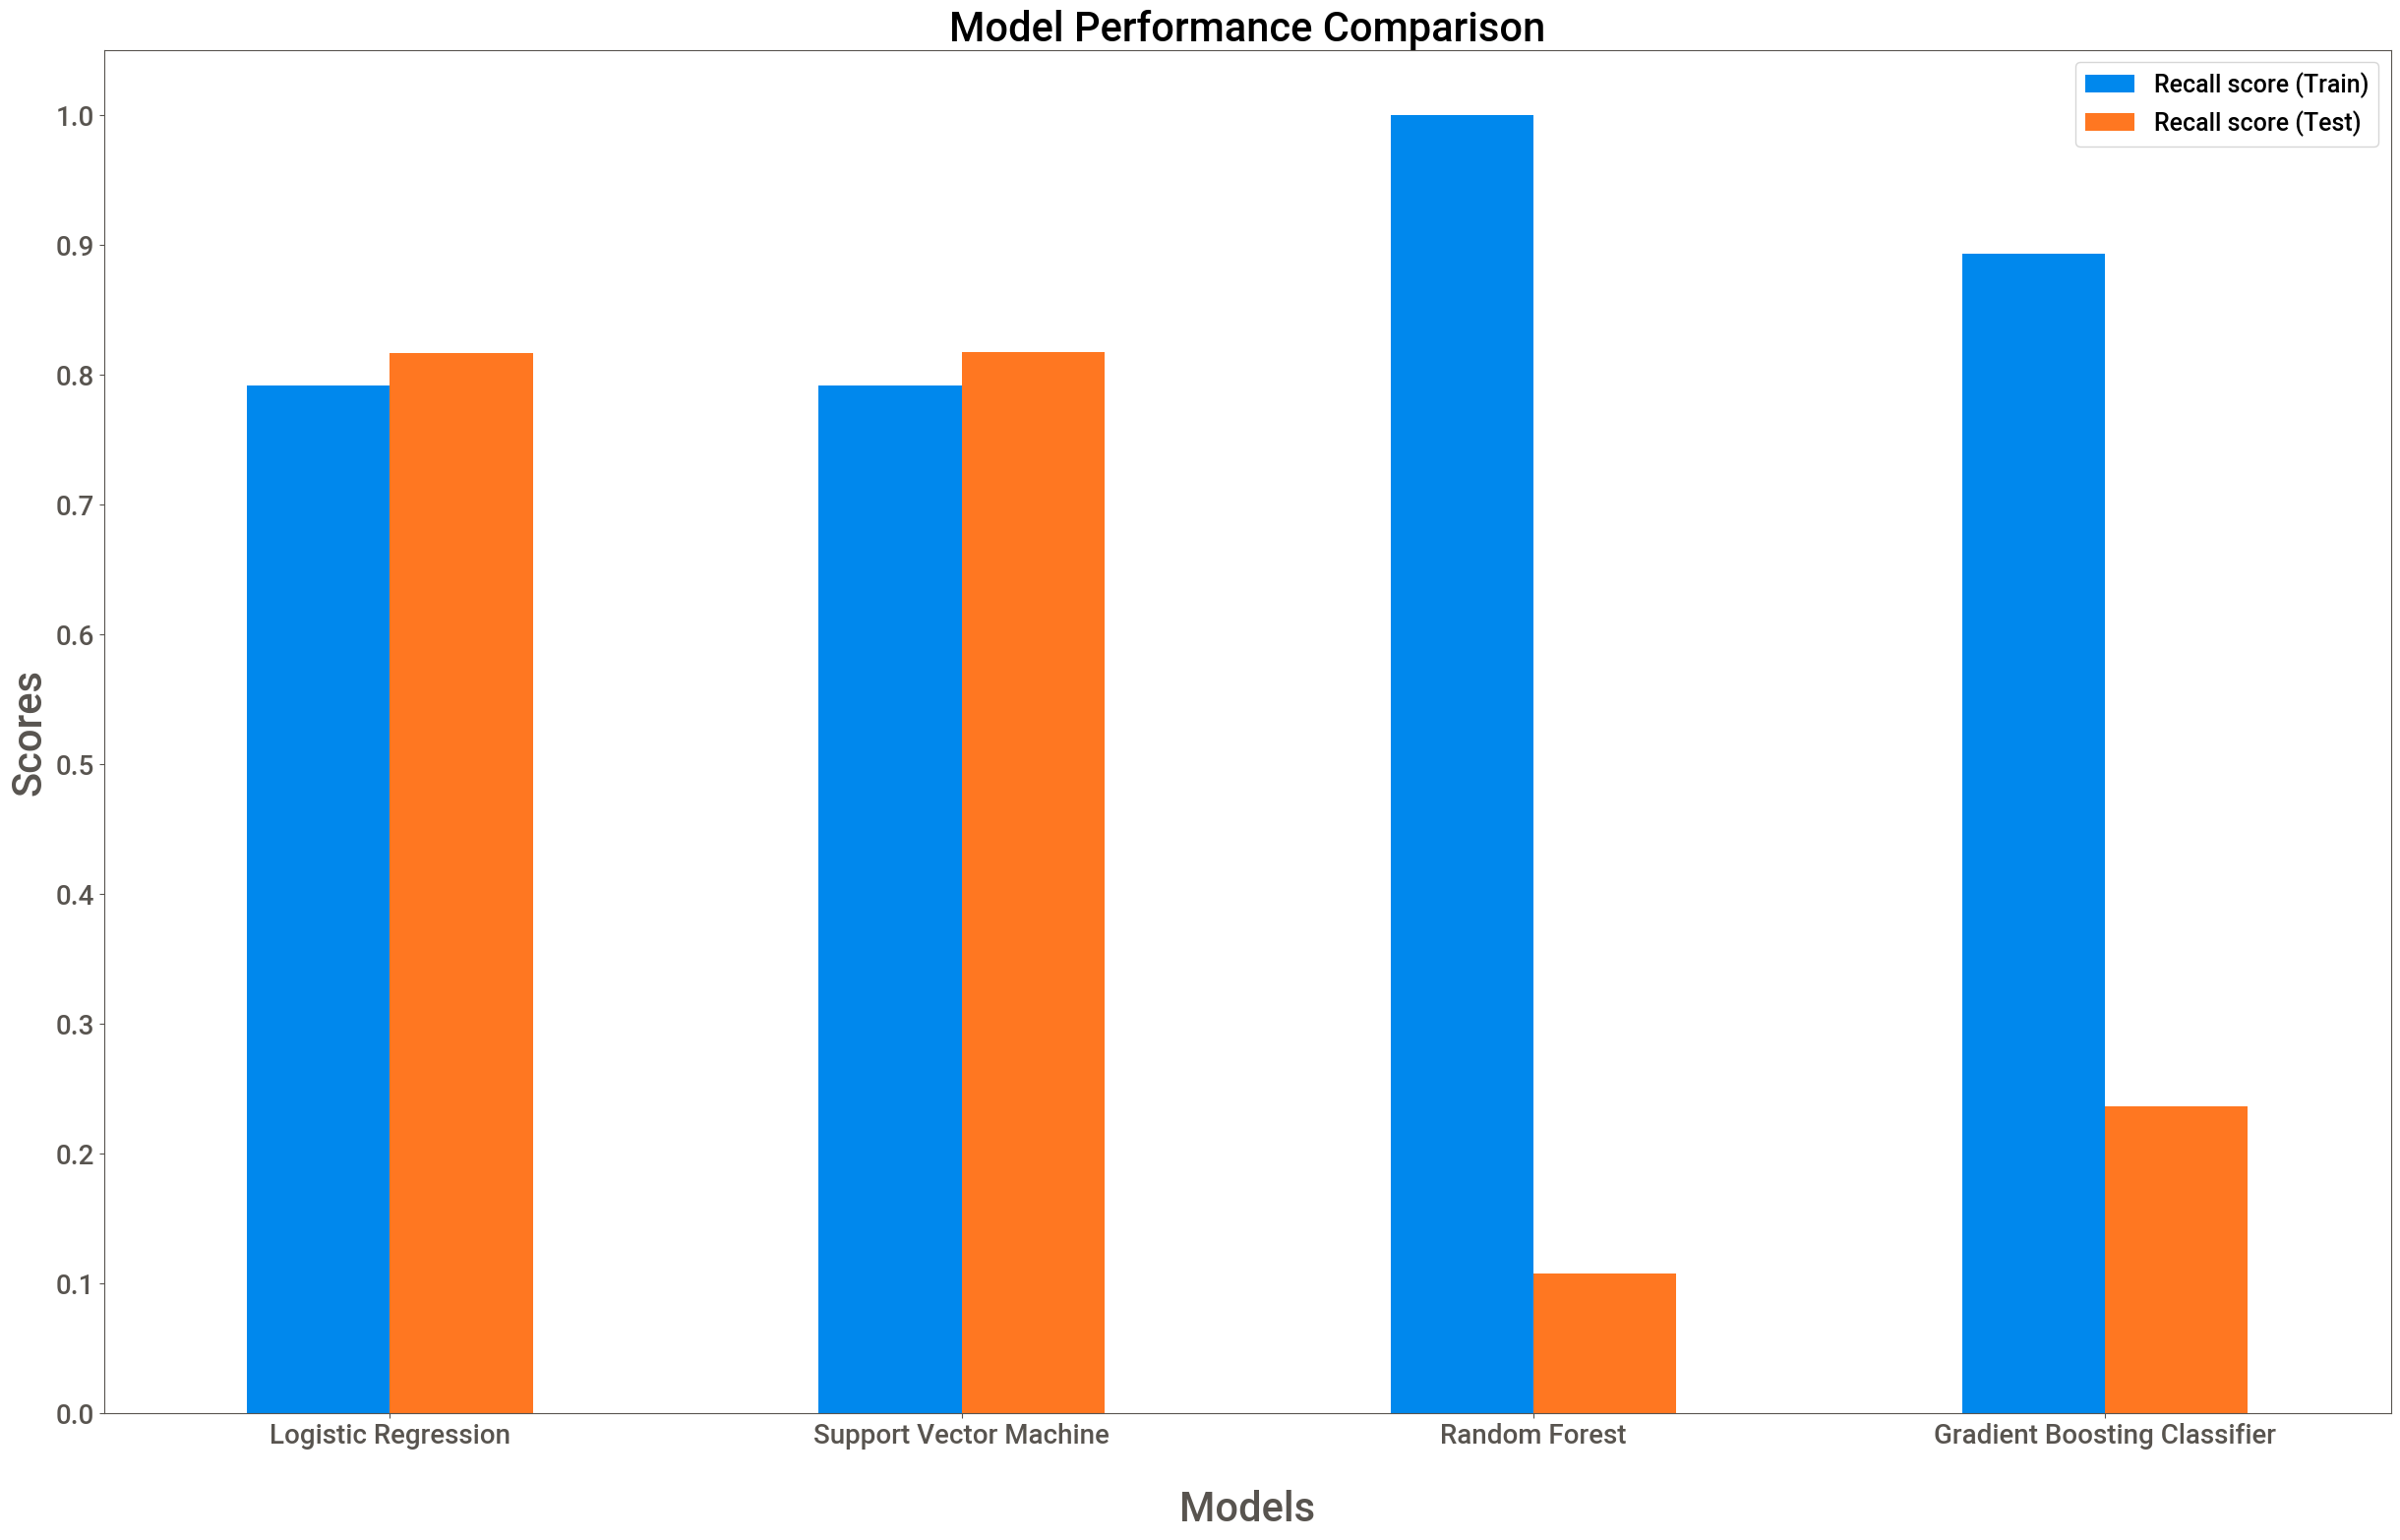

In [359]:
model_comparison.plot.bar(figsize =(30,18),rot =0,fontsize= 20)
plt.xlabel("Models", labelpad = 30,fontsize = 30)
plt.ylabel('Scores',fontsize = 30)
plt.yticks(np.arange(0,1.1,0.1))
plt.legend(fontsize = 18)
plt.title('Model Performance Comparison',fontsize = 30);

**CONCLUSION:**  


Linear models (Logistic regression and Linear SVC) are performing better than the tree based models (Random Forest and Gradient Boosting Classifier). The former models are of right fit while the latter models are overfitting.